In [67]:
# from IPython import get_ipython

# Sentiment analysis with hotel reviews

Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts. This is usually used on social media posts and customer reviews in order to automatically understand if some users are positive or negative and why. The goal of this study is to show how sentiment analysis can be performed using python. Here are some of the main libraries we will use:

- NLTK: the most famous python module for NLP techniques
- Gensim: a topic-modelling and vector space modelling toolkit
- Scikit-learn: the most used python machine learning library

We will use here some hotel reviews data. **Each row consists of one customer review for one hotel.** Each customer review is composed of a textual feedback of the customer's experience at the hotel and an overall rating. The data can be found here:
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

For each textual review, we want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 2.5/10 to 10/10. In order to simplify the problem we will split those into two categories:
- bad reviews have overall ratings < 5
- good reviews have overall ratings >= 5

The challenge here is to be able to predict this information using only the raw textual data from the review.
Let's get it started!

In [68]:
# # Load data
# We first start by loading the raw data. Each textual reviews is splitted into a positive part and a negative part. We group them together in order to start with only raw text data and no other information.

#%%
import pandas as pd
pd.set_option('max_colwidth', 50)

# read data
reviews_df = pd.read_csv("./Hotel_Reviews_trim.csv")
reviews_df.head(5)



Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968  
2  52.360576  4.915968  
3  52.360576  4.915968  
4  52.360576  4.915968

In [69]:
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]

pd.set_option('max_colwidth', 400)

print(type(reviews_df))
reviews_df.shape

# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# # select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]

reviews_df.head()

<class 'pandas.core.frame.DataFrame'>


review  \
0   I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the ...   
1  No Negative No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out a...   
2                                                                                                     Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge  Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back    
3   My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in m...   
4   You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...   

   is_bad_review  
0              1  
1              0  
2              0  
3              1  
4              0

In [70]:
print(type(reviews_df))
print(reviews_df.shape)
# # Sample data
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)
print(reviews_df.shape)

<class 'pandas.core.frame.DataFrame'>
(40828, 2)
(4083, 2)


In [71]:
# We sample the data in order to speed up computations.
# # Clean data

# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

reviews_df.head()

reviews_df.sort_index(inplace=True)

reviews_df.head()


review  \
1    No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellen...   
4    You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...   
7                                                                                                                                                                                                                                                      Apart from the price for the brekfast Everything very good Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast    
13                                                                         This hotel is being renovated with great care and with an appreciation for its unique structure and location My spacious and comfortable room had a large double paned glass window onto the lush greenery of the park The breakfast selection was spectacular All considered this was a great hotel for the price and I plan to return    
23              Transportation was a bit of a pain but on route to your destination there is amazing views at every corner  Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly    

    is_bad_review  
1               0  
4               0  
7               0  
13              0  
23              0

### If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

The next step consists in cleaning the text data with various operations:

In [72]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet


# get the grammar tags from token
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def _clean_text(text):
    # lower text
    text = text.lower()
    print("1: ", text)
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    print("2: ", text)
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    print("3: ", text)
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    print("4: ", text)
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    print("5: ", text)
    # pos tag text
    pos_tags = pos_tag(text)
    print("6: ", pos_tags)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    print("7: ", text)
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

_clean_text('remove words - with only 11one letter and test string with number 1abc and stop word a')


1:  remove words - with only 11one letter and test string with number 1abc and stop word a
2:  ['remove', 'words', '', 'with', 'only', '11one', 'letter', 'and', 'test', 'string', 'with', 'number', '1abc', 'and', 'stop', 'word', 'a']
3:  ['remove', 'words', '', 'with', 'only', 'letter', 'and', 'test', 'string', 'with', 'number', 'and', 'stop', 'word', 'a']
4:  ['remove', 'words', '', 'letter', 'test', 'string', 'number', 'stop', 'word']
5:  ['remove', 'words', 'letter', 'test', 'string', 'number', 'stop', 'word']
6:  [('remove', 'VB'), ('words', 'NNS'), ('letter', 'NN'), ('test', 'NN'), ('string', 'NN'), ('number', 'NN'), ('stop', 'NN'), ('word', 'NN')]
7:  ['remove', 'word', 'letter', 'test', 'string', 'number', 'stop', 'word']


'remove word letter test string number stop word'

In [73]:
%%time
#measure execution time
#to measure and display the time to compute this cell

# clean text data
reviews_df["review"].apply(lambda x: _clean_text(x))



1:   no real complaints the hotel was great great location surroundings rooms amenities and service two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one bit confusing secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great aside from those minor minor things fantastic spot and will be back when i return to amsterdam 
2:  ['', 'no', 'real', 'complaints', 'the', 'hotel', 'was', 'great', 'great', 'location', 'surroundings', 'rooms', 'amenities', 'and', 'service', 'two', 'recommendations', 'however', 'firstly', 'the', 'staff', 'upon', 'check', 'in', 'are', 'very', 'confusing', 'regarding', 'deposit', 'payments', 'and', 'the', 'staff', 'offer', 'you', 'upon', 'checkout', 'to', 'refund', 'your', 'ori

1:   nearly everything about my stay the only thing i love was that the bed was comfy and the building on the outside everything else i hated
2:  ['', 'nearly', 'everything', 'about', 'my', 'stay', 'the', 'only', 'thing', 'i', 'love', 'was', 'that', 'the', 'bed', 'was', 'comfy', 'and', 'the', 'building', 'on', 'the', 'outside', 'everything', 'else', 'i', 'hated']
3:  ['', 'nearly', 'everything', 'about', 'my', 'stay', 'the', 'only', 'thing', 'i', 'love', 'was', 'that', 'the', 'bed', 'was', 'comfy', 'and', 'the', 'building', 'on', 'the', 'outside', 'everything', 'else', 'i', 'hated']
4:  ['', 'nearly', 'everything', 'stay', 'thing', 'love', 'bed', 'comfy', 'building', 'outside', 'everything', 'else', 'hated']
5:  ['nearly', 'everything', 'stay', 'thing', 'love', 'bed', 'comfy', 'building', 'outside', 'everything', 'else', 'hated']
6:  [('nearly', 'RB'), ('everything', 'NN'), ('stay', 'JJ'), ('thing', 'NN'), ('love', 'NN'), ('bed', 'VBD'), ('comfy', 'JJ'), ('building', 'NN'), ('outside',

6:  [('fantastic', 'JJ'), ('staff', 'NN'), ('could', 'MD'), ('helpful', 'VB'), ('friendly', 'JJ'), ('professional', 'JJ')]
7:  ['fantastic', 'staff', 'could', 'helpful', 'friendly', 'professional']
1:   the overall hotel was fine would love to return when the building work is complete
2:  ['', 'the', 'overall', 'hotel', 'was', 'fine', 'would', 'love', 'to', 'return', 'when', 'the', 'building', 'work', 'is', 'complete']
3:  ['', 'the', 'overall', 'hotel', 'was', 'fine', 'would', 'love', 'to', 'return', 'when', 'the', 'building', 'work', 'is', 'complete']
4:  ['', 'overall', 'hotel', 'fine', 'would', 'love', 'return', 'building', 'work', 'complete']
5:  ['overall', 'hotel', 'fine', 'would', 'love', 'return', 'building', 'work', 'complete']
6:  [('overall', 'JJ'), ('hotel', 'NN'), ('fine', 'NN'), ('would', 'MD'), ('love', 'VB'), ('return', 'NN'), ('building', 'VBG'), ('work', 'NN'), ('complete', 'NN')]
7:  ['overall', 'hotel', 'fine', 'would', 'love', 'return', 'build', 'work', 'complete'

4:  ['', 'choice', 'food', 'bar', 'good', 'lots', 'great', 'places', 'eat', 'nearby', 'problem', '', 'quiet', 'comfy', 'room', 'helpful', 'staff', 'excellent', 'location', 'earls', 'court', 'tube', 'lots', 'excellent', 'places', 'eat', 'close', '']
5:  ['choice', 'food', 'bar', 'good', 'lots', 'great', 'places', 'eat', 'nearby', 'problem', 'quiet', 'comfy', 'room', 'helpful', 'staff', 'excellent', 'location', 'earls', 'court', 'tube', 'lots', 'excellent', 'places', 'eat', 'close']
6:  [('choice', 'NN'), ('food', 'NN'), ('bar', 'NN'), ('good', 'JJ'), ('lots', 'NNS'), ('great', 'JJ'), ('places', 'NNS'), ('eat', 'VBP'), ('nearby', 'JJ'), ('problem', 'NN'), ('quiet', 'JJ'), ('comfy', 'NN'), ('room', 'NN'), ('helpful', 'JJ'), ('staff', 'NN'), ('excellent', 'JJ'), ('location', 'NN'), ('earls', 'NNS'), ('court', 'NN'), ('tube', 'VBP'), ('lots', 'NNS'), ('excellent', 'JJ'), ('places', 'NNS'), ('eat', 'VBP'), ('close', 'JJ')]
7:  ['choice', 'food', 'bar', 'good', 'lot', 'great', 'place', 'eat',

4:  ['', 'one', 'complaint', 'overly', 'soft', 'mattresses', 'good', 'back', '', 'friendly', 'helpful', 'staff', 'facilities', 'good', 'including', 'bar', 'earl', 'court', 'tube', 'station', 'steps', 'away', 'station', 'access', 'several', 'useful', 'lines', 'get', 'prices', 'reasonable', 'nice', 'breakfast', 'buffet', '']
5:  ['one', 'complaint', 'overly', 'soft', 'mattresses', 'good', 'back', 'friendly', 'helpful', 'staff', 'facilities', 'good', 'including', 'bar', 'earl', 'court', 'tube', 'station', 'steps', 'away', 'station', 'access', 'several', 'useful', 'lines', 'get', 'prices', 'reasonable', 'nice', 'breakfast', 'buffet']
6:  [('one', 'CD'), ('complaint', 'NN'), ('overly', 'RB'), ('soft', 'JJ'), ('mattresses', 'NNS'), ('good', 'JJ'), ('back', 'RB'), ('friendly', 'JJ'), ('helpful', 'JJ'), ('staff', 'NN'), ('facilities', 'NNS'), ('good', 'JJ'), ('including', 'VBG'), ('bar', 'NN'), ('earl', 'NN'), ('court', 'NN'), ('tube', 'NN'), ('station', 'NN'), ('steps', 'VBZ'), ('away', 'RB')

6:  [('realise', 'VB'), ('book', 'NN'), ('car', 'NN'), ('parking', 'NN'), ('due', 'JJ'), ('limited', 'VBD'), ('spaces', 'NNS'), ('available', 'JJ'), ('lucky', 'JJ'), ('space', 'NN'), ('book', 'NN'), ('future', 'NN'), ('close', 'JJ'), ('underground', 'JJ'), ('station', 'NN'), ('quiet', 'JJ'), ('location', 'NN'), ('staff', 'NN'), ('excellent', 'JJ'), ('pleasant', 'NN'), ('helpful', 'JJ'), ('good', 'JJ'), ('choice', 'NN'), ('breakfast', 'NN'), ('bed', 'VBD'), ('comfortable', 'JJ'), ('want', 'NN'), ('get', 'NN')]
7:  ['realise', 'book', 'car', 'parking', 'due', 'limit', 'space', 'available', 'lucky', 'space', 'book', 'future', 'close', 'underground', 'station', 'quiet', 'location', 'staff', 'excellent', 'pleasant', 'helpful', 'good', 'choice', 'breakfast', 'bed', 'comfortable', 'want', 'get']
1:   nothing most value for money staffs are very friendly and nice location is great actually i booked 3 hotels during this trip i think k k is most valuable absolutely will book again on next trip 


4:  ['', 'keys', 'rooms', 'system', 'opening', 'doors', 'water', 'shower', 'kept', 'changing', 'temperatures', 'constantly', 'location', 'size', 'room', 'comfort', 'bed']
5:  ['keys', 'rooms', 'system', 'opening', 'doors', 'water', 'shower', 'kept', 'changing', 'temperatures', 'constantly', 'location', 'size', 'room', 'comfort', 'bed']
6:  [('keys', 'NNS'), ('rooms', 'NNS'), ('system', 'NN'), ('opening', 'VBG'), ('doors', 'NNS'), ('water', 'NN'), ('shower', 'VBP'), ('kept', 'IN'), ('changing', 'VBG'), ('temperatures', 'NNS'), ('constantly', 'RB'), ('location', 'VBP'), ('size', 'NN'), ('room', 'NN'), ('comfort', 'NN'), ('bed', 'VBD')]
7:  ['key', 'room', 'system', 'open', 'door', 'water', 'shower', 'kept', 'change', 'temperature', 'constantly', 'location', 'size', 'room', 'comfort', 'bed']
1:   hotel garden and breakfast
2:  ['', 'hotel', 'garden', 'and', 'breakfast']
3:  ['', 'hotel', 'garden', 'and', 'breakfast']
4:  ['', 'hotel', 'garden', 'breakfast']
5:  ['hotel', 'garden', 'breakf

6:  [('staff', 'NN'), ('friendly', 'JJ'), ('efficient', 'JJ'), ('room', 'NN'), ('clean', 'JJ'), ('breakfast', 'NN'), ('good', 'JJ')]
7:  ['staff', 'friendly', 'efficient', 'room', 'clean', 'breakfast', 'good']
1:   no wifi in the room  very clean very good breakfast very close to earls court station
2:  ['', 'no', 'wifi', 'in', 'the', 'room', '', 'very', 'clean', 'very', 'good', 'breakfast', 'very', 'close', 'to', 'earls', 'court', 'station']
3:  ['', 'no', 'wifi', 'in', 'the', 'room', '', 'very', 'clean', 'very', 'good', 'breakfast', 'very', 'close', 'to', 'earls', 'court', 'station']
4:  ['', 'wifi', 'room', '', 'clean', 'good', 'breakfast', 'close', 'earls', 'court', 'station']
5:  ['wifi', 'room', 'clean', 'good', 'breakfast', 'close', 'earls', 'court', 'station']
6:  [('wifi', 'NN'), ('room', 'NN'), ('clean', 'JJ'), ('good', 'JJ'), ('breakfast', 'NN'), ('close', 'JJ'), ('earls', 'JJ'), ('court', 'NN'), ('station', 'NN')]
7:  ['wifi', 'room', 'clean', 'good', 'breakfast', 'close', 

4:  ['', 'think', 'anything', 'pleased', 'everything', 'friendly', 'knowledgable', 'staff', 'enough', 'us', 'made', 'us', 'feel', 'welcome', 'room', 'excellent', 'facilities', 'cleanliness', 'bed', 'fantastic', '']
5:  ['think', 'anything', 'pleased', 'everything', 'friendly', 'knowledgable', 'staff', 'enough', 'us', 'made', 'us', 'feel', 'welcome', 'room', 'excellent', 'facilities', 'cleanliness', 'bed', 'fantastic']
6:  [('think', 'VB'), ('anything', 'NN'), ('pleased', 'JJ'), ('everything', 'NN'), ('friendly', 'RB'), ('knowledgable', 'JJ'), ('staff', 'NN'), ('enough', 'JJ'), ('us', 'PRP'), ('made', 'VBD'), ('us', 'PRP'), ('feel', 'VB'), ('welcome', 'JJ'), ('room', 'NN'), ('excellent', 'NN'), ('facilities', 'NNS'), ('cleanliness', 'VBP'), ('bed', 'VBN'), ('fantastic', 'JJ')]
7:  ['think', 'anything', 'pleased', 'everything', 'friendly', 'knowledgable', 'staff', 'enough', 'u', 'make', 'u', 'feel', 'welcome', 'room', 'excellent', 'facility', 'cleanliness', 'bed', 'fantastic']
1:   excel

1:   had amazing service free upgrade and when my husbands flight delay nearly interfered with our trip they allowed an early check for free and tried their best help faultless service 
2:  ['', 'had', 'amazing', 'service', 'free', 'upgrade', 'and', 'when', 'my', 'husbands', 'flight', 'delay', 'nearly', 'interfered', 'with', 'our', 'trip', 'they', 'allowed', 'an', 'early', 'check', 'for', 'free', 'and', 'tried', 'their', 'best', 'help', 'faultless', 'service', '']
3:  ['', 'had', 'amazing', 'service', 'free', 'upgrade', 'and', 'when', 'my', 'husbands', 'flight', 'delay', 'nearly', 'interfered', 'with', 'our', 'trip', 'they', 'allowed', 'an', 'early', 'check', 'for', 'free', 'and', 'tried', 'their', 'best', 'help', 'faultless', 'service', '']
4:  ['', 'amazing', 'service', 'free', 'upgrade', 'husbands', 'flight', 'delay', 'nearly', 'interfered', 'trip', 'allowed', 'early', 'check', 'free', 'tried', 'best', 'help', 'faultless', 'service', '']
5:  ['amazing', 'service', 'free', 'upgrade',

6:  [('classy', 'JJ'), ('tasteful', 'JJ'), ('cor', 'NN'), ('great', 'JJ'), ('location', 'NN'), ('courteous', 'JJ'), ('staff', 'NN'), ('nice', 'JJ'), ('little', 'JJ'), ('touches', 'NNS'), ('rooms', 'NNS'), ('made', 'VBD'), ('feel', 'VBP'), ('special', 'JJ'), ('nice', 'JJ'), ('place', 'NN'), ('romantic', 'JJ'), ('getaway', 'NN')]
7:  ['classy', 'tasteful', 'cor', 'great', 'location', 'courteous', 'staff', 'nice', 'little', 'touch', 'room', 'make', 'feel', 'special', 'nice', 'place', 'romantic', 'getaway']
1:   nothing  hi standard of accomdation staff were very attentive and good attention to detail with luxury extras provided only a 10 min walk to covent garden very near to the royal courts of justice somerset house and the strand 
2:  ['', 'nothing', '', 'hi', 'standard', 'of', 'accomdation', 'staff', 'were', 'very', 'attentive', 'and', 'good', 'attention', 'to', 'detail', 'with', 'luxury', 'extras', 'provided', 'only', 'a', '10', 'min', 'walk', 'to', 'covent', 'garden', 'very', 'near'

4:  ['', 'single', 'thing', '', 'location', 'excellent', 'midway', 'west', 'end', 'st', 'paul', 'hotel', 'one', 'inns', 'court', 'pleasant', 'quiet', 'isolation', 'within', 'paces', 'onto', 'fleet', 'st', 'hustle', 'bustle', 'city', 'london', 'staff', 'welcoming', 'able', 'upgrade', 'room', 'without', 'fuss', 'whole', 'team', 'helpful', '']
5:  ['single', 'thing', 'location', 'excellent', 'midway', 'west', 'end', 'st', 'paul', 'hotel', 'one', 'inns', 'court', 'pleasant', 'quiet', 'isolation', 'within', 'paces', 'onto', 'fleet', 'st', 'hustle', 'bustle', 'city', 'london', 'staff', 'welcoming', 'able', 'upgrade', 'room', 'without', 'fuss', 'whole', 'team', 'helpful']
6:  [('single', 'JJ'), ('thing', 'NN'), ('location', 'NN'), ('excellent', 'JJ'), ('midway', 'NN'), ('west', 'JJ'), ('end', 'NN'), ('st', 'NN'), ('paul', 'JJ'), ('hotel', 'NN'), ('one', 'CD'), ('inns', 'NN'), ('court', 'NN'), ('pleasant', 'JJ'), ('quiet', 'JJ'), ('isolation', 'NN'), ('within', 'IN'), ('paces', 'NNS'), ('onto'

4:  ['', 'breakfast', 'worth', 'price', 'limited', 'choice', 'buffet', '', 'clean', 'spacious', 'room', 'awesome', 'bathroom', 'great', 'location', 'definitely', 'go', '']
5:  ['breakfast', 'worth', 'price', 'limited', 'choice', 'buffet', 'clean', 'spacious', 'room', 'awesome', 'bathroom', 'great', 'location', 'definitely', 'go']
6:  [('breakfast', 'NN'), ('worth', 'JJ'), ('price', 'NN'), ('limited', 'JJ'), ('choice', 'NN'), ('buffet', 'NN'), ('clean', 'VBP'), ('spacious', 'JJ'), ('room', 'NN'), ('awesome', 'JJ'), ('bathroom', 'NN'), ('great', 'JJ'), ('location', 'NN'), ('definitely', 'RB'), ('go', 'VB')]
7:  ['breakfast', 'worth', 'price', 'limited', 'choice', 'buffet', 'clean', 'spacious', 'room', 'awesome', 'bathroom', 'great', 'location', 'definitely', 'go']
1:   we liked the style the staff the 24 access lounge the location which is good for taxis and buses or just walking to the thames 
2:  ['', 'we', 'liked', 'the', 'style', 'the', 'staff', 'the', '24', 'access', 'lounge', 'the'

4:  ['', 'going', 'back', 'work', 'end', 'stay', '', 'comfy', 'beds', 'quiet', 'location', 'wonderful', 'staff', 'great', 'food', 'rooms', 'really', 'cosy', 'welcoming', '']
5:  ['going', 'back', 'work', 'end', 'stay', 'comfy', 'beds', 'quiet', 'location', 'wonderful', 'staff', 'great', 'food', 'rooms', 'really', 'cosy', 'welcoming']
6:  [('going', 'VBG'), ('back', 'RB'), ('work', 'NN'), ('end', 'NN'), ('stay', 'NN'), ('comfy', 'JJ'), ('beds', 'NNS'), ('quiet', 'JJ'), ('location', 'NN'), ('wonderful', 'JJ'), ('staff', 'NN'), ('great', 'JJ'), ('food', 'NN'), ('rooms', 'NNS'), ('really', 'RB'), ('cosy', 'JJ'), ('welcoming', 'NN')]
7:  ['go', 'back', 'work', 'end', 'stay', 'comfy', 'bed', 'quiet', 'location', 'wonderful', 'staff', 'great', 'food', 'room', 'really', 'cosy', 'welcoming']
1:   nothing all
2:  ['', 'nothing', 'all']
3:  ['', 'nothing', 'all']
4:  ['', 'nothing']
5:  ['nothing']
6:  [('nothing', 'NN')]
7:  ['nothing']
1:   on our way to ireland via princess cruise our stay was

1:   nothing good location very helpful staff rooms were spacious well worth the money very clean overall fantastic place to stay
2:  ['', 'nothing', 'good', 'location', 'very', 'helpful', 'staff', 'rooms', 'were', 'spacious', 'well', 'worth', 'the', 'money', 'very', 'clean', 'overall', 'fantastic', 'place', 'to', 'stay']
3:  ['', 'nothing', 'good', 'location', 'very', 'helpful', 'staff', 'rooms', 'were', 'spacious', 'well', 'worth', 'the', 'money', 'very', 'clean', 'overall', 'fantastic', 'place', 'to', 'stay']
4:  ['', 'nothing', 'good', 'location', 'helpful', 'staff', 'rooms', 'spacious', 'well', 'worth', 'money', 'clean', 'overall', 'fantastic', 'place', 'stay']
5:  ['nothing', 'good', 'location', 'helpful', 'staff', 'rooms', 'spacious', 'well', 'worth', 'money', 'clean', 'overall', 'fantastic', 'place', 'stay']
6:  [('nothing', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('helpful', 'JJ'), ('staff', 'NN'), ('rooms', 'NNS'), ('spacious', 'JJ'), ('well', 'RB'), ('worth', 'JJ'), ('mon

4:  ['', 'view', 'terrible', 'booked', 'triple', 'room', 'sofa', 'bed', 'u', 'get', 'round', 'room', 'bathroom', 'tiny', '', 'complimentary', 'fruit', 'etc', 'nice', 'touch', '']
5:  ['view', 'terrible', 'booked', 'triple', 'room', 'sofa', 'bed', 'u', 'get', 'round', 'room', 'bathroom', 'tiny', 'complimentary', 'fruit', 'etc', 'nice', 'touch']
6:  [('view', 'NN'), ('terrible', 'JJ'), ('booked', 'JJ'), ('triple', 'NN'), ('room', 'NN'), ('sofa', 'NN'), ('bed', 'VBD'), ('u', 'JJ'), ('get', 'NN'), ('round', 'NN'), ('room', 'NN'), ('bathroom', 'NN'), ('tiny', 'JJ'), ('complimentary', 'JJ'), ('fruit', 'NN'), ('etc', 'NN'), ('nice', 'JJ'), ('touch', 'NN')]
7:  ['view', 'terrible', 'booked', 'triple', 'room', 'sofa', 'bed', 'u', 'get', 'round', 'room', 'bathroom', 'tiny', 'complimentary', 'fruit', 'etc', 'nice', 'touch']
1:   room was awful constant buzzing air con room was dark and cramped booked a luxury deluxe but the room felt like a standard no iron in the room overall bad experience  sta

4:  ['', 'room', 'oppresive', 'already', 'much', 'light', 'coming', 'dark', 'wood', 'alla', 'round', 'room', 'din', 'want', 'spend', 'time', 'necessary', 'got', 'disabled', 'room', 'men', 'cm', 'front', 'sink', 'height', 'comfy', 'staff', 'present', 'beside', 'doorman', 'one', 'greets', 'even', 'stand', 'behind', 'reception', 'nothing', 'watching', 'pass', '']
5:  ['room', 'oppresive', 'already', 'much', 'light', 'coming', 'dark', 'wood', 'alla', 'round', 'room', 'din', 'want', 'spend', 'time', 'necessary', 'got', 'disabled', 'room', 'men', 'cm', 'front', 'sink', 'height', 'comfy', 'staff', 'present', 'beside', 'doorman', 'one', 'greets', 'even', 'stand', 'behind', 'reception', 'nothing', 'watching', 'pass']
6:  [('room', 'NN'), ('oppresive', 'JJ'), ('already', 'RB'), ('much', 'JJ'), ('light', 'NN'), ('coming', 'VBG'), ('dark', 'JJ'), ('wood', 'NN'), ('alla', 'NN'), ('round', 'NN'), ('room', 'NN'), ('din', 'NN'), ('want', 'VBP'), ('spend', 'JJ'), ('time', 'NN'), ('necessary', 'JJ'), ('

6:  [('double', 'RB'), ('bed', 'VBN'), ('two', 'CD'), ('twins', 'NNS'), ('pushed', 'VBN'), ('together', 'RB'), ('kept', 'VBD'), ('falling', 'VBG'), ('gap', 'NN'), ('bathroom', 'NN'), ('wet', 'NN'), ('room', 'NN'), ('door', 'NN'), ('kept', 'VBD'), ('catching', 'VBG'), ('shower', 'JJR'), ('rail', 'NN'), ('door', 'NN'), ('damaged', 'VBD'), ('due', 'JJ'), ('damp', 'NN'), ('nowhere', 'RB'), ('put', 'VBD'), ('toiletries', 'NNS'), ('toothbrushes', 'NNS'), ('loo', 'VBP'), ('roll', 'NN'), ('almost', 'RB'), ('floor', 'NN'), ('got', 'VBD'), ('damp', 'JJ'), ('room', 'NN'), ('dark', 'NN'), ('small', 'JJ'), ('mirror', 'NN'), ('furniture', 'NN'), ('bit', 'NN'), ('worn', 'JJ'), ('looking', 'VBG'), ('prepaid', 'JJ'), ('room', 'NN'), ('months', 'NNS'), ('ago', 'IN'), ('old', 'JJ'), ('bank', 'NN'), ('card', 'NN'), ('arrived', 'VBD'), ('hotel', 'NN'), ('wanted', 'VBD'), ('copy', 'JJ'), ('card', 'NN'), ('paid', 'VBD'), ('longer', 'JJR'), ('staff', 'NN'), ('member', 'NN'), ('insisted', 'VBN'), ('paid', 'VBD

4:  ['', 'nothing', 'dislike', 'bed', 'fine', 'breakfast', 'much', 'choice', 'well', 'presented', 'chef', 'went', 'way', 'provide', 'two', 'fried', 'eggs', 'breakfast', '']
5:  ['nothing', 'dislike', 'bed', 'fine', 'breakfast', 'much', 'choice', 'well', 'presented', 'chef', 'went', 'way', 'provide', 'two', 'fried', 'eggs', 'breakfast']
6:  [('nothing', 'NN'), ('dislike', 'NN'), ('bed', 'VBD'), ('fine', 'JJ'), ('breakfast', 'NN'), ('much', 'JJ'), ('choice', 'NN'), ('well', 'RB'), ('presented', 'VBN'), ('chef', 'NN'), ('went', 'VBD'), ('way', 'NN'), ('provide', 'IN'), ('two', 'CD'), ('fried', 'VBD'), ('eggs', 'NNS'), ('breakfast', 'NN')]
7:  ['nothing', 'dislike', 'bed', 'fine', 'breakfast', 'much', 'choice', 'well', 'present', 'chef', 'go', 'way', 'provide', 'two', 'fry', 'egg', 'breakfast']
1:   rooms could do with some attention throughout especially for such a premium london based hotel should spend some money on renovating other than that it was all smiles rooms service food was ban

6:  [('however', 'RB'), ('like', 'IN'), ('went', 'VBD'), ('first', 'JJ'), ('room', 'NN'), ('ceiling', 'NN'), ('opened', 'VBD'), ('went', 'VBD'), ('reception', 'NN'), ('instead', 'RB'), ('room', 'NN'), ('move', 'NN'), ('straight', 'VBD'), ('away', 'RB'), ('doubted', 'VBN'), ('word', 'NN'), ('check', 'NN'), ('first', 'RB'), ('moved', 'VBD'), ('plus', 'CC'), ('knew', 'VBD'), ('special', 'JJ'), ('occasion', 'NN'), ('could', 'MD'), ('careful', 'VB'), ('things', 'NNS'), ('liked', 'JJ'), ('second', 'JJ'), ('room', 'NN'), ('got', 'VBD'), ('moved', 'VBN'), ('food', 'NN'), ('nice', 'NN')]
7:  ['however', 'like', 'go', 'first', 'room', 'ceiling', 'open', 'go', 'reception', 'instead', 'room', 'move', 'straight', 'away', 'doubt', 'word', 'check', 'first', 'move', 'plus', 'know', 'special', 'occasion', 'could', 'careful', 'thing', 'liked', 'second', 'room', 'get', 'move', 'food', 'nice']
1:   rooms are very small not a lot of space even in the deluxe double mirror is far from plug so could not strai

6:  [('told', 'JJ'), ('keep', 'VB'), ('quiet', 'JJ'), ('annoying', 'VBG'), ('still', 'RB'), ('early', 'RB'), ('got', 'VBD'), ('told', 'RB'), ('could', 'MD'), ('use', 'VB'), ('club', 'JJ'), ('lounge', 'NN'), ('two', 'CD'), ('minutes', 'NNS'), ('later', 'RB'), ('got', 'VBD'), ('asked', 'VBN'), ('go', 'VB'), ('back', 'RB'), ('room', 'NN'), ('annoying', 'VBG'), ('say', 'VB'), ('place', 'NN'), ('go', 'VBP'), ('group', 'NN'), ('friends', 'VBZ'), ('planning', 'VBG'), ('night', 'NN'), ('suit', 'NN'), ('us', 'PRP'), ('even', 'RB'), ('quiet', 'JJ'), ('location', 'NN'), ('value', 'NN'), ('money', 'NN')]
7:  ['told', 'keep', 'quiet', 'annoy', 'still', 'early', 'get', 'told', 'could', 'use', 'club', 'lounge', 'two', 'minute', 'later', 'get', 'ask', 'go', 'back', 'room', 'annoy', 'say', 'place', 'go', 'group', 'friends', 'plan', 'night', 'suit', 'u', 'even', 'quiet', 'location', 'value', 'money']
1:   excelllent view out to cleveland square quiet extremely helpful staff at all times of day and eveni

4:  ['', 'big', 'problems', 'payment', 'bank', 'transfer', 'problems', 'extension', 'stay', 'hotel', 'shame', 'hotel', 'ok', '', 'good', 'location', 'nice', 'standard', '']
5:  ['big', 'problems', 'payment', 'bank', 'transfer', 'problems', 'extension', 'stay', 'hotel', 'shame', 'hotel', 'ok', 'good', 'location', 'nice', 'standard']
6:  [('big', 'JJ'), ('problems', 'NNS'), ('payment', 'NN'), ('bank', 'NN'), ('transfer', 'NN'), ('problems', 'NNS'), ('extension', 'VBP'), ('stay', 'VB'), ('hotel', 'NN'), ('shame', 'JJ'), ('hotel', 'NN'), ('ok', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('nice', 'JJ'), ('standard', 'NN')]
7:  ['big', 'problem', 'payment', 'bank', 'transfer', 'problem', 'extension', 'stay', 'hotel', 'shame', 'hotel', 'ok', 'good', 'location', 'nice', 'standard']
1:   the room was too small bathroom sink was clogged and electrical sockets did not work so i could not charge by mobile phone i changed my hotel to grand park court around the block  location of the hotel 
2:  [''

6:  [('bed', 'NN'), ('pillows', 'NNS'), ('could', 'MD'), ('comfortable', 'VB'), ('softer', 'JJR'), ('staff', 'NN'), ('lovely', 'RB'), ('helpful', 'JJ')]
7:  ['bed', 'pillow', 'could', 'comfortable', 'soft', 'staff', 'lovely', 'helpful']
1:   i would ve liked a bath very cosy
2:  ['', 'i', 'would', 've', 'liked', 'a', 'bath', 'very', 'cosy']
3:  ['', 'i', 'would', 've', 'liked', 'a', 'bath', 'very', 'cosy']
4:  ['', 'would', 'liked', 'bath', 'cosy']
5:  ['would', 'liked', 'bath', 'cosy']
6:  [('would', 'MD'), ('liked', 'VB'), ('bath', 'NN'), ('cosy', 'NN')]
7:  ['would', 'like', 'bath', 'cosy']
1:   bed too short no wardrobe
2:  ['', 'bed', 'too', 'short', 'no', 'wardrobe']
3:  ['', 'bed', 'too', 'short', 'no', 'wardrobe']
4:  ['', 'bed', 'short', 'wardrobe']
5:  ['bed', 'short', 'wardrobe']
6:  [('bed', 'NN'), ('short', 'JJ'), ('wardrobe', 'NN')]
7:  ['bed', 'short', 'wardrobe']
1:   nothing  absolutely great hotel comfy rooms clean great staff great location 
2:  ['', 'nothing', '', '

3:  ['', 'they', 'didnt', 'change', 'the', 'towels', 'or', 'the', 'bed', 'cover', 'and', 'didint', 'clean', 'the', 'room', 'very', 'well', 'the', 'dust', 'in', 'everywhere', '']
4:  ['', 'didnt', 'change', 'towels', 'bed', 'cover', 'didint', 'clean', 'room', 'well', 'dust', 'everywhere', '']
5:  ['didnt', 'change', 'towels', 'bed', 'cover', 'didint', 'clean', 'room', 'well', 'dust', 'everywhere']
6:  [('didnt', 'NN'), ('change', 'NN'), ('towels', 'NNS'), ('bed', 'VBD'), ('cover', 'JJ'), ('didint', 'NN'), ('clean', 'JJ'), ('room', 'NN'), ('well', 'RB'), ('dust', 'RB'), ('everywhere', 'RB')]
7:  ['didnt', 'change', 'towel', 'bed', 'cover', 'didint', 'clean', 'room', 'well', 'dust', 'everywhere']
1:   the rooms were extra small the location as well as the breakfast 
2:  ['', 'the', 'rooms', 'were', 'extra', 'small', 'the', 'location', 'as', 'well', 'as', 'the', 'breakfast', '']
3:  ['', 'the', 'rooms', 'were', 'extra', 'small', 'the', 'location', 'as', 'well', 'as', 'the', 'breakfast', ''

6:  [('n', 'RB'), ('fantastic', 'JJ'), ('weekend', 'NN'), ('partner', 'NN'), ('would', 'MD'), ('definitely', 'RB'), ('stay', 'VB'), ('location', 'NN'), ('excellent', 'NN'), ('asked', 'VBD'), ('better', 'RBR'), ('area', 'NN'), ('stay', 'VBP'), ('close', 'RB'), ('metro', 'JJ'), ('shops', 'NNS'), ('bars', 'NNS'), ('restaurants', 'NNS'), ('room', 'NN'), ('lovely', 'RB'), ('cosey', 'JJ'), ('modern', 'JJ'), ('classy', 'NN'), ('edge', 'NN'), ('facility', 'NN')]
7:  ['n', 'fantastic', 'weekend', 'partner', 'would', 'definitely', 'stay', 'location', 'excellent', 'ask', 'well', 'area', 'stay', 'close', 'metro', 'shop', 'bar', 'restaurant', 'room', 'lovely', 'cosey', 'modern', 'classy', 'edge', 'facility']
1:   mon hotel is a charming boutique hotel located near champs elysees in a little street coming from l avenue des grand armees near the bus direct stop airport shuttle the metro station argentine line 1 is just 2 min away and it can lead you everywhere in town very nice caf s and restaurants 

4:  ['', 'noise', 'air', 'conditioning', 'units', 'may', 'able', 'afford', 'room', 'improvements', 'completed', 'location', 'superb', 'staff', 'friendly', 'helpful', 'improvements', 'currently', 'underway', 'little', 'impact', 'view', 'noise', 'air', 'conditioning', 'probably', 'reflection', 'price', 'paid', '']
5:  ['noise', 'air', 'conditioning', 'units', 'may', 'able', 'afford', 'room', 'improvements', 'completed', 'location', 'superb', 'staff', 'friendly', 'helpful', 'improvements', 'currently', 'underway', 'little', 'impact', 'view', 'noise', 'air', 'conditioning', 'probably', 'reflection', 'price', 'paid']
6:  [('noise', 'RB'), ('air', 'NN'), ('conditioning', 'VBG'), ('units', 'NNS'), ('may', 'MD'), ('able', 'JJ'), ('afford', 'NN'), ('room', 'NN'), ('improvements', 'NNS'), ('completed', 'VBN'), ('location', 'NN'), ('superb', 'NN'), ('staff', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ'), ('improvements', 'NNS'), ('currently', 'RB'), ('underway', 'JJ'), ('little', 'JJ'), ('impact',

6:  [('tired', 'VBN'), ('old', 'JJ'), ('building', 'NN'), ('problems', 'NNS'), ('plumbing', 'VBG'), ('c', 'JJ'), ('work', 'NN'), ('elevator', 'NN'), ('tiny', 'JJ'), ('two', 'CD'), ('people', 'NNS'), ('plus', 'CC'), ('luggage', 'NN'), ('fill', 'NN'), ('windows', 'VBZ'), ('open', 'JJ'), ('business', 'NN'), ('center', 'NN'), ('print', 'NN'), ('airline', 'NN'), ('tickets', 'NNS'), ('overall', 'JJ'), ('expensive', 'JJ'), ('choices', 'NNS'), ('nearby', 'RB'), ('lower', 'JJR'), ('cost', 'NN'), ('staff', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ'), ('super', 'JJ'), ('location', 'NN'), ('close', 'RB'), ('three', 'CD'), ('underground', 'JJ'), ('stops', 'NNS'), ('shopping', 'VBG'), ('restaurants', 'NNS'), ('conveniently', 'RB'), ('nearby', 'JJ'), ('lobby', 'NN'), ('beautiful', 'NN'), ('like', 'IN'), ('hotels', 'NNS'), ('vintage', 'VBP'), ('breakfast', 'NN'), ('room', 'NN'), ('food', 'NN'), ('excellent', 'JJ'), ('staff', 'NN'), ('attentive', 'JJ'), ('whims', 'NNS')]
7:  ['tire', 'old', 'building'

6:  [('quite', 'RB'), ('noise', 'RB'), ('came', 'VBD'), ('machinery', 'RB'), ('courtyard', 'NN'), ('closed', 'VBD'), ('windows', 'NNS'), ('even', 'RB'), ('night', 'NN'), ('building', 'VBG'), ('appropriately', 'RB'), ('glamorous', 'JJ'), ('hotel', 'NN'), ('london', 'NN'), ('centre', 'JJ'), ('staff', 'NN'), ('nice', 'JJ'), ('helpful', 'JJ'), ('breakfast', 'NN'), ('delicious', 'JJ'), ('offered', 'VBN'), ('whole', 'JJ'), ('variety', 'NN'), ('full', 'JJ'), ('monty', 'NN')]
7:  ['quite', 'noise', 'come', 'machinery', 'courtyard', 'close', 'window', 'even', 'night', 'build', 'appropriately', 'glamorous', 'hotel', 'london', 'centre', 'staff', 'nice', 'helpful', 'breakfast', 'delicious', 'offer', 'whole', 'variety', 'full', 'monty']
1:   breakfast was excellent location perfect to get anywhere in london beds were a little hard as were the pillows and the towel rack was very difficult to put towel back as i am short and it was tucked up in bathroom niche
2:  ['', 'breakfast', 'was', 'excellent',

4:  ['', 'shower', 'poor', 'water', 'pressure', 'low', 'water', 'temp', 'control', 'non', 'existent', 'nice', 'building', 'great', 'bar', 'old', 'times', 'feel', 'great', 'atmosphere', 'building', 'rooms', 'general', 'areas', 'clean']
5:  ['shower', 'poor', 'water', 'pressure', 'low', 'water', 'temp', 'control', 'non', 'existent', 'nice', 'building', 'great', 'bar', 'old', 'times', 'feel', 'great', 'atmosphere', 'building', 'rooms', 'general', 'areas', 'clean']
6:  [('shower', 'JJR'), ('poor', 'JJ'), ('water', 'NN'), ('pressure', 'NN'), ('low', 'JJ'), ('water', 'NN'), ('temp', 'NN'), ('control', 'NN'), ('non', 'JJ'), ('existent', 'JJ'), ('nice', 'NN'), ('building', 'NN'), ('great', 'JJ'), ('bar', 'NN'), ('old', 'JJ'), ('times', 'NNS'), ('feel', 'VBP'), ('great', 'JJ'), ('atmosphere', 'JJ'), ('building', 'NN'), ('rooms', 'NNS'), ('general', 'JJ'), ('areas', 'NNS'), ('clean', 'VBP')]
7:  ['shower', 'poor', 'water', 'pressure', 'low', 'water', 'temp', 'control', 'non', 'existent', 'nice',

6:  [('lack', 'NN'), ('double', 'JJ'), ('glazing', 'NN'), ('meant', 'JJ'), ('bit', 'NN'), ('noisy', 'JJ'), ('london', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('right', 'RB'), ('near', 'IN'), ('russell', 'NN'), ('square', 'NN'), ('tube', 'NN'), ('station', 'NN'), ('big', 'JJ'), ('room', 'NN'), ('plenty', 'NN'), ('space', 'NN')]
7:  ['lack', 'double', 'glazing', 'meant', 'bit', 'noisy', 'london', 'good', 'location', 'right', 'near', 'russell', 'square', 'tube', 'station', 'big', 'room', 'plenty', 'space']
1:   the hotel room was filthy and infested with bugs had to be moved into another room which wasn t very nice either  the location was good close to the tube
2:  ['', 'the', 'hotel', 'room', 'was', 'filthy', 'and', 'infested', 'with', 'bugs', 'had', 'to', 'be', 'moved', 'into', 'another', 'room', 'which', 'wasn', 't', 'very', 'nice', 'either', '', 'the', 'location', 'was', 'good', 'close', 'to', 'the', 'tube']
3:  ['', 'the', 'hotel', 'room', 'was', 'filthy', 'and', 'infested', 'wit

6:  [('room', 'NN'), ('let', 'VB'), ('small', 'JJ'), ('quite', 'VB'), ('dingy', 'JJ'), ('bed', 'NN'), ('bathroom', 'NN'), ('perfect', 'VBP'), ('although', 'IN'), ('window', 'NN'), ('opened', 'VBD'), ('slightly', 'RB'), ('constant', 'JJ'), ('noise', 'NN'), ('fan', 'NN'), ('located', 'VBN'), ('window', 'RBR'), ('definitely', 'RB'), ('recommend', 'VB'), ('upgrading', 'VBG'), ('room', 'NN'), ('get', 'NN'), ('chance', 'NN'), ('entrance', 'NN'), ('outside', 'JJ'), ('hotel', 'NN'), ('amazing', 'VBG'), ('located', 'VBN'), ('minute', 'NN'), ('walk', 'NN'), ('away', 'RB'), ('euston', 'RB'), ('right', 'JJ'), ('outside', 'IN'), ('tube', 'JJ'), ('station', 'NN'), ('staff', 'NN'), ('friendly', 'JJ'), ('nice', 'JJ'), ('concierge', 'NN'), ('desk', 'NN'), ('took', 'VBD'), ('luggage', 'NN'), ('even', 'RB'), ('checked', 'VBD'), ('carry', 'JJ'), ('london', 'JJ'), ('last', 'JJ'), ('day', 'NN')]
7:  ['room', 'let', 'small', 'quite', 'dingy', 'bed', 'bathroom', 'perfect', 'although', 'window', 'open', 'sligh

4:  ['', 'upon', 'arrival', 'turned', 'ac', 'freshened', 'went', 'day', 'returned', 'ac', 'still', 'working', 'london', 'going', 'heat', 'spell', 'called', 'front', 'desk', 'someone', 'came', 'fan', 'told', 'us', 'nothing', 'could', 'suffered', 'warmth', 'night', 'help', 'windows', 'able', 'open', 'inches', 'next', 'morning', 'preparing', 'head', 'maintenance', 'came', 'informed', 'stop', 'back', 'getting', 'ready', 'leave', 'day', 'returned', 'later', 'night', 'ac', 'still', 'work', 'told', 'would', 'repaired', 'following', 'week', 'went', 'front', 'desk', 'complain', 'family', 'later', 'moved', 'two', 'separate', 'rooms', 'night', 'instead', 'one', 'room', 'old', 'hotel', 'shows', 'comped', 'breakfast', 'two', 'days', 'three', 'people', 'inconvenience', 'overall', 'would', 'recommend', 'place', '']
5:  ['upon', 'arrival', 'turned', 'ac', 'freshened', 'went', 'day', 'returned', 'ac', 'still', 'working', 'london', 'going', 'heat', 'spell', 'called', 'front', 'desk', 'someone', 'came', 

6:  [('food', 'NN'), ('bar', 'NN'), ('lukewarm', 'NN'), ('breakfast', 'NN'), ('mediocre', 'NN'), ('small', 'JJ'), ('room', 'NN'), ('lacking', 'VBG'), ('bar', 'NN'), ('fridge', 'NN'), ('location', 'NN')]
7:  ['food', 'bar', 'lukewarm', 'breakfast', 'mediocre', 'small', 'room', 'lack', 'bar', 'fridge', 'location']
1:   size of the room location
2:  ['', 'size', 'of', 'the', 'room', 'location']
3:  ['', 'size', 'of', 'the', 'room', 'location']
4:  ['', 'size', 'room', 'location']
5:  ['size', 'room', 'location']
6:  [('size', 'NN'), ('room', 'NN'), ('location', 'NN')]
7:  ['size', 'room', 'location']
1:   terrible view  room small but lovely hotel spectacular 
2:  ['', 'terrible', 'view', '', 'room', 'small', 'but', 'lovely', 'hotel', 'spectacular', '']
3:  ['', 'terrible', 'view', '', 'room', 'small', 'but', 'lovely', 'hotel', 'spectacular', '']
4:  ['', 'terrible', 'view', '', 'room', 'small', 'lovely', 'hotel', 'spectacular', '']
5:  ['terrible', 'view', 'room', 'small', 'lovely', 'hot

4:  ['', 'liked', 'central', 'hotel', 'frienlyness', 'staff']
5:  ['liked', 'central', 'hotel', 'frienlyness', 'staff']
6:  [('liked', 'JJ'), ('central', 'JJ'), ('hotel', 'NN'), ('frienlyness', 'JJ'), ('staff', 'NN')]
7:  ['liked', 'central', 'hotel', 'frienlyness', 'staff']
1:   everything  nothing
2:  ['', 'everything', '', 'nothing']
3:  ['', 'everything', '', 'nothing']
4:  ['', 'everything', '', 'nothing']
5:  ['everything', 'nothing']
6:  [('everything', 'NN'), ('nothing', 'NN')]
7:  ['everything', 'nothing']
1:   quite a bit of traffic noise excellent service and nice ambience
2:  ['', 'quite', 'a', 'bit', 'of', 'traffic', 'noise', 'excellent', 'service', 'and', 'nice', 'ambience']
3:  ['', 'quite', 'a', 'bit', 'of', 'traffic', 'noise', 'excellent', 'service', 'and', 'nice', 'ambience']
4:  ['', 'quite', 'bit', 'traffic', 'noise', 'excellent', 'service', 'nice', 'ambience']
5:  ['quite', 'bit', 'traffic', 'noise', 'excellent', 'service', 'nice', 'ambience']
6:  [('quite', 'RB'),

6:  []
7:  []
1:   the noise from the fans in the yard outside
2:  ['', 'the', 'noise', 'from', 'the', 'fans', 'in', 'the', 'yard', 'outside']
3:  ['', 'the', 'noise', 'from', 'the', 'fans', 'in', 'the', 'yard', 'outside']
4:  ['', 'noise', 'fans', 'yard', 'outside']
5:  ['noise', 'fans', 'yard', 'outside']
6:  [('noise', 'NN'), ('fans', 'NNS'), ('yard', 'RB'), ('outside', 'IN')]
7:  ['noise', 'fan', 'yard', 'outside']
1:   the staff was very friendly and helpful they changed our room immediately when we complained about the noise in our room 
2:  ['', 'the', 'staff', 'was', 'very', 'friendly', 'and', 'helpful', 'they', 'changed', 'our', 'room', 'immediately', 'when', 'we', 'complained', 'about', 'the', 'noise', 'in', 'our', 'room', '']
3:  ['', 'the', 'staff', 'was', 'very', 'friendly', 'and', 'helpful', 'they', 'changed', 'our', 'room', 'immediately', 'when', 'we', 'complained', 'about', 'the', 'noise', 'in', 'our', 'room', '']
4:  ['', 'staff', 'friendly', 'helpful', 'changed', 'roo

4:  ['', 'staff', 'rather', 'rude', 'dismissive', 'check', 'nt', 'great', 'start', 'long', 'journey', 'check', 'lengthy', 'opted', 'drop', 'keys', 'express', 'box', 'bedroom', 'layout', 'odd', 'tv', 'front', 'dresser', 'instead', 'mirror', 'inside', 'wardrobe', 'door', 'left', 'open', 'wasnt', 'ideal', 'room', 'hot', 'air', 'con', 'effect', 'window', 'could', 'opened', 'bathroom', 'door', 'frosted', 'glass', 'faces', 'bed', 'matter', 'comfortable', 'partner', 'still', 'really', 'good', 'little', 'confusing', 'park', 'plazas', 'next', 'food', 'drink', 'dear', 'london', 'nothing', 'close', 'drink', 'unless', 'walk', 'southbank', 'everywhere', 'closed', 'around', 'hotel', 'captive', 'audience', 'overall', 'nice', 'pricey', 'stay', '', 'location', 'good', '']
5:  ['staff', 'rather', 'rude', 'dismissive', 'check', 'nt', 'great', 'start', 'long', 'journey', 'check', 'lengthy', 'opted', 'drop', 'keys', 'express', 'box', 'bedroom', 'layout', 'odd', 'tv', 'front', 'dresser', 'instead', 'mirror'

4:  ['', 'four', 'star', 'hotel', 'breakfast', 'great', 'barely', 'better', 'premier', 'inn', 'watery', 'egg', 'mass', 'produced', 'sausages', 'horrible', 'coffee', 'fruit', 'juice', '', 'friendly', 'helpful', 'staff', 'comfortable', 'quiet', 'room', '']
5:  ['four', 'star', 'hotel', 'breakfast', 'great', 'barely', 'better', 'premier', 'inn', 'watery', 'egg', 'mass', 'produced', 'sausages', 'horrible', 'coffee', 'fruit', 'juice', 'friendly', 'helpful', 'staff', 'comfortable', 'quiet', 'room']
6:  [('four', 'CD'), ('star', 'NN'), ('hotel', 'NN'), ('breakfast', 'NN'), ('great', 'JJ'), ('barely', 'RB'), ('better', 'RBR'), ('premier', 'JJ'), ('inn', 'JJ'), ('watery', 'NN'), ('egg', 'NN'), ('mass', 'NN'), ('produced', 'VBD'), ('sausages', 'NNS'), ('horrible', 'JJ'), ('coffee', 'NN'), ('fruit', 'NN'), ('juice', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ'), ('staff', 'NN'), ('comfortable', 'JJ'), ('quiet', 'JJ'), ('room', 'NN')]
7:  ['four', 'star', 'hotel', 'breakfast', 'great', 'barely', 'w

6:  [('first', 'JJ'), ('impression', 'NN'), ('hotel', 'NN'), ('everything', 'NN'), ('front', 'JJ'), ('house', 'NN'), ('staff', 'NN'), ('first', 'RB'), ('line', 'NN'), ('know', 'VBP'), ('ive', 'JJ'), ('worked', 'JJ'), ('hotel', 'NN'), ('years', 'NNS'), ('worked', 'VBD'), ('way', 'NN'), ('receptionist', 'NN'), ('manager', 'NN'), ('looking', 'VBG'), ('departments', 'NNS'), ('soon', 'RB'), ('walk', 'VBP'), ('immediately', 'RB'), ('get', 'VB'), ('feels', 'NNS'), ('like', 'IN'), ('concierge', 'NN'), ('porters', 'NNS'), ('door', 'VBP'), ('staff', 'NN'), ('welcome', 'JJ'), ('wearing', 'NN'), ('know', 'VBP'), ('everytime', 'RB'), ('walked', 'JJ'), ('hotel', 'NN'), ('got', 'VBD'), ('glares', 'NNS'), ('looked', 'VBD'), ('asked', 'VBN'), ('anybody', 'NN'), ('could', 'MD'), ('help', 'VB'), ('us', 'PRP'), ('stepping', 'VBG'), ('towards', 'NNS'), ('lifts', 'NNS'), ('first', 'JJ'), ('impression', 'NN'), ('make', 'VBP'), ('hotel', 'NN'), ('destroyed', 'VBD'), ('us', 'PRP'), ('trust', 'VB'), ('money', '

4:  ['', 'great', 'idea', 'guests', 'decide', 'whether', 'room', 'cleaned', 'would', 'give', 'note', 'stating', 'reception', 'even', 'read', 'let', 'signed', 'left', 'room', 'hung', 'outside', 'door', 'thought', 'pillowsand', 'duvets', 'perfect']
5:  ['great', 'idea', 'guests', 'decide', 'whether', 'room', 'cleaned', 'would', 'give', 'note', 'stating', 'reception', 'even', 'read', 'let', 'signed', 'left', 'room', 'hung', 'outside', 'door', 'thought', 'pillowsand', 'duvets', 'perfect']
6:  [('great', 'JJ'), ('idea', 'NN'), ('guests', 'NNS'), ('decide', 'VBP'), ('whether', 'IN'), ('room', 'NN'), ('cleaned', 'VBD'), ('would', 'MD'), ('give', 'VB'), ('note', 'NN'), ('stating', 'VBG'), ('reception', 'NN'), ('even', 'RB'), ('read', 'VBD'), ('let', 'NN'), ('signed', 'VBN'), ('left', 'VBD'), ('room', 'NN'), ('hung', 'NN'), ('outside', 'IN'), ('door', 'NN'), ('thought', 'VBD'), ('pillowsand', 'NN'), ('duvets', 'NNS'), ('perfect', 'VBP')]
7:  ['great', 'idea', 'guest', 'decide', 'whether', 'room

4:  ['', 'expensive', 'room', 'times', 'hot', 'pool', 'sitting', 'room', 'read', 'kitchenette', 'fridge', 'small', 'toaster', 'sofa', 'uncomfortable', 'comfortable', 'room', 'nice', 'comfortable', 'bed', 'good', 'location', 'kept', 'clean', 'always']
5:  ['expensive', 'room', 'times', 'hot', 'pool', 'sitting', 'room', 'read', 'kitchenette', 'fridge', 'small', 'toaster', 'sofa', 'uncomfortable', 'comfortable', 'room', 'nice', 'comfortable', 'bed', 'good', 'location', 'kept', 'clean', 'always']
6:  [('expensive', 'JJ'), ('room', 'NN'), ('times', 'NNS'), ('hot', 'JJ'), ('pool', 'NN'), ('sitting', 'VBG'), ('room', 'NN'), ('read', 'NN'), ('kitchenette', 'NN'), ('fridge', 'VBP'), ('small', 'JJ'), ('toaster', 'NN'), ('sofa', 'NN'), ('uncomfortable', 'JJ'), ('comfortable', 'JJ'), ('room', 'NN'), ('nice', 'JJ'), ('comfortable', 'JJ'), ('bed', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('kept', 'VBD'), ('clean', 'JJ'), ('always', 'RB')]
7:  ['expensive', 'room', 'time', 'hot', 'pool', 'sit', 'ro

6:  [('attitude', 'JJ'), ('reception', 'NN'), ('staff', 'NN'), ('particularly', 'RB'), ('check', 'NN'), ('studio', 'NN'), ('smaller', 'JJR'), ('expected', 'VBN'), ('came', 'VBD'), ('kitchenette', 'NN'), ('squeeze', 'NN'), ('make', 'VBP'), ('cup', 'NN'), ('coffee', 'NN'), ('also', 'RB'), ('fridge', 'VBP'), ('space', 'NN'), ('could', 'MD'), ('accommodate', 'VB'), ('litre', 'JJ'), ('milk', 'NN'), ('bottle', 'RB'), ('enough', 'JJ'), ('toiletries', 'NNS'), ('provided', 'VBD'), ('family', 'NN'), ('four', 'CD'), ('two', 'CD'), ('tellies', 'NNS'), ('provided', 'VBD'), ('acoustics', 'NNS'), ('made', 'VBN'), ('impossible', 'JJ'), ('use', 'NN'), ('time', 'NN'), ('seemed', 'VBD'), ('time', 'NN'), ('lag', 'NN'), ('echo', 'JJ'), ('two', 'CD'), ('sets', 'NNS'), ('wait', 'VBP'), ('ages', 'NNS'), ('sofa', 'VBP'), ('bed', 'VBN'), ('made', 'VBN'), ('friday', 'NN'), ('saturday', 'JJ'), ('night', 'NN'), ('good', 'JJ'), ('trying', 'VBG'), ('maintain', 'NN'), ('routine', 'JJ'), ('young', 'JJ'), ('kids', 'NNS

6:  [('fact', 'NN'), ('dirty', 'NN'), ('stinky', 'NN'), ('socks', 'NNS'), ('cupboard', 'VBP'), ('view', 'NN'), ('train', 'VBP'), ('station', 'NN'), ('room', 'NN'), ('amazing', 'VBG'), ('access', 'NN'), ('tv', 'NN'), ('movies', 'NNS'), ('music', 'NN'), ('lil', 'NN'), ('kitcen', 'VBD'), ('area', 'NN')]
7:  ['fact', 'dirty', 'stinky', 'sock', 'cupboard', 'view', 'train', 'station', 'room', 'amaze', 'access', 'tv', 'movie', 'music', 'lil', 'kitcen', 'area']
1:   issue with room a leak from above causing dripping in service cupboard staff attended straight away and moved me to another room so v happy with that 
2:  ['', 'issue', 'with', 'room', 'a', 'leak', 'from', 'above', 'causing', 'dripping', 'in', 'service', 'cupboard', 'staff', 'attended', 'straight', 'away', 'and', 'moved', 'me', 'to', 'another', 'room', 'so', 'v', 'happy', 'with', 'that', '']
3:  ['', 'issue', 'with', 'room', 'a', 'leak', 'from', 'above', 'causing', 'dripping', 'in', 'service', 'cupboard', 'staff', 'attended', 'stra

4:  ['', 'view', 'waterloo', 'station', 'window', '', 'bed', 'comfortable', 'location', 'excellent', '']
5:  ['view', 'waterloo', 'station', 'window', 'bed', 'comfortable', 'location', 'excellent']
6:  [('view', 'NN'), ('waterloo', 'WRB'), ('station', 'NN'), ('window', 'NN'), ('bed', 'VBD'), ('comfortable', 'JJ'), ('location', 'NN'), ('excellent', 'NN')]
7:  ['view', 'waterloo', 'station', 'window', 'bed', 'comfortable', 'location', 'excellent']
1:   price of soft drinks friendly staff
2:  ['', 'price', 'of', 'soft', 'drinks', 'friendly', 'staff']
3:  ['', 'price', 'of', 'soft', 'drinks', 'friendly', 'staff']
4:  ['', 'price', 'soft', 'drinks', 'friendly', 'staff']
5:  ['price', 'soft', 'drinks', 'friendly', 'staff']
6:  [('price', 'NN'), ('soft', 'JJ'), ('drinks', 'NNS'), ('friendly', 'JJ'), ('staff', 'NN')]
7:  ['price', 'soft', 'drink', 'friendly', 'staff']
1:   expensive to eat there  very central
2:  ['', 'expensive', 'to', 'eat', 'there', '', 'very', 'central']
3:  ['', 'expensiv

6:  [('staff', 'NN'), ('really', 'RB'), ('helpful', 'JJ'), ('polite', 'NN'), ('made', 'VBD'), ('us', 'PRP'), ('feel', 'VB'), ('really', 'RB'), ('welcome', 'JJ'), ('arrival', 'NN')]
7:  ['staff', 'really', 'helpful', 'polite', 'make', 'u', 'feel', 'really', 'welcome', 'arrival']
1:   everything was good  great location room was spacious d cor nice good room service 
2:  ['', 'everything', 'was', 'good', '', 'great', 'location', 'room', 'was', 'spacious', 'd', 'cor', 'nice', 'good', 'room', 'service', '']
3:  ['', 'everything', 'was', 'good', '', 'great', 'location', 'room', 'was', 'spacious', 'd', 'cor', 'nice', 'good', 'room', 'service', '']
4:  ['', 'everything', 'good', '', 'great', 'location', 'room', 'spacious', 'cor', 'nice', 'good', 'room', 'service', '']
5:  ['everything', 'good', 'great', 'location', 'room', 'spacious', 'cor', 'nice', 'good', 'room', 'service']
6:  [('everything', 'NN'), ('good', 'JJ'), ('great', 'JJ'), ('location', 'NN'), ('room', 'NN'), ('spacious', 'JJ'), ('

6:  [('nothing', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('exploring', 'VBG'), ('many', 'JJ'), ('tourist', 'NN'), ('attractions', 'NNS'), ('without', 'IN'), ('right', 'JJ'), ('middle', 'NN'), ('lovely', 'JJ'), ('clean', 'JJ'), ('hotel', 'NN'), ('suites', 'NNS'), ('amazing', 'VBG')]
7:  ['nothing', 'good', 'location', 'explore', 'many', 'tourist', 'attraction', 'without', 'right', 'middle', 'lovely', 'clean', 'hotel', 'suite', 'amaze']
1:   nothing fantastic location friendly staff and well appointed room bed could ve should ve been a king
2:  ['', 'nothing', 'fantastic', 'location', 'friendly', 'staff', 'and', 'well', 'appointed', 'room', 'bed', 'could', 've', 'should', 've', 'been', 'a', 'king']
3:  ['', 'nothing', 'fantastic', 'location', 'friendly', 'staff', 'and', 'well', 'appointed', 'room', 'bed', 'could', 've', 'should', 've', 'been', 'a', 'king']
4:  ['', 'nothing', 'fantastic', 'location', 'friendly', 'staff', 'well', 'appointed', 'room', 'bed', 'could', 'king']
5:  ['nothi

6:  [('water', 'NN'), ('saving', 'VBG'), ('toilet', 'NN'), ('flush', 'JJ'), ('loud', 'NN'), ('middle', 'NN'), ('night', 'NN'), ('better', 'RBR'), ('environment', 'NN'), ('extremely', 'RB'), ('polite', 'JJ'), ('warm', 'JJ'), ('staff', 'NN'), ('stayed', 'VBN'), ('made', 'VBD'), ('us', 'PRP'), ('feel', 'VB'), ('like', 'IN'), ('regulars', 'NNS')]
7:  ['water', 'save', 'toilet', 'flush', 'loud', 'middle', 'night', 'well', 'environment', 'extremely', 'polite', 'warm', 'staff', 'stay', 'make', 'u', 'feel', 'like', 'regular']
1:   the foyer bar was lovely but gets very busy no where else as a guest to go and chill out if full fantastic location comfortable and good size room quiet despite being in the centre of london
2:  ['', 'the', 'foyer', 'bar', 'was', 'lovely', 'but', 'gets', 'very', 'busy', 'no', 'where', 'else', 'as', 'a', 'guest', 'to', 'go', 'and', 'chill', 'out', 'if', 'full', 'fantastic', 'location', 'comfortable', 'and', 'good', 'size', 'room', 'quiet', 'despite', 'being', 'in', 't

6:  [('honest', 'JJS'), ('everything', 'NN'), ('warm', 'JJ'), ('hospitality', 'NN'), ('service', 'NN'), ('amazimg', 'RB'), ('helpful', 'JJ'), ('staff', 'NN'), ('definitely', 'RB'), ('back', 'RB')]
7:  ['honest', 'everything', 'warm', 'hospitality', 'service', 'amazimg', 'helpful', 'staff', 'definitely', 'back']
1:   noisy toilet lack of tea coffee facilities in the room lovely room very comfortable bed
2:  ['', 'noisy', 'toilet', 'lack', 'of', 'tea', 'coffee', 'facilities', 'in', 'the', 'room', 'lovely', 'room', 'very', 'comfortable', 'bed']
3:  ['', 'noisy', 'toilet', 'lack', 'of', 'tea', 'coffee', 'facilities', 'in', 'the', 'room', 'lovely', 'room', 'very', 'comfortable', 'bed']
4:  ['', 'noisy', 'toilet', 'lack', 'tea', 'coffee', 'facilities', 'room', 'lovely', 'room', 'comfortable', 'bed']
5:  ['noisy', 'toilet', 'lack', 'tea', 'coffee', 'facilities', 'room', 'lovely', 'room', 'comfortable', 'bed']
6:  [('noisy', 'JJ'), ('toilet', 'NN'), ('lack', 'NN'), ('tea', 'NN'), ('coffee', 'N

6:  [('stylisch', 'NN'), ('room', 'NN')]
7:  ['stylisch', 'room']
1:   staff were not very friendly with the exception of a few no milk in rooms wifi not great  great location
2:  ['', 'staff', 'were', 'not', 'very', 'friendly', 'with', 'the', 'exception', 'of', 'a', 'few', 'no', 'milk', 'in', 'rooms', 'wifi', 'not', 'great', '', 'great', 'location']
3:  ['', 'staff', 'were', 'not', 'very', 'friendly', 'with', 'the', 'exception', 'of', 'a', 'few', 'no', 'milk', 'in', 'rooms', 'wifi', 'not', 'great', '', 'great', 'location']
4:  ['', 'staff', 'friendly', 'exception', 'milk', 'rooms', 'wifi', 'great', '', 'great', 'location']
5:  ['staff', 'friendly', 'exception', 'milk', 'rooms', 'wifi', 'great', 'great', 'location']
6:  [('staff', 'NN'), ('friendly', 'JJ'), ('exception', 'NN'), ('milk', 'NN'), ('rooms', 'NNS'), ('wifi', 'VBP'), ('great', 'JJ'), ('great', 'JJ'), ('location', 'NN')]
7:  ['staff', 'friendly', 'exception', 'milk', 'room', 'wifi', 'great', 'great', 'location']
1:   not clea

6:  [('everything', 'NN'), ('great', 'JJ'), ('recent', 'JJ'), ('stay', 'NN'), ('hotel', 'NN'), ('perfect', 'JJ'), ('terms', 'NNS'), ('staff', 'NN'), ('exotic', 'JJ'), ('services', 'NNS'), ('facility', 'NN'), ('provided', 'VBD'), ('hotel', 'NN'), ('also', 'RB'), ('location', 'VBP'), ('fabulous', 'JJ'), ('one', 'CD'), ('thing', 'NN'), ('would', 'MD'), ('like', 'VB'), ('mention', 'NN'), ('experience', 'NN'), ('hotel', 'NN'), ('made', 'VBD'), ('booking', 'VBG'), ('hotel', 'NN'), ('booking', 'VBG'), ('web', 'JJ'), ('site', 'NN'), ('non', 'NN'), ('refundable', 'JJ'), ('one', 'CD'), ('month', 'NN'), ('half', 'NN'), ('arrival', 'NN'), ('checked', 'JJ'), ('price', 'NN'), ('room', 'NN'), ('booked', 'VBD'), ('later', 'RBR'), ('site', 'NN'), ('found', 'VBD'), ('cheaper', 'JJR'), ('price', 'NN'), ('booked', 'VBD'), ('room', 'NN'), ('made', 'VBN'), ('contact', 'JJ'), ('hotel', 'NN'), ('booking', 'VBG'), ('customer', 'NN'), ('service', 'NN'), ('explain', 'VBP'), ('matter', 'NN'), ('respond', 'NN'), (

6:  [('location', 'NN')]
7:  ['location']
1:   breakfast would prefer choice of waiter service no big fan of buffets  location
2:  ['', 'breakfast', 'would', 'prefer', 'choice', 'of', 'waiter', 'service', 'no', 'big', 'fan', 'of', 'buffets', '', 'location']
3:  ['', 'breakfast', 'would', 'prefer', 'choice', 'of', 'waiter', 'service', 'no', 'big', 'fan', 'of', 'buffets', '', 'location']
4:  ['', 'breakfast', 'would', 'prefer', 'choice', 'waiter', 'service', 'big', 'fan', 'buffets', '', 'location']
5:  ['breakfast', 'would', 'prefer', 'choice', 'waiter', 'service', 'big', 'fan', 'buffets', 'location']
6:  [('breakfast', 'NN'), ('would', 'MD'), ('prefer', 'VB'), ('choice', 'NN'), ('waiter', 'NN'), ('service', 'NN'), ('big', 'JJ'), ('fan', 'NN'), ('buffets', 'NNS'), ('location', 'NN')]
7:  ['breakfast', 'would', 'prefer', 'choice', 'waiter', 'service', 'big', 'fan', 'buffet', 'location']
1:   oh hotel is quite nice but sorry to say the location is terrible not acceptable hotel should have 

6:  [('like', 'IN'), ('exit', 'NN'), ('queensway', 'RB'), ('subway', 'JJ'), ('station', 'NN'), ('sizes', 'VBZ'), ('rooms', 'NNS'), ('tiny', 'JJ'), ('took', 'VBD'), ('students', 'NNS'), ('hotel', 'NN'), ('great', 'JJ'), ('well', 'RB'), ('located', 'VBN'), ('plenty', 'NN'), ('affordable', 'JJ'), ('restaurants', 'NNS'), ('two', 'CD'), ('good', 'JJ'), ('grocery', 'NN'), ('stores', 'NNS'), ('access', 'NN'), ('subway', 'NN'), ('system', 'NN'), ('two', 'CD'), ('easy', 'JJ'), ('access', 'NN'), ('lots', 'JJ'), ('staff', 'NN'), ('assist', 'VBP'), ('courteous', 'JJ'), ('best', 'RBS'), ('accommodate', 'NN'), ('needs', 'NNS'), ('certainly', 'RB'), ('go', 'VBP'), ('back', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('stop', 'JJ'), ('london', 'NN')]
7:  ['like', 'exit', 'queensway', 'subway', 'station', 'size', 'room', 'tiny', 'take', 'student', 'hotel', 'great', 'well', 'locate', 'plenty', 'affordable', 'restaurant', 'two', 'good', 'grocery', 'store', 'access', 'subway', 'system', 'two', 'easy', 'access'

6:  [('room', 'NN'), ('size', 'NN'), ('even', 'RB'), ('club', 'JJ'), ('room', 'NN'), ('compact', 'JJ'), ('one', 'CD'), ('chair', 'NN'), ('two', 'CD'), ('guests', 'NNS'), ('one', 'CD'), ('sit', 'NN'), ('bed', 'VBD'), ('facing', 'VBG'), ('wall', 'RB'), ('good', 'JJ'), ('staff', 'NN'), ('service', 'NN'), ('breakfast', 'NN'), ('food', 'NN'), ('looked', 'VBD'), ('good', 'JJ'), ('although', 'IN'), ('restaurant', 'NN'), ('lunch', 'NN'), ('dinner', 'NN'), ('unique', 'JJ'), ('vibe', 'NN'), ('decor', 'NN'), ('free', 'JJ'), ('wine', 'NN'), ('fruit', 'NN'), ('chocolate', 'NN'), ('arrival', 'NN')]
7:  ['room', 'size', 'even', 'club', 'room', 'compact', 'one', 'chair', 'two', 'guest', 'one', 'sit', 'bed', 'face', 'wall', 'good', 'staff', 'service', 'breakfast', 'food', 'look', 'good', 'although', 'restaurant', 'lunch', 'dinner', 'unique', 'vibe', 'decor', 'free', 'wine', 'fruit', 'chocolate', 'arrival']
1:   extremely small rooms even for london standards especially for the price average customer se

4:  ['', 'hotel', 'wants', 'position', 'somehow', 'upscale', 'fails', 'ending', 'awkwardly', 'average', 'facts', 'real', 'positioning', '', 'awesome', 'location', 'nearby', 'tube', 'park', 'hyde', 'park', 'fancy', 'jogging', 'morning', 'also', 'room', 'although', 'tiny', 'super', 'clean', 'comfy', '']
5:  ['hotel', 'wants', 'position', 'somehow', 'upscale', 'fails', 'ending', 'awkwardly', 'average', 'facts', 'real', 'positioning', 'awesome', 'location', 'nearby', 'tube', 'park', 'hyde', 'park', 'fancy', 'jogging', 'morning', 'also', 'room', 'although', 'tiny', 'super', 'clean', 'comfy']
6:  [('hotel', 'NN'), ('wants', 'VBZ'), ('position', 'NN'), ('somehow', 'RB'), ('upscale', 'JJ'), ('fails', 'NNS'), ('ending', 'VBG'), ('awkwardly', 'RB'), ('average', 'JJ'), ('facts', 'NNS'), ('real', 'JJ'), ('positioning', 'VBG'), ('awesome', 'JJ'), ('location', 'NN'), ('nearby', 'RB'), ('tube', 'NN'), ('park', 'NN'), ('hyde', 'NN'), ('park', 'NN'), ('fancy', 'JJ'), ('jogging', 'NN'), ('morning', 'NN'

6:  [('unfortunately', 'RB'), ('hotel', 'NN'), ('boiler', 'NN'), ('problems', 'NNS'), ('move', 'VBP'), ('another', 'DT'), ('group', 'NN'), ('grand', 'JJ'), ('park', 'NN'), ('paddington', 'NN'), ('devonshire', 'NN'), ('place', 'NN'), ('wanted', 'VBD')]
7:  ['unfortunately', 'hotel', 'boiler', 'problem', 'move', 'another', 'group', 'grand', 'park', 'paddington', 'devonshire', 'place', 'want']
1:   although the breakfast was lovely due to the size we were asked to state a time for which we wanted to take it this was a little difficult but it didn t affect our stay we would use the hotel again  the staff were extremely polite and helpful the single rooms although small were very well equipped modern and clean 
2:  ['', 'although', 'the', 'breakfast', 'was', 'lovely', 'due', 'to', 'the', 'size', 'we', 'were', 'asked', 'to', 'state', 'a', 'time', 'for', 'which', 'we', 'wanted', 'to', 'take', 'it', 'this', 'was', 'a', 'little', 'difficult', 'but', 'it', 'didn', 't', 'affect', 'our', 'stay', '

4:  ['', 'bedrooms', 'small', 'staff', 'courteous', 'lol', '', 'bed', 'clean', 'comfortable', 'big', 'king', 'size', 'bathroom', 'clean', 'perfect', 'stayed', 'many', 'times', 'different', 'hotels', 'london', 'bloody', 'noisy', 'morning', 'rubbish', 'trucks', 'noisy', 'kitchens', 'hotel', 'ok', 'great', 'location', 'city', 'busses', 'tube', 'remember', 'bring', 'bus', 'pass', 'home', 'liverpool', 'could', 'use', 'free', 'bus', 'trips']
5:  ['bedrooms', 'small', 'staff', 'courteous', 'lol', 'bed', 'clean', 'comfortable', 'big', 'king', 'size', 'bathroom', 'clean', 'perfect', 'stayed', 'many', 'times', 'different', 'hotels', 'london', 'bloody', 'noisy', 'morning', 'rubbish', 'trucks', 'noisy', 'kitchens', 'hotel', 'ok', 'great', 'location', 'city', 'busses', 'tube', 'remember', 'bring', 'bus', 'pass', 'home', 'liverpool', 'could', 'use', 'free', 'bus', 'trips']
6:  [('bedrooms', 'NNS'), ('small', 'JJ'), ('staff', 'NN'), ('courteous', 'JJ'), ('lol', 'NN'), ('bed', 'VBD'), ('clean', 'JJ'),

6:  [('lock', 'NN'), ('room', 'NN'), ('door', 'NN'), ('broken', 'VBN'), ('window', 'JJ'), ('latch', 'NN'), ('broken', 'VBN'), ('exceptionally', 'RB'), ('polite', 'JJ'), ('friendly', 'JJ'), ('helpful', 'JJ'), ('staff', 'NN'), ('beautiful', 'JJ'), ('historic', 'JJ'), ('building', 'VBG'), ('many', 'JJ'), ('original', 'JJ'), ('features', 'NNS'), ('good', 'JJ'), ('breakfast', 'NN'), ('comfortable', 'JJ'), ('bed', 'NN'), ('pillows', 'NNS'), ('ideal', 'VBP'), ('location', 'NN'), ('events', 'NNS'), ('hyde', 'VBP'), ('park', 'NN')]
7:  ['lock', 'room', 'door', 'break', 'window', 'latch', 'break', 'exceptionally', 'polite', 'friendly', 'helpful', 'staff', 'beautiful', 'historic', 'build', 'many', 'original', 'feature', 'good', 'breakfast', 'comfortable', 'bed', 'pillow', 'ideal', 'location', 'event', 'hyde', 'park']
1:   slightly small bedroom but i guess that is london  the location next to underground and hyde park was ideal for us the staff were very helpful and polite we had just got engaged

6:  [('bath', 'NN'), ('shower', 'NN'), ('water', 'NN'), ('rained', 'VBD'), ('onto', 'IN'), ('floor', 'NN'), ('shower', 'NN'), ('curtain', 'NN'), ('glass', 'NN'), ('barrier', 'NN'), ('keep', 'VB'), ('water', 'NN'), ('tub', 'NN'), ('caused', 'VBD'), ('usual', 'JJ'), ('anxiety', 'NN'), ('use', 'NN'), ('bathroom', 'NN'), ('location', 'NN')]
7:  ['bath', 'shower', 'water', 'rain', 'onto', 'floor', 'shower', 'curtain', 'glass', 'barrier', 'keep', 'water', 'tub', 'cause', 'usual', 'anxiety', 'use', 'bathroom', 'location']
1:   the room size and the bed are quiet small but that s how it is in most london i feel terrible for big sized people fitting in is a hassle  the location and the ease of service
2:  ['', 'the', 'room', 'size', 'and', 'the', 'bed', 'are', 'quiet', 'small', 'but', 'that', 's', 'how', 'it', 'is', 'in', 'most', 'london', 'i', 'feel', 'terrible', 'for', 'big', 'sized', 'people', 'fitting', 'in', 'is', 'a', 'hassle', '', 'the', 'location', 'and', 'the', 'ease', 'of', 'service']

4:  ['', 'didht', 'luke', 'rooms', 'r', 'tiny', 'didht', 'like', 'reception', 'girl', 'martha', 'ask', 'change', 'room', 'ahe', 'lie', 'told', 'overbooked', 'dont', 'room', 'speak', 'manager', 'suddenly', 'washt', 'overbooked', 'hotel', 'change', 'room', '', 'like', 'lot', 'bar', 'breakfast', 'good', '']
5:  ['didht', 'luke', 'rooms', 'r', 'tiny', 'didht', 'like', 'reception', 'girl', 'martha', 'ask', 'change', 'room', 'ahe', 'lie', 'told', 'overbooked', 'dont', 'room', 'speak', 'manager', 'suddenly', 'washt', 'overbooked', 'hotel', 'change', 'room', 'like', 'lot', 'bar', 'breakfast', 'good']
6:  [('didht', 'NN'), ('luke', 'NN'), ('rooms', 'NNS'), ('r', 'VBP'), ('tiny', 'JJ'), ('didht', 'NNS'), ('like', 'IN'), ('reception', 'NN'), ('girl', 'NN'), ('martha', 'NN'), ('ask', 'NN'), ('change', 'NN'), ('room', 'NN'), ('ahe', 'NN'), ('lie', 'NN'), ('told', 'VBD'), ('overbooked', 'JJ'), ('dont', 'NN'), ('room', 'NN'), ('speak', 'NN'), ('manager', 'NN'), ('suddenly', 'RB'), ('washt', 'VBZ'), (

6:  [('rooms', 'NNS'), ('pretty', 'RB'), ('tiny', 'JJ'), ('partner', 'NN'), ('would', 'MD'), ('far', 'RB'), ('small', 'JJ'), ('cleaning', 'VBG'), ('okay', 'JJ'), ('sometimes', 'RB'), ('things', 'NNS'), ('missed', 'VBD'), ('bar', 'NN'), ('dead', 'JJ'), ('room', 'NN'), ('dining', 'VBG'), ('oh', 'JJ'), ('tv', 'NN'), ('whilst', 'NN'), ('large', 'JJ'), ('hd', 'JJ'), ('nice', 'JJ'), ('staff', 'NN'), ('lovely', 'JJ'), ('reception', 'NN'), ('comfy', 'NN'), ('beds', 'NNS'), ('also', 'RB'), ('brilliant', 'VBP'), ('location', 'NN')]
7:  ['room', 'pretty', 'tiny', 'partner', 'would', 'far', 'small', 'clean', 'okay', 'sometimes', 'thing', 'miss', 'bar', 'dead', 'room', 'din', 'oh', 'tv', 'whilst', 'large', 'hd', 'nice', 'staff', 'lovely', 'reception', 'comfy', 'bed', 'also', 'brilliant', 'location']
1:   the hotel staff made a mistake on the date of my heathrow shuttle booking which did not arrive on my check out date it was only after i waited for 40mins and asked the hotel staff to call the shutt

2:  ['', 'rooms', 'were', 'small', 'we', 'had', 'a', 'club', 'room', 'which', 'had', 'only', 'a', 'double', 'bed', 'with', 'very', 'little', 'space', 'around', 'it', 'there', 'was', 'a', 'curious', 'little', 'area', 'by', 'the', 'windows', 'with', 'a', 'desk', 'which', 'had', 'no', 'heating', 'though', 'you', 'could', 'close', 'it', 'off', 'with', 'a', 'curtain', 'bathroom', 'was', 'very', 'small', 'with', 'a', 'tiny', 'washbasin', 'and', 'shower', 'no', 'bath', '', 'a', 'two', 'minute', 'walk', 'from', 'the', 'queensway', 'tube', 'station', 'gorgeous', 'building', 'particularly', 'the', 'bar', 'a', 'former', 'theatre', 'and', 'the', 'dining', 'room', 'breakfast', 'was', 'good', 'too', '']
3:  ['', 'rooms', 'were', 'small', 'we', 'had', 'a', 'club', 'room', 'which', 'had', 'only', 'a', 'double', 'bed', 'with', 'very', 'little', 'space', 'around', 'it', 'there', 'was', 'a', 'curious', 'little', 'area', 'by', 'the', 'windows', 'with', 'a', 'desk', 'which', 'had', 'no', 'heating', 'though

6:  [('rooms', 'NNS'), ('tiny', 'JJ'), ('time', 'NN'), ('big', 'JJ'), ('city', 'NN'), ('price', 'NN'), ('high', 'JJ'), ('location', 'NN'), ('atmosphere', 'RB'), ('staff', 'NN')]
7:  ['room', 'tiny', 'time', 'big', 'city', 'price', 'high', 'location', 'atmosphere', 'staff']
1:   everything else tiny room over looking a bin area and this was after a complimentary upgrade  the bar the staff were very polite and helpful 
2:  ['', 'everything', 'else', 'tiny', 'room', 'over', 'looking', 'a', 'bin', 'area', 'and', 'this', 'was', 'after', 'a', 'complimentary', 'upgrade', '', 'the', 'bar', 'the', 'staff', 'were', 'very', 'polite', 'and', 'helpful', '']
3:  ['', 'everything', 'else', 'tiny', 'room', 'over', 'looking', 'a', 'bin', 'area', 'and', 'this', 'was', 'after', 'a', 'complimentary', 'upgrade', '', 'the', 'bar', 'the', 'staff', 'were', 'very', 'polite', 'and', 'helpful', '']
4:  ['', 'everything', 'else', 'tiny', 'room', 'looking', 'bin', 'area', 'complimentary', 'upgrade', '', 'bar', 'st

6:  [('querky', 'JJ'), ('bar', 'NN'), ('area', 'NN'), ('easy', 'JJ'), ('access', 'NN'), ('ground', 'NN'), ('central', 'JJ'), ('london', 'NN')]
7:  ['querky', 'bar', 'area', 'easy', 'access', 'ground', 'central', 'london']
1:   rooms are far too small character of the hotel
2:  ['', 'rooms', 'are', 'far', 'too', 'small', 'character', 'of', 'the', 'hotel']
3:  ['', 'rooms', 'are', 'far', 'too', 'small', 'character', 'of', 'the', 'hotel']
4:  ['', 'rooms', 'far', 'small', 'character', 'hotel']
5:  ['rooms', 'far', 'small', 'character', 'hotel']
6:  [('rooms', 'NNS'), ('far', 'RB'), ('small', 'JJ'), ('character', 'NN'), ('hotel', 'NN')]
7:  ['room', 'far', 'small', 'character', 'hotel']
1:   i wish they had a work out room 
2:  ['', 'i', 'wish', 'they', 'had', 'a', 'work', 'out', 'room', '']
3:  ['', 'i', 'wish', 'they', 'had', 'a', 'work', 'out', 'room', '']
4:  ['', 'wish', 'work', 'room', '']
5:  ['wish', 'work', 'room']
6:  [('wish', 'JJ'), ('work', 'NN'), ('room', 'NN')]
7:  ['wish', 

6:  [('staff', 'NN'), ('messed', 'VBD'), ('hotel', 'NN'), ('relocated', 'VBN'), ('hotel', 'NN'), ('road', 'NN'), ('professional', 'JJ'), ('good', 'JJ'), ('range', 'NN'), ('food', 'NN'), ('breakfast', 'NN')]
7:  ['staff', 'mess', 'hotel', 'relocate', 'hotel', 'road', 'professional', 'good', 'range', 'food', 'breakfast']
1:   the service was excellent and the room was very clean i recommend this hotel
2:  ['', 'the', 'service', 'was', 'excellent', 'and', 'the', 'room', 'was', 'very', 'clean', 'i', 'recommend', 'this', 'hotel']
3:  ['', 'the', 'service', 'was', 'excellent', 'and', 'the', 'room', 'was', 'very', 'clean', 'i', 'recommend', 'this', 'hotel']
4:  ['', 'service', 'excellent', 'room', 'clean', 'recommend', 'hotel']
5:  ['service', 'excellent', 'room', 'clean', 'recommend', 'hotel']
6:  [('service', 'NN'), ('excellent', 'JJ'), ('room', 'NN'), ('clean', 'JJ'), ('recommend', 'VBP'), ('hotel', 'NN')]
7:  ['service', 'excellent', 'room', 'clean', 'recommend', 'hotel']
1:   room extrem

4:  ['', 'slow', 'staff', 'checking', 'bar', 'closes', 'early', 'room', 'bit', 'rough', 'considering', 'price', 'rating', '', 'reception', 'area', 'nice']
5:  ['slow', 'staff', 'checking', 'bar', 'closes', 'early', 'room', 'bit', 'rough', 'considering', 'price', 'rating', 'reception', 'area', 'nice']
6:  [('slow', 'JJ'), ('staff', 'NN'), ('checking', 'VBG'), ('bar', 'NN'), ('closes', 'NNS'), ('early', 'RB'), ('room', 'NN'), ('bit', 'NN'), ('rough', 'JJ'), ('considering', 'VBG'), ('price', 'NN'), ('rating', 'NN'), ('reception', 'NN'), ('area', 'NN'), ('nice', 'NN')]
7:  ['slow', 'staff', 'check', 'bar', 'close', 'early', 'room', 'bit', 'rough', 'consider', 'price', 'rating', 'reception', 'area', 'nice']
1:   great value handy location pleasant and helpful staff reasonably priced room service
2:  ['', 'great', 'value', 'handy', 'location', 'pleasant', 'and', 'helpful', 'staff', 'reasonably', 'priced', 'room', 'service']
3:  ['', 'great', 'value', 'handy', 'location', 'pleasant', 'and', '

6:  [('nothing', 'NN'), ('best', 'JJS'), ('hotel', 'NN')]
7:  ['nothing', 'best', 'hotel']
1:   the rooms are a bit too small  the room was excellent and so were all the staff lovely decor and breakfast 
2:  ['', 'the', 'rooms', 'are', 'a', 'bit', 'too', 'small', '', 'the', 'room', 'was', 'excellent', 'and', 'so', 'were', 'all', 'the', 'staff', 'lovely', 'decor', 'and', 'breakfast', '']
3:  ['', 'the', 'rooms', 'are', 'a', 'bit', 'too', 'small', '', 'the', 'room', 'was', 'excellent', 'and', 'so', 'were', 'all', 'the', 'staff', 'lovely', 'decor', 'and', 'breakfast', '']
4:  ['', 'rooms', 'bit', 'small', '', 'room', 'excellent', 'staff', 'lovely', 'decor', 'breakfast', '']
5:  ['rooms', 'bit', 'small', 'room', 'excellent', 'staff', 'lovely', 'decor', 'breakfast']
6:  [('rooms', 'NNS'), ('bit', 'VBP'), ('small', 'JJ'), ('room', 'NN'), ('excellent', 'JJ'), ('staff', 'NN'), ('lovely', 'RB'), ('decor', 'VBD'), ('breakfast', 'NN')]
7:  ['room', 'bite', 'small', 'room', 'excellent', 'staff', '

4:  ['', 'minutes', 'least', 'metro', 'king', 'cross', 'russel', 'station', 'fine', 'plan', 'stay', 'day', 'bit', 'walk', 'reason', 'alarm', 'rang', 'room', 'last', 'day', 'minutes', 'stopped', 'hard', 'way', 'wake', 'overall', 'everything', 'great', '', 'de', 'liked', 'fact', 'could', 'early', 'check', 'beds', 'comfortable', 'good', 'mini', 'fridge', 'room', 'spa', 'great', 'good', 'price', 'massages', 'expensive', 'though', 'rooms', 'good', 'isolation', 'cleaning', 'personnel', 'discreet', 'rooms', 'floor', 'also', 'thick', 'curtains', 'allowing', 'sleep', 'close', 'nice', 'neighbourhood', 'exmouth', 'market', 'find', 'nice', 'cafe', 'called', 'briki', '']
5:  ['minutes', 'least', 'metro', 'king', 'cross', 'russel', 'station', 'fine', 'plan', 'stay', 'day', 'bit', 'walk', 'reason', 'alarm', 'rang', 'room', 'last', 'day', 'minutes', 'stopped', 'hard', 'way', 'wake', 'overall', 'everything', 'great', 'de', 'liked', 'fact', 'could', 'early', 'check', 'beds', 'comfortable', 'good', 'mini

6:  [('computer', 'NN'), ('guests', 'NNS'), ('although', 'IN'), ('think', 'VBP'), ('one', 'CD'), ('future', 'NN'), ('doorway', 'NN'), ('bathroom', 'NN'), ('narrow', 'JJ'), ('door', 'NN'), ('tall', 'NN'), ('handle', 'VB'), ('awkward', 'IN'), ('getting', 'VBG'), ('bathroom', 'NN'), ('little', 'JJ'), ('space', 'NN'), ('bed', 'NN'), ('desk', 'NN'), ('good', 'JJ'), ('food', 'NN'), ('service', 'NN'), ('hotel', 'NN'), ('restaurants', 'NNS'), ('bar', 'VBP'), ('two', 'CD'), ('double', 'JJ'), ('beds', 'NNS'), ('room', 'NN'), ('proximity', 'NN'), ('kings', 'NNS'), ('cross', 'NN'), ('station', 'NN')]
7:  ['computer', 'guest', 'although', 'think', 'one', 'future', 'doorway', 'bathroom', 'narrow', 'door', 'tall', 'handle', 'awkward', 'get', 'bathroom', 'little', 'space', 'bed', 'desk', 'good', 'food', 'service', 'hotel', 'restaurant', 'bar', 'two', 'double', 'bed', 'room', 'proximity', 'king', 'cross', 'station']
1:   restaurant was on the expensive side i would prefer to give a tip than it be added

4:  ['', 'enjoy', 'quality', 'food', 'breakfast', 'eggs', 'fruits', 'nothing', 'tasted', 'really', 'fresh', 'wanted', 'cappuccino', 'included', 'breakfast', 'rate', 'give', 'black', 'coffee', 'worst', 'thing', 'day', 'stay', 'fact', 'one', 'elevator', 'working', 'long', 'queue', 'take', 'lifts', '', 'location', 'hotel', 'good', 'minutes', 'walk', 'km', 'king', 'cross', 'train', 'station']
5:  ['enjoy', 'quality', 'food', 'breakfast', 'eggs', 'fruits', 'nothing', 'tasted', 'really', 'fresh', 'wanted', 'cappuccino', 'included', 'breakfast', 'rate', 'give', 'black', 'coffee', 'worst', 'thing', 'day', 'stay', 'fact', 'one', 'elevator', 'working', 'long', 'queue', 'take', 'lifts', 'location', 'hotel', 'good', 'minutes', 'walk', 'km', 'king', 'cross', 'train', 'station']
6:  [('enjoy', 'NN'), ('quality', 'NN'), ('food', 'NN'), ('breakfast', 'NN'), ('eggs', 'JJ'), ('fruits', 'NNS'), ('nothing', 'NN'), ('tasted', 'VBN'), ('really', 'RB'), ('fresh', 'JJ'), ('wanted', 'VBD'), ('cappuccino', 'NN'

4:  ['', 'location', 'bit', 'far', 'central', 'shopping', 'room', 'cleaniness']
5:  ['location', 'bit', 'far', 'central', 'shopping', 'room', 'cleaniness']
6:  [('location', 'NN'), ('bit', 'NN'), ('far', 'RB'), ('central', 'JJ'), ('shopping', 'NN'), ('room', 'NN'), ('cleaniness', 'NN')]
7:  ['location', 'bit', 'far', 'central', 'shopping', 'room', 'cleaniness']
1:   could have tea coffee facilities in rooms the pillows the bed the bathroom was very clean iron and ironing board really big help
2:  ['', 'could', 'have', 'tea', 'coffee', 'facilities', 'in', 'rooms', 'the', 'pillows', 'the', 'bed', 'the', 'bathroom', 'was', 'very', 'clean', 'iron', 'and', 'ironing', 'board', 'really', 'big', 'help']
3:  ['', 'could', 'have', 'tea', 'coffee', 'facilities', 'in', 'rooms', 'the', 'pillows', 'the', 'bed', 'the', 'bathroom', 'was', 'very', 'clean', 'iron', 'and', 'ironing', 'board', 'really', 'big', 'help']
4:  ['', 'could', 'tea', 'coffee', 'facilities', 'rooms', 'pillows', 'bed', 'bathroom', 

6:  [('lots', 'NNS'), ('refurbishment', 'JJ'), ('work', 'NN'), ('way', 'NN'), ('ground', 'NN'), ('floor', 'NN'), ('staff', 'NN'), ('ok', 'JJ'), ('great', 'JJ'), ('newly', 'RB'), ('refurbished', 'VBN'), ('bedrooms', 'NNS'), ('nicely', 'RB'), ('done', 'VBN')]
7:  ['lot', 'refurbishment', 'work', 'way', 'ground', 'floor', 'staff', 'ok', 'great', 'newly', 'refurbish', 'bedroom', 'nicely', 'do']
1:   service knocking on the door all the time comming in without premission zero privacy the size of the bed 
2:  ['', 'service', 'knocking', 'on', 'the', 'door', 'all', 'the', 'time', 'comming', 'in', 'without', 'premission', 'zero', 'privacy', 'the', 'size', 'of', 'the', 'bed', '']
3:  ['', 'service', 'knocking', 'on', 'the', 'door', 'all', 'the', 'time', 'comming', 'in', 'without', 'premission', 'zero', 'privacy', 'the', 'size', 'of', 'the', 'bed', '']
4:  ['', 'service', 'knocking', 'door', 'time', 'comming', 'without', 'premission', 'zero', 'privacy', 'size', 'bed', '']
5:  ['service', 'knocki

4:  ['', 'rooms', 'modern', 'clean', 'comfy', 'bathroom', 'wet', 'room', 'good', 'shower', '']
5:  ['rooms', 'modern', 'clean', 'comfy', 'bathroom', 'wet', 'room', 'good', 'shower']
6:  [('rooms', 'NNS'), ('modern', 'JJ'), ('clean', 'JJ'), ('comfy', 'NN'), ('bathroom', 'NN'), ('wet', 'NN'), ('room', 'NN'), ('good', 'JJ'), ('shower', 'NN')]
7:  ['room', 'modern', 'clean', 'comfy', 'bathroom', 'wet', 'room', 'good', 'shower']
1:   no free wifi these days it should be  the bed was very comfortable and the room was quiet
2:  ['', 'no', 'free', 'wifi', 'these', 'days', 'it', 'should', 'be', '', 'the', 'bed', 'was', 'very', 'comfortable', 'and', 'the', 'room', 'was', 'quiet']
3:  ['', 'no', 'free', 'wifi', 'these', 'days', 'it', 'should', 'be', '', 'the', 'bed', 'was', 'very', 'comfortable', 'and', 'the', 'room', 'was', 'quiet']
4:  ['', 'free', 'wifi', 'days', '', 'bed', 'comfortable', 'room', 'quiet']
5:  ['free', 'wifi', 'days', 'bed', 'comfortable', 'room', 'quiet']
6:  [('free', 'JJ'), 

6:  [('room', 'NN'), ('lot', 'NN'), ('dust', 'JJ'), ('sad', 'JJ'), ('see', 'NN'), ('wonderful', 'JJ'), ('furniture', 'NN'), ('lamps', 'NNS'), ('need', 'VBP'), ('good', 'JJ'), ('dusting', 'VBG'), ('negative', 'JJ'), ('comment', 'NN'), ('staff', 'NN'), ('excellent', 'JJ'), ('best', 'JJS'), ('bedding', 'NN'), ('towels', 'NNS'), ('best', 'RB')]
7:  ['room', 'lot', 'dust', 'sad', 'see', 'wonderful', 'furniture', 'lamp', 'need', 'good', 'dust', 'negative', 'comment', 'staff', 'excellent', 'best', 'bedding', 'towel', 'best']
1:   so much dust behind the nightstands that i sneezed the whole time i was in the room definitely not a 5 star hotel also didn t feel safe to leave valuable goods in the room 
2:  ['', 'so', 'much', 'dust', 'behind', 'the', 'nightstands', 'that', 'i', 'sneezed', 'the', 'whole', 'time', 'i', 'was', 'in', 'the', 'room', 'definitely', 'not', 'a', '5', 'star', 'hotel', 'also', 'didn', 't', 'feel', 'safe', 'to', 'leave', 'valuable', 'goods', 'in', 'the', 'room', '']
3:  ['',

6:  [('hardly', 'RB'), ('vegetarian', 'JJ'), ('options', 'NNS'), ('good', 'JJ'), ('hotel', 'NN'), ('happy', 'JJ'), ('service', 'NN'), ('got', 'VBD'), ('staff', 'NN'), ('members', 'NNS'), ('friendly', 'RB'), ('extremely', 'RB'), ('helpful', 'JJ'), ('absolute', 'NN'), ('value', 'NN'), ('money', 'NN'), ('compared', 'VBN'), ('crazy', 'JJ'), ('hotel', 'NN'), ('prices', 'NNS'), ('paris', 'VBP'), ('supposed', 'VBN'), ('pay', 'NN'), ('much', 'RB'), ('checked', 'VBN'), ('since', 'IN'), ('booking', 'VBG'), ('cancelled', 'JJ'), ('reason', 'NN'), ('hotel', 'NN'), ('unable', 'JJ'), ('charge', 'NN'), ('card', 'NN'), ('requested', 'VBD'), ('wait', 'NN'), ('till', 'NN'), ('arrived', 'VBD'), ('stay', 'JJ'), ('pay', 'NN'), ('advance', 'NN'), ('gladly', 'RB'), ('accepted', 'VBD'), ('waited', 'JJ'), ('mentioning', 'NN'), ('instances', 'NNS'), ('even', 'RB'), ('star', 'VBP'), ('hotels', 'NNS'), ('waited', 'VBD'), ('cancelled', 'JJ'), ('booking', 'NN'), ('great', 'JJ'), ('job', 'NN'), ('pullman', 'JJ'), ('b

4:  ['', 'wifi', 'rooms', 'could', 'improved', 'signal', 'weak', 'room', '', 'hotel', 'really', 'great', 'room', 'suite', 'perfect', 'travelling', 'young', 'children', 'room', 'upstairs', 'bed', 'room', 'pull', 'bed', 'downstairs', 'perfect', 'kids', 'metro', 'station', 'minutes', 'hotel', 'breakfast', 'really', 'good', 'lots', 'offer', 'everyone', 'helped', 'keep', 'us', 'going', 'day', 'hotel', 'back', '']
5:  ['wifi', 'rooms', 'could', 'improved', 'signal', 'weak', 'room', 'hotel', 'really', 'great', 'room', 'suite', 'perfect', 'travelling', 'young', 'children', 'room', 'upstairs', 'bed', 'room', 'pull', 'bed', 'downstairs', 'perfect', 'kids', 'metro', 'station', 'minutes', 'hotel', 'breakfast', 'really', 'good', 'lots', 'offer', 'everyone', 'helped', 'keep', 'us', 'going', 'day', 'hotel', 'back']
6:  [('wifi', 'NN'), ('rooms', 'NNS'), ('could', 'MD'), ('improved', 'VB'), ('signal', 'JJ'), ('weak', 'JJ'), ('room', 'NN'), ('hotel', 'NN'), ('really', 'RB'), ('great', 'JJ'), ('room', '

6:  [('narrow', 'JJ'), ('bed', 'VBD'), ('small', 'JJ'), ('windows', 'NNS'), ('dark', 'JJ'), ('interior', 'JJ'), ('cold', 'NN'), ('bathroom', 'NN'), ('without', 'IN'), ('additional', 'JJ'), ('heating', 'NN'), ('low', 'JJ'), ('ceiling', 'NN'), ('room', 'NN'), ('gives', 'VBZ'), ('impression', 'JJ'), ('gloomy', 'JJ'), ('room', 'NN'), ('small', 'JJ'), ('elevator', 'NN'), ('people', 'NNS'), ('design', 'NN')]
7:  ['narrow', 'bed', 'small', 'window', 'dark', 'interior', 'cold', 'bathroom', 'without', 'additional', 'heating', 'low', 'ceiling', 'room', 'give', 'impression', 'gloomy', 'room', 'small', 'elevator', 'people', 'design']
1:   very tight space all around shower cubicle not made for bigger people staff is uninterested and borderline arrogant hotel is far from any tourist destinations area not very attractive or interesting if you have a neighbor who smokes your room will also smell of smoke will not return  stylish decor
2:  ['', 'very', 'tight', 'space', 'all', 'around', 'shower', 'cub

4:  ['', 'small', 'room', 'tiny', 'bathroom', 'thw', 'shower', 'curtain', 'feel', 'clean', 'photos', 'show', 'looks', 'like', 'real', '']
5:  ['small', 'room', 'tiny', 'bathroom', 'thw', 'shower', 'curtain', 'feel', 'clean', 'photos', 'show', 'looks', 'like', 'real']
6:  [('small', 'JJ'), ('room', 'NN'), ('tiny', 'JJ'), ('bathroom', 'NN'), ('thw', 'NN'), ('shower', 'NN'), ('curtain', 'NN'), ('feel', 'JJ'), ('clean', 'JJ'), ('photos', 'NNS'), ('show', 'VBP'), ('looks', 'VBZ'), ('like', 'IN'), ('real', 'JJ')]
7:  ['small', 'room', 'tiny', 'bathroom', 'thw', 'shower', 'curtain', 'feel', 'clean', 'photo', 'show', 'look', 'like', 'real']
1:   the room given to us very small the shower cubical is so tight and badly designed that all water spills to rest of the bathroom not much of choice of free tea bags and they even not re fill next day of our stay wifi was very poor and slow i would only give full marks to its location location
2:  ['', 'the', 'room', 'given', 'to', 'us', 'very', 'small',

6:  [('booked', 'VBN'), ('three', 'CD'), ('adults', 'NNS'), ('room', 'NN'), ('addition', 'NN'), ('one', 'CD'), ('doubl', 'NN'), ('bed', 'NN'), ('room', 'NN'), ('however', 'RB'), ('extra', 'JJ'), ('bed', 'IN'), ('small', 'JJ'), ('years', 'NNS'), ('old', 'JJ'), ('boy', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('paris', 'NN'), ('outstandig', 'NN'), ('service', 'NN')]
7:  ['book', 'three', 'adult', 'room', 'addition', 'one', 'doubl', 'bed', 'room', 'however', 'extra', 'bed', 'small', 'year', 'old', 'boy', 'good', 'location', 'paris', 'outstandig', 'service']
1:   the location was great and the staff very friendly 
2:  ['', 'the', 'location', 'was', 'great', 'and', 'the', 'staff', 'very', 'friendly', '']
3:  ['', 'the', 'location', 'was', 'great', 'and', 'the', 'staff', 'very', 'friendly', '']
4:  ['', 'location', 'great', 'staff', 'friendly', '']
5:  ['location', 'great', 'staff', 'friendly']
6:  [('location', 'NN'), ('great', 'JJ'), ('staff', 'NN'), ('friendly', 'RB')]
7:  ['location', 

6:  [('think', 'VB'), ('trump', 'NN'), ('u', 'NN'), ('going', 'VBG'), ('underground', 'IN'), ('either', 'CC'), ('u', 'JJ'), ('going', 'VBG'), ('use', 'NN'), ('stairs', 'NNS'), ('trump', 'VBP'), ('u', 'JJ'), ('luggage', 'NN'), ('u', 'JJ'), ('need', 'NN'), ('use', 'NN'), ('trump', 'JJ'), ('best', 'RBS'), ('hotel', 'NN'), ('london', 'JJ'), ('staff', 'NN'), ('accomodating', 'VBG'), ('wifi', 'NN'), ('ok', 'NN')]
7:  ['think', 'trump', 'u', 'go', 'underground', 'either', 'u', 'go', 'use', 'stair', 'trump', 'u', 'luggage', 'u', 'need', 'use', 'trump', 'best', 'hotel', 'london', 'staff', 'accomodating', 'wifi', 'ok']
1:   the hotel is weirdly arranged at ground level with two entrances both signposted main entrance and neither staffed at night reception is on the floor above this caused problems when i booked a taxi home and it went to the wrong entrance  the staff were very helpful whenever i had problems including helping me contact my taxi firm reception was well staffed at all times when n

6:  [('disappointed', 'JJ'), ('charge', 'NN'), ('car', 'NN'), ('park', 'NN'), ('staying', 'VBG'), ('hotel', 'NN'), ('expect', 'JJ'), ('pay', 'NN'), ('clear', 'JJ'), ('site', 'NN'), ('booked', 'VBD'), ('chose', 'JJ'), ('hotel', 'NN'), ('husband', 'NN'), ('disabled', 'VBD'), ('walk', 'NN'), ('far', 'RB'), ('breakfast', 'RB'), ('good', 'JJ'), ('staff', 'NN'), ('helpful', 'JJ'), ('beds', 'NNS'), ('comfortable', 'JJ')]
7:  ['disappointed', 'charge', 'car', 'park', 'stay', 'hotel', 'expect', 'pay', 'clear', 'site', 'book', 'chose', 'hotel', 'husband', 'disable', 'walk', 'far', 'breakfast', 'good', 'staff', 'helpful', 'bed', 'comfortable']
1:   not enough tea and coffee in the room shower went hot and cold  very friendly and helpful staff arrived early and was asked for any preference of room to which they catered for high up and overlooking the city not enough tea and coffee in the room but asked reception and 5mins later it was all replenished
2:  ['', 'not', 'enough', 'tea', 'and', 'coffee

4:  ['', 'entrance', 'main', 'road', 'road', 'main', 'entrance', 'poorly', 'lit', '', 'good', 'size', 'room', 'iron', 'provided', 'room', 'useful', 'hard', 'bed', 'suits', 'maybe', 'others', 'good', 'flexible', 'workspace', 'quick', 'room', 'service', 'good', 'breakfast', 'price', 'liked', 'fact', 'mins', 'walk', 'local', 'tube', 'station', 'office', '']
5:  ['entrance', 'main', 'road', 'road', 'main', 'entrance', 'poorly', 'lit', 'good', 'size', 'room', 'iron', 'provided', 'room', 'useful', 'hard', 'bed', 'suits', 'maybe', 'others', 'good', 'flexible', 'workspace', 'quick', 'room', 'service', 'good', 'breakfast', 'price', 'liked', 'fact', 'mins', 'walk', 'local', 'tube', 'station', 'office']
6:  [('entrance', 'NN'), ('main', 'JJ'), ('road', 'NN'), ('road', 'NN'), ('main', 'JJ'), ('entrance', 'NN'), ('poorly', 'RB'), ('lit', 'VBD'), ('good', 'JJ'), ('size', 'NN'), ('room', 'NN'), ('iron', 'NN'), ('provided', 'VBD'), ('room', 'NN'), ('useful', 'JJ'), ('hard', 'JJ'), ('bed', 'NN'), ('sui

6:  [('parking', 'VBG'), ('ridiculous', 'JJ'), ('says', 'VBZ'), ('parking', 'VBG'), ('avaliable', 'JJ'), ('chargers', 'NNS'), ('may', 'MD'), ('apply', 'VB'), ('definately', 'RB'), ('aplly', 'RB'), ('hour', 'NN'), ('absolute', 'JJ'), ('joke', 'NN'), ('paid', 'VBN'), ('basically', 'RB'), ('sleep', 'JJ'), ('paid', 'VBD'), ('parking', 'VBG'), ('knew', 'NN'), ('booked', 'VBD'), ('find', 'RB'), ('dishonest', 'JJ'), ('hotel', 'NN'), ('nice', 'NN')]
7:  ['park', 'ridiculous', 'say', 'park', 'avaliable', 'charger', 'may', 'apply', 'definately', 'aplly', 'hour', 'absolute', 'joke', 'pay', 'basically', 'sleep', 'pay', 'park', 'knew', 'book', 'find', 'dishonest', 'hotel', 'nice']
1:   i stay there while my husband is in hospital and the staff have always been so wonderful to me and there is nowhere else i would rather be i have never know such friendly and helpful staff 
2:  ['', 'i', 'stay', 'there', 'while', 'my', 'husband', 'is', 'in', 'hospital', 'and', 'the', 'staff', 'have', 'always', 'been'

6:  [('bed', 'JJ'), ('bit', 'NN'), ('lumpy', 'JJ'), ('ok', 'JJ'), ('nights', 'NNS'), ('stayed', 'VBD'), ('good', 'JJ'), ('hotel', 'NN'), ('facilities', 'NNS'), ('easy', 'JJ'), ('access', 'NN'), ('central', 'JJ'), ('london', 'NN')]
7:  ['bed', 'bit', 'lumpy', 'ok', 'night', 'stay', 'good', 'hotel', 'facility', 'easy', 'access', 'central', 'london']
1:   comfy bed great staff love the location and the fact the hotel has car parking facilities
2:  ['', 'comfy', 'bed', 'great', 'staff', 'love', 'the', 'location', 'and', 'the', 'fact', 'the', 'hotel', 'has', 'car', 'parking', 'facilities']
3:  ['', 'comfy', 'bed', 'great', 'staff', 'love', 'the', 'location', 'and', 'the', 'fact', 'the', 'hotel', 'has', 'car', 'parking', 'facilities']
4:  ['', 'comfy', 'bed', 'great', 'staff', 'love', 'location', 'fact', 'hotel', 'car', 'parking', 'facilities']
5:  ['comfy', 'bed', 'great', 'staff', 'love', 'location', 'fact', 'hotel', 'car', 'parking', 'facilities']
6:  [('comfy', 'NN'), ('bed', 'VBD'), ('g

4:  ['', 'considered', 'ordering', 'room', 'service', 'thought', 'tray', 'charge', 'excessive', 'great', 'location', 'comfy', 'beds', 'great', 'service', '']
5:  ['considered', 'ordering', 'room', 'service', 'thought', 'tray', 'charge', 'excessive', 'great', 'location', 'comfy', 'beds', 'great', 'service']
6:  [('considered', 'VBN'), ('ordering', 'JJ'), ('room', 'NN'), ('service', 'NN'), ('thought', 'VBD'), ('tray', 'JJ'), ('charge', 'NN'), ('excessive', 'JJ'), ('great', 'JJ'), ('location', 'NN'), ('comfy', 'NN'), ('beds', 'VBZ'), ('great', 'JJ'), ('service', 'NN')]
7:  ['consider', 'ordering', 'room', 'service', 'think', 'tray', 'charge', 'excessive', 'great', 'location', 'comfy', 'bed', 'great', 'service']
1:   excellent extensive breakfast friendly helpful service super quiet room allowing sound night s sleep easy access to central london 
2:  ['', 'excellent', 'extensive', 'breakfast', 'friendly', 'helpful', 'service', 'super', 'quiet', 'room', 'allowing', 'sound', 'night', 's', 's

4:  ['', 'n', 'fantastic', 'location', 'visiting', 'appollo', 'theatre', 'min', 'walk', 'handy', 'hammersmith', 'tube', 'station', '']
5:  ['n', 'fantastic', 'location', 'visiting', 'appollo', 'theatre', 'min', 'walk', 'handy', 'hammersmith', 'tube', 'station']
6:  [('n', 'RB'), ('fantastic', 'JJ'), ('location', 'NN'), ('visiting', 'VBG'), ('appollo', 'JJ'), ('theatre', 'JJ'), ('min', 'NN'), ('walk', 'NN'), ('handy', 'JJ'), ('hammersmith', 'NN'), ('tube', 'NN'), ('station', 'NN')]
7:  ['n', 'fantastic', 'location', 'visit', 'appollo', 'theatre', 'min', 'walk', 'handy', 'hammersmith', 'tube', 'station']
1:   could have been a bit cleaner and more personable great location for main purpose of visit staff approached for assistance were friendly and helpful
2:  ['', 'could', 'have', 'been', 'a', 'bit', 'cleaner', 'and', 'more', 'personable', 'great', 'location', 'for', 'main', 'purpose', 'of', 'visit', 'staff', 'approached', 'for', 'assistance', 'were', 'friendly', 'and', 'helpful']
3:  ['

6:  [('nothing', 'NN'), ('room', 'NN'), ('lovely', 'RB'), ('looking', 'VBG'), ('river', 'NN'), ('bed', 'VBD'), ('one', 'CD'), ('comfortable', 'JJ'), ('slept', 'NN'), ('visited', 'VBD'), ('daughter', 'NN'), ('loved', 'VBD'), ('bath', 'NN'), ('shower', 'NN'), ('amazing', 'JJ'), ('staff', 'NN'), ('friendly', 'RB'), ('attentive', 'JJ'), ('nothing', 'NN'), ('much', 'JJ'), ('trouble', 'NN'), ('daughter', 'NN'), ('attending', 'VBG'), ('concert', 'NN'), ('lovely', 'RB'), ('hotel', 'NN'), ('corridor', 'NN'), ('arena', 'NN'), ('arrived', 'VBD'), ('concert', 'JJ'), ('relaxed', 'NN'), ('refreshed', 'VBD'), ('concert', 'NN'), ('ended', 'VBN'), ('worry', 'VBP'), ('rushing', 'VBG'), ('get', 'VB'), ('check', 'JJ'), ('easy', 'JJ'), ('would', 'MD'), ('definitely', 'RB'), ('visit', 'VB'), ('recommended', 'VBD'), ('others', 'NNS')]
7:  ['nothing', 'room', 'lovely', 'look', 'river', 'bed', 'one', 'comfortable', 'slept', 'visit', 'daughter', 'love', 'bath', 'shower', 'amazing', 'staff', 'friendly', 'attenti

6:  [('booked', 'JJ'), ('hotel', 'NN'), ('location', 'NN'), ('going', 'VBG'), ('concert', 'JJ'), ('arena', 'IN'), ('getting', 'VBG'), ('breeze', 'JJ'), ('hotel', 'NN'), ('perfect', 'JJ'), ('fact', 'NN'), ('coming', 'VBG'), ('back', 'RP'), ('way', 'NN'), ('totally', 'RB'), ('different', 'JJ'), ('story', 'NN'), ('told', 'VBD'), ('fate', 'NN'), ('would', 'MD'), ('open', 'VB'), ('return', 'VB'), ('hotel', 'NN'), ('rerurned', 'VBD'), ('concert', 'JJ'), ('locked', 'VBN'), ('find', 'VBP'), ('another', 'DT'), ('route', 'NN'), ('hotel', 'NN'), ('young', 'JJ'), ('ladies', 'NNS'), ('asked', 'VBD'), ('security', 'NN'), ('well', 'RB'), ('security', 'NN'), ('guards', 'NNS'), ('later', 'RBR'), ('mins', 'NNS'), ('walking', 'VBG'), ('back', 'RB'), ('forward', 'RB'), ('managed', 'VBN'), ('get', 'VB'), ('hotel', 'NN'), ('sore', 'RB'), ('feet', 'NNS'), ('dampener', 'RB'), ('great', 'JJ'), ('evening', 'VBG'), ('great', 'JJ'), ('hotel', 'NN'), ('stay', 'JJ'), ('staff', 'NN'), ('whete', 'JJ'), ('magnificent'

6:  [('maybe', 'RB'), ('small', 'JJ'), ('fridge', 'NN'), ('room', 'NN'), ('use', 'NN'), ('petty', 'JJ'), ('bed', 'NN'), ('really', 'RB'), ('comfy', 'JJ'), ('staff', 'NN'), ('attentive', 'JJ'), ('one', 'CD'), ('gave', 'VBD'), ('us', 'PRP'), ('tour', 'VB'), ('ballroom', 'NN'), ('looking', 'VBG'), ('window', 'NN'), ('walked', 'VBD'), ('past', 'JJ'), ('lovely', 'RB'), ('decor', 'VBP'), ('really', 'RB'), ('comfortable', 'JJ'), ('definitely', 'RB'), ('stay', 'VBP')]
7:  ['maybe', 'small', 'fridge', 'room', 'use', 'petty', 'bed', 'really', 'comfy', 'staff', 'attentive', 'one', 'give', 'u', 'tour', 'ballroom', 'look', 'window', 'walk', 'past', 'lovely', 'decor', 'really', 'comfortable', 'definitely', 'stay']
1:   the pillows were amazing so soft never felt anything like them our view was excellent we were greeted before we entered the hotel by a lovely gentleman in a top hat 
2:  ['', 'the', 'pillows', 'were', 'amazing', 'so', 'soft', 'never', 'felt', 'anything', 'like', 'them', 'our', 'view',

6:  [('nothing', 'NN'), ('like', 'IN'), ('bed', 'NN'), ('soooo', 'VBP'), ('comfortable', 'JJ'), ('want', 'NN'), ('know', 'VBD'), ('buy', 'VB'), ('one', 'CD'), ('apart', 'NN'), ('everything', 'NN'), ('great', 'JJ'), ('round', 'NN'), ('excellent', 'NN')]
7:  ['nothing', 'like', 'bed', 'soooo', 'comfortable', 'want', 'know', 'buy', 'one', 'apart', 'everything', 'great', 'round', 'excellent']
1:   they offer me an upgrade for extra money but the room was almost the same of original one maybe even worst room size very small with that price i could have a nicer 5 star in london staff very helpful perfect location nice comfort and service like spa restaurant 
2:  ['', 'they', 'offer', 'me', 'an', 'upgrade', 'for', 'extra', 'money', 'but', 'the', 'room', 'was', 'almost', 'the', 'same', 'of', 'original', 'one', 'maybe', 'even', 'worst', 'room', 'size', 'very', 'small', 'with', 'that', 'price', 'i', 'could', 'have', 'a', 'nicer', '5', 'star', 'in', 'london', 'staff', 'very', 'helpful', 'perfect'

6:  [('able', 'JJ'), ('get', 'NN'), ('sky', 'JJ'), ('bar', 'NN'), ('got', 'VBD'), ('back', 'RB'), ('hotel', 'NN'), ('evening', 'NN'), ('told', 'VBD'), ('check', 'NN'), ('would', 'MD'), ('best', 'VB'), ('book', 'NN'), ('would', 'MD'), ('done', 'VBN'), ('checked', 'JJ'), ('staff', 'NN'), ('bar', 'NN'), ('helpful', 'NN'), ('let', 'VBD'), ('us', 'PRP'), ('know', 'VB'), ('could', 'MD'), ('move', 'VB'), ('drinks', 'RB'), ('later', 'RB'), ('night', 'NN'), ('really', 'RB'), ('big', 'JJ'), ('issue', 'NN'), ('amazing', 'VBG'), ('breakfast', 'JJ'), ('staff', 'NN'), ('enough', 'JJ'), ('help', 'NN'), ('throughout', 'IN'), ('stay', 'NN')]
7:  ['able', 'get', 'sky', 'bar', 'get', 'back', 'hotel', 'evening', 'tell', 'check', 'would', 'best', 'book', 'would', 'do', 'checked', 'staff', 'bar', 'helpful', 'let', 'u', 'know', 'could', 'move', 'drinks', 'later', 'night', 'really', 'big', 'issue', 'amaze', 'breakfast', 'staff', 'enough', 'help', 'throughout', 'stay']
1:   breakfast was a bit pricey at 25 pp 

6:  [('everything', 'NN'), ('one', 'CD'), ('night', 'NN'), ('stay', 'VB'), ('hotel', 'NN'), ('perfect', 'JJ'), ('especially', 'RB'), ('staff', 'NN'), ('helpful', 'JJ'), ('welcoming', 'NN'), ('purpose', 'JJ'), ('stay', 'JJ'), ('concert', 'JJ'), ('hotel', 'NN'), ('private', 'JJ'), ('entrance', 'NN'), ('arena', 'NN'), ('location', 'NN'), ('bettered', 'VBD'), ('happily', 'RB'), ('stay', 'VB')]
7:  ['everything', 'one', 'night', 'stay', 'hotel', 'perfect', 'especially', 'staff', 'helpful', 'welcoming', 'purpose', 'stay', 'concert', 'hotel', 'private', 'entrance', 'arena', 'location', 'better', 'happily', 'stay']
1:   my daughter and i travelled by train to attend a concert at the o2 arena the location of the hotel close to the station and the covered walkway from into the stadium were ideally situated to facilitate this the view from our room was stunning the beds were really comfortable and the staff were friendly and polite i would definitely stay here again
2:  ['', 'my', 'daughter', 'an

6:  [('much', 'JJ'), ('staff', 'NN'), ('amazing', 'VBG'), ('food', 'NN'), ('lovely', 'RB'), ('less', 'RBR'), ('minutes', 'NNS'), ('walk', 'VBP'), ('slightly', 'RB'), ('expensive', 'JJ'), ('price', 'NN'), ('room', 'NN'), ('given', 'VBN'), ('good', 'JJ')]
7:  ['much', 'staff', 'amaze', 'food', 'lovely', 'less', 'minute', 'walk', 'slightly', 'expensive', 'price', 'room', 'give', 'good']
1:   my mini bar remained locked so i had no access to the complimentary milk for my morning coffee  lovely clean efficient facilities in addition our afternoon tea was perfect 
2:  ['', 'my', 'mini', 'bar', 'remained', 'locked', 'so', 'i', 'had', 'no', 'access', 'to', 'the', 'complimentary', 'milk', 'for', 'my', 'morning', 'coffee', '', 'lovely', 'clean', 'efficient', 'facilities', 'in', 'addition', 'our', 'afternoon', 'tea', 'was', 'perfect', '']
3:  ['', 'my', 'mini', 'bar', 'remained', 'locked', 'so', 'i', 'had', 'no', 'access', 'to', 'the', 'complimentary', 'milk', 'for', 'my', 'morning', 'coffee', ''

6:  [('expensive', 'JJ'), ('considering', 'VBG'), ('central', 'JJ'), ('london', 'NNS'), ('close', 'RB')]
7:  ['expensive', 'consider', 'central', 'london', 'close']
1:   loved everything all perfect clean comfortable great sized room had everything we needed
2:  ['', 'loved', 'everything', 'all', 'perfect', 'clean', 'comfortable', 'great', 'sized', 'room', 'had', 'everything', 'we', 'needed']
3:  ['', 'loved', 'everything', 'all', 'perfect', 'clean', 'comfortable', 'great', 'sized', 'room', 'had', 'everything', 'we', 'needed']
4:  ['', 'loved', 'everything', 'perfect', 'clean', 'comfortable', 'great', 'sized', 'room', 'everything', 'needed']
5:  ['loved', 'everything', 'perfect', 'clean', 'comfortable', 'great', 'sized', 'room', 'everything', 'needed']
6:  [('loved', 'VBN'), ('everything', 'NN'), ('perfect', 'JJ'), ('clean', 'JJ'), ('comfortable', 'JJ'), ('great', 'JJ'), ('sized', 'JJ'), ('room', 'NN'), ('everything', 'NN'), ('needed', 'VBD')]
7:  ['love', 'everything', 'perfect', 'cle

6:  [('bed', 'NN'), ('amazing', 'VBG')]
7:  ['bed', 'amaze']
1:   lovely staff and very helpfull great location for the 02 would definitely recommend and stay again 10 
2:  ['', 'lovely', 'staff', 'and', 'very', 'helpfull', 'great', 'location', 'for', 'the', '02', 'would', 'definitely', 'recommend', 'and', 'stay', 'again', '10', '']
3:  ['', 'lovely', 'staff', 'and', 'very', 'helpfull', 'great', 'location', 'for', 'the', 'would', 'definitely', 'recommend', 'and', 'stay', 'again', '']
4:  ['', 'lovely', 'staff', 'helpfull', 'great', 'location', 'would', 'definitely', 'recommend', 'stay', '']
5:  ['lovely', 'staff', 'helpfull', 'great', 'location', 'would', 'definitely', 'recommend', 'stay']
6:  [('lovely', 'RB'), ('staff', 'NN'), ('helpfull', 'JJ'), ('great', 'JJ'), ('location', 'NN'), ('would', 'MD'), ('definitely', 'RB'), ('recommend', 'VB'), ('stay', 'NN')]
7:  ['lovely', 'staff', 'helpfull', 'great', 'location', 'would', 'definitely', 'recommend', 'stay']
1:   coffee could be hotter

6:  [('staff', 'NN'), ('couldnt', 'NN'), ('helpful', 'NN'), ('never', 'RB'), ('impressed', 'VBD')]
7:  ['staff', 'couldnt', 'helpful', 'never', 'impress']
1:   the lifts at peak time as it is a very long wait  couldn t be a better location for visiting the o2 
2:  ['', 'the', 'lifts', 'at', 'peak', 'time', 'as', 'it', 'is', 'a', 'very', 'long', 'wait', '', 'couldn', 't', 'be', 'a', 'better', 'location', 'for', 'visiting', 'the', 'o2', '']
3:  ['', 'the', 'lifts', 'at', 'peak', 'time', 'as', 'it', 'is', 'a', 'very', 'long', 'wait', '', 'couldn', 't', 'be', 'a', 'better', 'location', 'for', 'visiting', 'the', '']
4:  ['', 'lifts', 'peak', 'time', 'long', 'wait', '', 'better', 'location', 'visiting', '']
5:  ['lifts', 'peak', 'time', 'long', 'wait', 'better', 'location', 'visiting']
6:  [('lifts', 'NNS'), ('peak', 'JJ'), ('time', 'NN'), ('long', 'JJ'), ('wait', 'RB'), ('better', 'JJR'), ('location', 'NN'), ('visiting', 'VBG')]
7:  ['lift', 'peak', 'time', 'long', 'wait', 'good', 'location

6:  [('complimentary', 'JJ'), ('tea', 'NN'), ('nice', 'JJ'), ('bed', 'NN'), ('pillows', 'NNS'), ('duvet', 'VBP'), ('extremely', 'RB'), ('comfy', 'JJ')]
7:  ['complimentary', 'tea', 'nice', 'bed', 'pillow', 'duvet', 'extremely', 'comfy']
1:   some slight noise from water pipes but nothing major  staff were fab room was spacious and immaculate 
2:  ['', 'some', 'slight', 'noise', 'from', 'water', 'pipes', 'but', 'nothing', 'major', '', 'staff', 'were', 'fab', 'room', 'was', 'spacious', 'and', 'immaculate', '']
3:  ['', 'some', 'slight', 'noise', 'from', 'water', 'pipes', 'but', 'nothing', 'major', '', 'staff', 'were', 'fab', 'room', 'was', 'spacious', 'and', 'immaculate', '']
4:  ['', 'slight', 'noise', 'water', 'pipes', 'nothing', 'major', '', 'staff', 'fab', 'room', 'spacious', 'immaculate', '']
5:  ['slight', 'noise', 'water', 'pipes', 'nothing', 'major', 'staff', 'fab', 'room', 'spacious', 'immaculate']
6:  [('slight', 'JJ'), ('noise', 'NN'), ('water', 'NN'), ('pipes', 'VBZ'), ('noth

6:  [('mattress', 'RB'), ('little', 'JJ'), ('hard', 'JJ'), ('obviously', 'RB'), ('personal', 'JJ'), ('preference', 'NN'), ('sheets', 'NNS'), ('etc', 'VBP'), ('soft', 'JJ'), ('comfortable', 'JJ')]
7:  ['mattress', 'little', 'hard', 'obviously', 'personal', 'preference', 'sheet', 'etc', 'soft', 'comfortable']
1:   pool and jacuzzi were too cold to enjoy excellent hotel staff were very friendly and helpful highly recommend
2:  ['', 'pool', 'and', 'jacuzzi', 'were', 'too', 'cold', 'to', 'enjoy', 'excellent', 'hotel', 'staff', 'were', 'very', 'friendly', 'and', 'helpful', 'highly', 'recommend']
3:  ['', 'pool', 'and', 'jacuzzi', 'were', 'too', 'cold', 'to', 'enjoy', 'excellent', 'hotel', 'staff', 'were', 'very', 'friendly', 'and', 'helpful', 'highly', 'recommend']
4:  ['', 'pool', 'jacuzzi', 'cold', 'enjoy', 'excellent', 'hotel', 'staff', 'friendly', 'helpful', 'highly', 'recommend']
5:  ['pool', 'jacuzzi', 'cold', 'enjoy', 'excellent', 'hotel', 'staff', 'friendly', 'helpful', 'highly', 're

4:  ['', 'amazing', 'hotel', 'thoroughly', 'recommend', 'sky', 'bar', 'must', '']
5:  ['amazing', 'hotel', 'thoroughly', 'recommend', 'sky', 'bar', 'must']
6:  [('amazing', 'JJ'), ('hotel', 'NN'), ('thoroughly', 'RB'), ('recommend', 'JJ'), ('sky', 'JJ'), ('bar', 'NN'), ('must', 'MD')]
7:  ['amazing', 'hotel', 'thoroughly', 'recommend', 'sky', 'bar', 'must']
1:   everything 
2:  ['', 'everything', '']
3:  ['', 'everything', '']
4:  ['', 'everything', '']
5:  ['everything']
6:  [('everything', 'NN')]
7:  ['everything']
1:   i liked everything that was there i will be staying there again
2:  ['', 'i', 'liked', 'everything', 'that', 'was', 'there', 'i', 'will', 'be', 'staying', 'there', 'again']
3:  ['', 'i', 'liked', 'everything', 'that', 'was', 'there', 'i', 'will', 'be', 'staying', 'there', 'again']
4:  ['', 'liked', 'everything', 'staying']
5:  ['liked', 'everything', 'staying']
6:  [('liked', 'VBN'), ('everything', 'NN'), ('staying', 'VBG')]
7:  ['like', 'everything', 'stay']
1:   pri

6:  [('nothing', 'NN'), ('good', 'JJ'), ('staff', 'NN'), ('amazingly', 'RB'), ('friendly', 'JJ'), ('helpful', 'JJ'), ('great', 'JJ'), ('location', 'NN'), ('room', 'NN'), ('wonderful', 'JJ'), ('breakfast', 'NN'), ('buffet', 'NN'), ('delicious', 'JJ'), ('hope', 'NN'), ('come', 'VB'), ('back', 'RB'), ('day', 'NN')]
7:  ['nothing', 'good', 'staff', 'amazingly', 'friendly', 'helpful', 'great', 'location', 'room', 'wonderful', 'breakfast', 'buffet', 'delicious', 'hope', 'come', 'back', 'day']
1:   water was not draining properly in the shower so had to stop the shower twice before finishing my shower problem reported to the maid but nothing happened so this is not what you expect from a five start hotel also breakfast was terrible compared to a year ago when i stayed around the time they first open so not sure if things are going down i invited people for breakfast and they were not happy so made me a bit uncomfortable to the credit of the front desk she took off one breakfast out of three i

6:  [('toilet', 'NN'), ('location', 'NN')]
7:  ['toilet', 'location']
1:   the early morning wake up call with a drill at 8am  the room was lovely 
2:  ['', 'the', 'early', 'morning', 'wake', 'up', 'call', 'with', 'a', 'drill', 'at', '8am', '', 'the', 'room', 'was', 'lovely', '']
3:  ['', 'the', 'early', 'morning', 'wake', 'up', 'call', 'with', 'a', 'drill', 'at', '', 'the', 'room', 'was', 'lovely', '']
4:  ['', 'early', 'morning', 'wake', 'call', 'drill', '', 'room', 'lovely', '']
5:  ['early', 'morning', 'wake', 'call', 'drill', 'room', 'lovely']
6:  [('early', 'RB'), ('morning', 'NN'), ('wake', 'NN'), ('call', 'NN'), ('drill', 'NN'), ('room', 'NN'), ('lovely', 'RB')]
7:  ['early', 'morning', 'wake', 'call', 'drill', 'room', 'lovely']
1:   no water in room on second and third days locatiom
2:  ['', 'no', 'water', 'in', 'room', 'on', 'second', 'and', 'third', 'days', 'locatiom']
3:  ['', 'no', 'water', 'in', 'room', 'on', 'second', 'and', 'third', 'days', 'locatiom']
4:  ['', 'water',

3:  ['', 'the', 'room', 'was', 'very', 'warm', 'at', 'night', 'i', 'was', 'told', 'the', 'air', 'conditioning', 'units', 'were', 'not', 'turned', 'on', 'yet', 'because', 'it', 'was', 'out', 'of', 'summer', 'april', 'at', 'night', 'we', 'could', 'not', 'open', 'the', 'window', 'because', 'of', 'the', 'noise', 'outside', 'we', 'did', 'get', 'a', 'fan', 'the', 'next', 'day', 'from', 'reception', 'also', 'no', 'cold', 'beers', 'in', 'the', 'fridge', 'at', 'the', 'honesty', 'bar', '', 'loved', 'the', 'room', 'and', 'the', 'staff', 'great', 'central', 'location', 'good', 'value', 'for', 'money', 'the', 'room', 'was', 'clean', 'comfortable', 'and', 'spacious', '']
4:  ['', 'room', 'warm', 'night', 'told', 'air', 'conditioning', 'units', 'turned', 'yet', 'summer', 'april', 'night', 'could', 'open', 'window', 'noise', 'outside', 'get', 'fan', 'next', 'day', 'reception', 'also', 'cold', 'beers', 'fridge', 'honesty', 'bar', '', 'loved', 'room', 'staff', 'great', 'central', 'location', 'good', 'va

6:  [('wifi', 'NN'), ('extremely', 'RB'), ('bad', 'JJ'), ('kept', 'VBD'), ('disconnecting', 'VBG'), ('completely', 'RB'), ('unreliable', 'JJ'), ('ruined', 'VBN'), ('experience', 'NN'), ('throughout', 'IN'), ('entire', 'JJ'), ('stay', 'NN'), ('room', 'NN'), ('service', 'NN'), ('menu', 'RB'), ('well', 'RB'), ('one', 'CD'), ('time', 'NN'), ('lunch', 'NN'), ('restaurant', 'NN'), ('menu', 'NN'), ('small', 'JJ'), ('food', 'NN'), ('good', 'JJ'), ('expected', 'VBN'), ('definitely', 'RB'), ('worth', 'JJ'), ('price', 'NN'), ('paid', 'VBN'), ('location', 'NN'), ('room', 'NN'), ('cleanliness', 'NN'), ('well', 'RB'), ('comfort', 'RB'), ('bedding', 'VBG'), ('pillows', 'NNS'), ('sheets', 'NNS'), ('expectations', 'NNS'), ('satisfying', 'VBG')]
7:  ['wifi', 'extremely', 'bad', 'keep', 'disconnect', 'completely', 'unreliable', 'ruin', 'experience', 'throughout', 'entire', 'stay', 'room', 'service', 'menu', 'well', 'one', 'time', 'lunch', 'restaurant', 'menu', 'small', 'food', 'good', 'expect', 'definite

6:  [('great', 'JJ'), ('food', 'NN'), ('drinks', 'NNS'), ('exceptional', 'JJ'), ('team', 'NN')]
7:  ['great', 'food', 'drink', 'exceptional', 'team']
1:   too crowded with outsider 
2:  ['', 'too', 'crowded', 'with', 'outsider', '']
3:  ['', 'too', 'crowded', 'with', 'outsider', '']
4:  ['', 'crowded', 'outsider', '']
5:  ['crowded', 'outsider']
6:  [('crowded', 'VBN'), ('outsider', 'NN')]
7:  ['crowd', 'outsider']
1:   the view from the room the design was great and the staff was extremely friendly the lobby also becomes a very hip lounge in the evening 
2:  ['', 'the', 'view', 'from', 'the', 'room', 'the', 'design', 'was', 'great', 'and', 'the', 'staff', 'was', 'extremely', 'friendly', 'the', 'lobby', 'also', 'becomes', 'a', 'very', 'hip', 'lounge', 'in', 'the', 'evening', '']
3:  ['', 'the', 'view', 'from', 'the', 'room', 'the', 'design', 'was', 'great', 'and', 'the', 'staff', 'was', 'extremely', 'friendly', 'the', 'lobby', 'also', 'becomes', 'a', 'very', 'hip', 'lounge', 'in', 'the

6:  [('breakfast', 'NN'), ('always', 'RB'), ('missing', 'VBG'), ('something', 'NN'), ('fork', 'NN'), ('milk', 'NN'), ('etc', 'NN'), ('could', 'MD'), ('bit', 'VB'), ('generous', 'JJ'), ('bread', 'NN'), ('croissants', 'NNS'), ('etc', 'VBP'), ('hotel', 'NN'), ('could', 'MD'), ('bit', 'VB'), ('makeover', 'RB'), ('friendly', 'JJ'), ('attentive', 'JJ'), ('staff', 'NN')]
7:  ['breakfast', 'always', 'miss', 'something', 'fork', 'milk', 'etc', 'could', 'bite', 'generous', 'bread', 'croissant', 'etc', 'hotel', 'could', 'bite', 'makeover', 'friendly', 'attentive', 'staff']
1:   breakfast was just breads and there s no dining room or breakfast room you eat in the lobby the beds had dreadful plastic mattress covers so hot and sweaty really bad internet connection long walk to the underground  lovely decoration quiet 
2:  ['', 'breakfast', 'was', 'just', 'breads', 'and', 'there', 's', 'no', 'dining', 'room', 'or', 'breakfast', 'room', 'you', 'eat', 'in', 'the', 'lobby', 'the', 'beds', 'had', 'dreadf

6:  [('carpet', 'NN'), ('worn', 'WRB'), ('chairs', 'NNS'), ('practical', 'JJ'), ('much', 'JJ'), ('furniture', 'NN'), ('room', 'NN'), ('bathroom', 'NN'), ('little', 'JJ'), ('small', 'JJ'), ('tired', 'VBD'), ('shower', 'JJR'), ('old', 'JJ'), ('quiet', 'JJ'), ('convenient', 'NN')]
7:  ['carpet', 'worn', 'chair', 'practical', 'much', 'furniture', 'room', 'bathroom', 'little', 'small', 'tire', 'shower', 'old', 'quiet', 'convenient']
1:   great location in neighborhood area but still can walk to tube attractions staff friendly helpful little local gem 
2:  ['', 'great', 'location', 'in', 'neighborhood', 'area', 'but', 'still', 'can', 'walk', 'to', 'tube', 'attractions', 'staff', 'friendly', 'helpful', 'little', 'local', 'gem', '']
3:  ['', 'great', 'location', 'in', 'neighborhood', 'area', 'but', 'still', 'can', 'walk', 'to', 'tube', 'attractions', 'staff', 'friendly', 'helpful', 'little', 'local', 'gem', '']
4:  ['', 'great', 'location', 'neighborhood', 'area', 'still', 'walk', 'tube', 'att

6:  [('even', 'RB'), ('discount', 'NN'), ('rate', 'NN'), ('london', 'JJ'), ('think', 'VBP'), ('v', 'IN'), ('poor', 'JJ'), ('value', 'NN'), ('money', 'NN'), ('tiniest', 'NN'), ('rooms', 'NNS'), ('money', 'NN'), ('smaller', 'JJR'), ('hong', 'NN'), ('kong', 'NN'), ('room', 'NN'), ('recommend', 'NN'), ('business', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('looked', 'VBD'), ('stylish', 'JJ')]
7:  ['even', 'discount', 'rate', 'london', 'think', 'v', 'poor', 'value', 'money', 'tiniest', 'room', 'money', 'small', 'hong', 'kong', 'room', 'recommend', 'business', 'good', 'location', 'look', 'stylish']
1:   only real negative was an issue with the blinds not shutting we mentioned it to the staff the next morning and they said they would have helped if we had mentioned it on the night however it was late at night and we just wanted to sleep apart from that it was everything we expected and more  we came here for valentines weekend and overall the hotel was very impressive the location was ideal 

4:  ['', 'fantastic', 'central', 'location', '']
5:  ['fantastic', 'central', 'location']
6:  [('fantastic', 'JJ'), ('central', 'JJ'), ('location', 'NN')]
7:  ['fantastic', 'central', 'location']
1:   the bed was bumpy and the windows can t open really didn t like that the location is amazing 
2:  ['', 'the', 'bed', 'was', 'bumpy', 'and', 'the', 'windows', 'can', 't', 'open', 'really', 'didn', 't', 'like', 'that', 'the', 'location', 'is', 'amazing', '']
3:  ['', 'the', 'bed', 'was', 'bumpy', 'and', 'the', 'windows', 'can', 't', 'open', 'really', 'didn', 't', 'like', 'that', 'the', 'location', 'is', 'amazing', '']
4:  ['', 'bed', 'bumpy', 'windows', 'open', 'really', 'like', 'location', 'amazing', '']
5:  ['bed', 'bumpy', 'windows', 'open', 'really', 'like', 'location', 'amazing']
6:  [('bed', 'NN'), ('bumpy', 'NN'), ('windows', 'VBZ'), ('open', 'JJ'), ('really', 'RB'), ('like', 'IN'), ('location', 'NN'), ('amazing', 'NN')]
7:  ['bed', 'bumpy', 'windows', 'open', 'really', 'like', 'loca

6:  [('second', 'JJ'), ('stay', 'NN'), ('nadler', 'RB'), ('perfect', 'JJ'), ('location', 'NN'), ('comfortable', 'JJ'), ('clean', 'JJ'), ('quiet', 'NN')]
7:  ['second', 'stay', 'nadler', 'perfect', 'location', 'comfortable', 'clean', 'quiet']
1:   great reception staff
2:  ['', 'great', 'reception', 'staff']
3:  ['', 'great', 'reception', 'staff']
4:  ['', 'great', 'reception', 'staff']
5:  ['great', 'reception', 'staff']
6:  [('great', 'JJ'), ('reception', 'NN'), ('staff', 'NN')]
7:  ['great', 'reception', 'staff']
1:   no windows unfortunately  beautifully kept great staff very technologically oriented had a great stay
2:  ['', 'no', 'windows', 'unfortunately', '', 'beautifully', 'kept', 'great', 'staff', 'very', 'technologically', 'oriented', 'had', 'a', 'great', 'stay']
3:  ['', 'no', 'windows', 'unfortunately', '', 'beautifully', 'kept', 'great', 'staff', 'very', 'technologically', 'oriented', 'had', 'a', 'great', 'stay']
4:  ['', 'windows', 'unfortunately', '', 'beautifully', 'kep

4:  ['', 'nothing', 'would', 'highly', 'recommend', 'hotel', '', 'friendly', 'helpful', 'staff', 'room', 'good', 'size', 'facilities', 'would', 'expect', 'good', 'service', 'bar', 'restuarants', 'seamless', 'check', 'check', 'overall', 'pleasant', 'stay', 'great', 'location', '']
5:  ['nothing', 'would', 'highly', 'recommend', 'hotel', 'friendly', 'helpful', 'staff', 'room', 'good', 'size', 'facilities', 'would', 'expect', 'good', 'service', 'bar', 'restuarants', 'seamless', 'check', 'check', 'overall', 'pleasant', 'stay', 'great', 'location']
6:  [('nothing', 'NN'), ('would', 'MD'), ('highly', 'RB'), ('recommend', 'VB'), ('hotel', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ'), ('staff', 'NN'), ('room', 'NN'), ('good', 'JJ'), ('size', 'NN'), ('facilities', 'NNS'), ('would', 'MD'), ('expect', 'VB'), ('good', 'JJ'), ('service', 'NN'), ('bar', 'NN'), ('restuarants', 'NNS'), ('seamless', 'JJ'), ('check', 'VB'), ('check', 'VB'), ('overall', 'JJ'), ('pleasant', 'JJ'), ('stay', 'NN'), ('great'

4:  ['', 'pound', 'gin', 'tonic', 'check', 'pm', 'check', 'pay', 'hour', 'late', 'check', 'another', 'example', 'ripped', 'london', 'hotels', 'given', 'room', 'excellent', 'view', 'pm', 'excellent', 'gym', 'pool', 'excellent', 'location', 'excellent', 'food', 'bar', 'great', 'staff', 'friendly', 'helpful', 'located', 'around', 'lots', 'restaurants', 'cafes']
5:  ['pound', 'gin', 'tonic', 'check', 'pm', 'check', 'pay', 'hour', 'late', 'check', 'another', 'example', 'ripped', 'london', 'hotels', 'given', 'room', 'excellent', 'view', 'pm', 'excellent', 'gym', 'pool', 'excellent', 'location', 'excellent', 'food', 'bar', 'great', 'staff', 'friendly', 'helpful', 'located', 'around', 'lots', 'restaurants', 'cafes']
6:  [('pound', 'NN'), ('gin', 'NN'), ('tonic', 'JJ'), ('check', 'NN'), ('pm', 'NN'), ('check', 'NN'), ('pay', 'VB'), ('hour', 'NN'), ('late', 'RB'), ('check', 'NN'), ('another', 'DT'), ('example', 'NN'), ('ripped', 'VBD'), ('london', 'JJ'), ('hotels', 'NNS'), ('given', 'VBN'), ('ro

6:  [('room', 'NN'), ('ridiculously', 'RB'), ('overpriced', 'VBD'), ('drinks', 'NNS'), ('also', 'RB'), ('expensive', 'VBP'), ('bar', 'NN'), ('g', 'NN'), ('taking', 'VBG'), ('grand', 'JJ'), ('daughter', 'NN'), ('first', 'RB'), ('trip', 'NN'), ('london', 'NN'), ('struggled', 'VBD'), ('find', 'JJ'), ('hotel', 'NN'), ('would', 'MD'), ('accommodate', 'VB'), ('room', 'NN'), ('although', 'IN'), ('room', 'NN'), ('nice', 'JJ'), ('different', 'JJ'), ('hind', 'NN'), ('sight', 'NN'), ('would', 'MD'), ('far', 'RB'), ('cheaper', 'VB'), ('book', 'NN'), ('double', 'JJ'), ('rooms', 'NNS'), ('charged', 'VBN'), ('triple', 'JJ'), ('room', 'NN'), ('guy', 'NN'), ('booking', 'VBG'), ('next', 'JJ'), ('quoted', 'VBN'), ('double', 'JJ'), ('stop', 'VB'), ('us', 'PRP'), ('going', 'VBG'), ('back', 'RB'), ('little', 'JJ'), ('wiser', 'NN'), ('poorer', 'NN'), ('location', 'NN'), ('excellent', 'JJ'), ('room', 'NN'), ('good', 'JJ'), ('bed', 'NN'), ('comfortable', 'JJ'), ('great', 'JJ'), ('facilities', 'NNS')]
7:  ['roo

4:  ['', 'fire', 'alarm', 'going', 'explaintation', 'answer', 'reception', 'calling', '', 'hotel', 'lovely', 'nice', 'modern', 'decor', 'friendly', 'staff', 'nice', 'location']
5:  ['fire', 'alarm', 'going', 'explaintation', 'answer', 'reception', 'calling', 'hotel', 'lovely', 'nice', 'modern', 'decor', 'friendly', 'staff', 'nice', 'location']
6:  [('fire', 'NN'), ('alarm', 'NN'), ('going', 'VBG'), ('explaintation', 'NN'), ('answer', 'VB'), ('reception', 'NN'), ('calling', 'VBG'), ('hotel', 'NN'), ('lovely', 'RB'), ('nice', 'JJ'), ('modern', 'JJ'), ('decor', 'NN'), ('friendly', 'JJ'), ('staff', 'NN'), ('nice', 'JJ'), ('location', 'NN')]
7:  ['fire', 'alarm', 'go', 'explaintation', 'answer', 'reception', 'call', 'hotel', 'lovely', 'nice', 'modern', 'decor', 'friendly', 'staff', 'nice', 'location']
1:   there was nothing to complain about the only thing that could maybe be improved was the docking station didn t have a connecter for our iphone 5 s so we couldn t play music whilst getting

6:  [('spa', 'JJ'), ('bit', 'NN'), ('dated', 'JJ'), ('great', 'JJ'), ('rooms', 'NNS')]
7:  ['spa', 'bit', 'dated', 'great', 'room']
1:   shower cabin broken and leaking dust and cobwebs visible around the hotel facilities were excellent
2:  ['', 'shower', 'cabin', 'broken', 'and', 'leaking', 'dust', 'and', 'cobwebs', 'visible', 'around', 'the', 'hotel', 'facilities', 'were', 'excellent']
3:  ['', 'shower', 'cabin', 'broken', 'and', 'leaking', 'dust', 'and', 'cobwebs', 'visible', 'around', 'the', 'hotel', 'facilities', 'were', 'excellent']
4:  ['', 'shower', 'cabin', 'broken', 'leaking', 'dust', 'cobwebs', 'visible', 'around', 'hotel', 'facilities', 'excellent']
5:  ['shower', 'cabin', 'broken', 'leaking', 'dust', 'cobwebs', 'visible', 'around', 'hotel', 'facilities', 'excellent']
6:  [('shower', 'JJR'), ('cabin', 'NN'), ('broken', 'IN'), ('leaking', 'VBG'), ('dust', 'NN'), ('cobwebs', 'NN'), ('visible', 'JJ'), ('around', 'IN'), ('hotel', 'NN'), ('facilities', 'NNS'), ('excellent', 'VBP

6:  [('dvd', 'NN'), ('player', 'NN'), ('available', 'JJ'), ('building', 'NN'), ('amazing', 'JJ'), ('staff', 'NN'), ('helpful', 'NN'), ('good', 'NN'), ('facilities', 'NNS'), ('also', 'RB')]
7:  ['dvd', 'player', 'available', 'building', 'amazing', 'staff', 'helpful', 'good', 'facility', 'also']
1:   lovley room s frendly staff
2:  ['', 'lovley', 'room', 's', 'frendly', 'staff']
3:  ['', 'lovley', 'room', 's', 'frendly', 'staff']
4:  ['', 'lovley', 'room', 'frendly', 'staff']
5:  ['lovley', 'room', 'frendly', 'staff']
6:  [('lovley', 'NN'), ('room', 'NN'), ('frendly', 'RB'), ('staff', 'NN')]
7:  ['lovley', 'room', 'frendly', 'staff']
1:   breakfast cold warm coffee delivered to table we were upgraded to an exec room which wasn t really any better than a standard room
2:  ['', 'breakfast', 'cold', 'warm', 'coffee', 'delivered', 'to', 'table', 'we', 'were', 'upgraded', 'to', 'an', 'exec', 'room', 'which', 'wasn', 't', 'really', 'any', 'better', 'than', 'a', 'standard', 'room']
3:  ['', 'br

6:  [('bother', 'RB'), ('faintly', 'RB'), ('hear', 'VBP'), ('underground', 'JJ'), ('trains', 'NNS'), ('first', 'JJ'), ('floor', 'NN'), ('rooms', 'NNS'), ('lovely', 'RB'), ('original', 'JJ'), ('breakfast', 'NN'), ('excellent', 'JJ'), ('wifi', 'NN')]
7:  ['bother', 'faintly', 'hear', 'underground', 'train', 'first', 'floor', 'room', 'lovely', 'original', 'breakfast', 'excellent', 'wifi']
1:   awesome very nice
2:  ['', 'awesome', 'very', 'nice']
3:  ['', 'awesome', 'very', 'nice']
4:  ['', 'awesome', 'nice']
5:  ['awesome', 'nice']
6:  [('awesome', 'JJ'), ('nice', 'NN')]
7:  ['awesome', 'nice']
1:   didn t stay long enough to to like anything  location and cleanliness of hotel
2:  ['', 'didn', 't', 'stay', 'long', 'enough', 'to', 'to', 'like', 'anything', '', 'location', 'and', 'cleanliness', 'of', 'hotel']
3:  ['', 'didn', 't', 'stay', 'long', 'enough', 'to', 'to', 'like', 'anything', '', 'location', 'and', 'cleanliness', 'of', 'hotel']
4:  ['', 'stay', 'long', 'enough', 'like', 'anythi

4:  ['', 'could', 'kettle', 'room', 'awoken', 'midnight', 'kept', 'awake', 'approximately', 'half', 'hour', 'sounded', 'like', 'loud', 'tv', 'large', 'screen', 'tv', 'luxury', 'accommodation', '']
5:  ['could', 'kettle', 'room', 'awoken', 'midnight', 'kept', 'awake', 'approximately', 'half', 'hour', 'sounded', 'like', 'loud', 'tv', 'large', 'screen', 'tv', 'luxury', 'accommodation']
6:  [('could', 'MD'), ('kettle', 'VB'), ('room', 'NN'), ('awoken', 'IN'), ('midnight', 'NN'), ('kept', 'VBD'), ('awake', 'RB'), ('approximately', 'RB'), ('half', 'JJ'), ('hour', 'NN'), ('sounded', 'VBD'), ('like', 'IN'), ('loud', 'JJ'), ('tv', 'NN'), ('large', 'JJ'), ('screen', 'JJ'), ('tv', 'NN'), ('luxury', 'NN'), ('accommodation', 'NN')]
7:  ['could', 'kettle', 'room', 'awoken', 'midnight', 'keep', 'awake', 'approximately', 'half', 'hour', 'sound', 'like', 'loud', 'tv', 'large', 'screen', 'tv', 'luxury', 'accommodation']
1:   minor minor detail no tea and coffee facilities in the room but room service wi

6:  [('given', 'VBN'), ('room', 'NN'), ('basement', 'NN'), ('really', 'RB'), ('noisy', 'JJ'), ('due', 'JJ'), ('trucks', 'NNS'), ('driving', 'VBG'), ('road', 'NN'), ('next', 'JJ'), ('hotel', 'NN'), ('felt', 'VBD'), ('like', 'IN'), ('driving', 'VBG'), ('room', 'NN'), ('ground', 'NN'), ('nice', 'JJ'), ('decoration', 'NN'), ('great', 'JJ'), ('location', 'NN')]
7:  ['give', 'room', 'basement', 'really', 'noisy', 'due', 'truck', 'drive', 'road', 'next', 'hotel', 'felt', 'like', 'drive', 'room', 'ground', 'nice', 'decoration', 'great', 'location']
1:   construction across the street although the hotel is very sound proof and noise was not an issue  the staff was exceptionally helpful and friendly as a first time visitor to london and your hotel this was very much appreciated 
2:  ['', 'construction', 'across', 'the', 'street', 'although', 'the', 'hotel', 'is', 'very', 'sound', 'proof', 'and', 'noise', 'was', 'not', 'an', 'issue', '', 'the', 'staff', 'was', 'exceptionally', 'helpful', 'and', '

6:  [('construction', 'NN'), ('site', 'NN'), ('next', 'JJ'), ('door', 'NN'), ('turned', 'VBD'), ('work', 'NN'), ('earlier', 'RBR'), ('planned', 'VBN'), ('alarm', 'NN'), ('clock', 'NN'), ('temporary', 'JJ'), ('though', 'IN'), ('room', 'NN'), ('spacious', 'JJ'), ('enough', 'JJ'), ('london', 'JJ'), ('hotel', 'NN'), ('mini', 'NNS'), ('kitchen', 'VBP'), ('nespresso', 'JJ'), ('brita', 'NN'), ('tap', 'NN'), ('came', 'VBD'), ('quite', 'RB'), ('handy', 'JJ'), ('staff', 'NN'), ('cheery', 'NN'), ('helpful', 'NN'), ('could', 'MD'), ('go', 'VB'), ('around', 'RP'), ('smile', 'JJ'), ('face', 'NN')]
7:  ['construction', 'site', 'next', 'door', 'turn', 'work', 'earlier', 'plan', 'alarm', 'clock', 'temporary', 'though', 'room', 'spacious', 'enough', 'london', 'hotel', 'mini', 'kitchen', 'nespresso', 'brita', 'tap', 'come', 'quite', 'handy', 'staff', 'cheery', 'helpful', 'could', 'go', 'around', 'smile', 'face']
1:   the bed was uncomfortable couldn t sleep well the location is good near buckingham palac

6:  [('none', 'NN'), ('location', 'NN'), ('perfect', 'NN'), ('surrounding', 'VBG'), ('quiet', 'JJ')]
7:  ['none', 'location', 'perfect', 'surround', 'quiet']
1:   aircon was a bit noisy turned it off problem solved  helpful staff value for money and location 
2:  ['', 'aircon', 'was', 'a', 'bit', 'noisy', 'turned', 'it', 'off', 'problem', 'solved', '', 'helpful', 'staff', 'value', 'for', 'money', 'and', 'location', '']
3:  ['', 'aircon', 'was', 'a', 'bit', 'noisy', 'turned', 'it', 'off', 'problem', 'solved', '', 'helpful', 'staff', 'value', 'for', 'money', 'and', 'location', '']
4:  ['', 'aircon', 'bit', 'noisy', 'turned', 'problem', 'solved', '', 'helpful', 'staff', 'value', 'money', 'location', '']
5:  ['aircon', 'bit', 'noisy', 'turned', 'problem', 'solved', 'helpful', 'staff', 'value', 'money', 'location']
6:  [('aircon', 'JJ'), ('bit', 'NN'), ('noisy', 'JJ'), ('turned', 'VBD'), ('problem', 'NN'), ('solved', 'VBD'), ('helpful', 'JJ'), ('staff', 'NN'), ('value', 'NN'), ('money', 'NN

7:  ['beautiful', 'hotel', 'ideally', 'locate', 'weekend', 'london', 'staff', 'helpful']
1:   that i couldn t stay longer everything was awesome
2:  ['', 'that', 'i', 'couldn', 't', 'stay', 'longer', 'everything', 'was', 'awesome']
3:  ['', 'that', 'i', 'couldn', 't', 'stay', 'longer', 'everything', 'was', 'awesome']
4:  ['', 'stay', 'longer', 'everything', 'awesome']
5:  ['stay', 'longer', 'everything', 'awesome']
6:  [('stay', 'NN'), ('longer', 'RB'), ('everything', 'NN'), ('awesome', 'NN')]
7:  ['stay', 'longer', 'everything', 'awesome']
1:   nothing  fast wifi very comfortable beds breakfast delivery was great central location but not in tourist area 
2:  ['', 'nothing', '', 'fast', 'wifi', 'very', 'comfortable', 'beds', 'breakfast', 'delivery', 'was', 'great', 'central', 'location', 'but', 'not', 'in', 'tourist', 'area', '']
3:  ['', 'nothing', '', 'fast', 'wifi', 'very', 'comfortable', 'beds', 'breakfast', 'delivery', 'was', 'great', 'central', 'location', 'but', 'not', 'in', 'to

6:  [('excellent', 'JJ'), ('breakfast', 'NN'), ('menu', 'NN'), ('choices', 'NNS'), ('comfortable', 'JJ'), ('bed', 'VBD'), ('quiet', 'JJ'), ('location', 'NN'), ('good', 'JJ'), ('view', 'NN'), ('roman', 'VBP'), ('wall', 'NN'), ('dining', 'NN'), ('area', 'NN')]
7:  ['excellent', 'breakfast', 'menu', 'choice', 'comfortable', 'bed', 'quiet', 'location', 'good', 'view', 'roman', 'wall', 'dining', 'area']
1:   all good internet and pricing facilities in the lobby 
2:  ['', 'all', 'good', 'internet', 'and', 'pricing', 'facilities', 'in', 'the', 'lobby', '']
3:  ['', 'all', 'good', 'internet', 'and', 'pricing', 'facilities', 'in', 'the', 'lobby', '']
4:  ['', 'good', 'internet', 'pricing', 'facilities', 'lobby', '']
5:  ['good', 'internet', 'pricing', 'facilities', 'lobby']
6:  [('good', 'JJ'), ('internet', 'NN'), ('pricing', 'NN'), ('facilities', 'NNS'), ('lobby', 'VBP')]
7:  ['good', 'internet', 'pricing', 'facility', 'lobby']
1:   room stank of cigarettes
2:  ['', 'room', 'stank', 'of', 'cig

6:  [('hotel', 'NN'), ('beautiful', 'JJ'), ('exceptional', 'JJ'), ('view', 'NN'), ('republique', 'NN'), ('everything', 'NN'), ('convenient', 'NN'), ('near', 'IN'), ('walking', 'VBG'), ('distance', 'NN'), ('center', 'NN'), ('food', 'NN'), ('shops', 'NNS'), ('bakeries', 'NNS'), ('opened', 'VBN'), ('late', 'JJ'), ('steps', 'NNS'), ('away', 'RB'), ('subway', 'RB'), ('front', 'JJ'), ('taxi', 'NN'), ('bus', 'NN'), ('stand', 'VBP'), ('across', 'IN'), ('street', 'NN'), ('exceptional', 'JJ'), ('experience', 'NN')]
7:  ['hotel', 'beautiful', 'exceptional', 'view', 'republique', 'everything', 'convenient', 'near', 'walk', 'distance', 'center', 'food', 'shop', 'bakery', 'open', 'late', 'step', 'away', 'subway', 'front', 'taxi', 'bus', 'stand', 'across', 'street', 'exceptional', 'experience']
1:   such a beautiful place but once you go outside there were too much crowd vandalism garbage political activism in a nearby park independence statue it s not hotels fault i think locals don t appreciate the

6:  [('staff', 'NN'), ('extremely', 'RB'), ('nice', 'JJ'), ('helpful', 'JJ'), ('special', 'JJ'), ('thank', 'NN'), ('jordi', 'NN'), ('nicholas', 'NNS'), ('would', 'MD'), ('strongly', 'RB'), ('recommend', 'VB'), ('staying', 'VBG'), ('great', 'JJ'), ('location', 'NN'), ('lovely', 'RB'), ('hotel', 'NN')]
7:  ['staff', 'extremely', 'nice', 'helpful', 'special', 'thank', 'jordi', 'nicholas', 'would', 'strongly', 'recommend', 'stay', 'great', 'location', 'lovely', 'hotel']
1:   room very small far too expensive for size of room and not even including breakfast 30 each extra issue with water flooding the bathroom not the usual radission standards good location staff very service minded
2:  ['', 'room', 'very', 'small', 'far', 'too', 'expensive', 'for', 'size', 'of', 'room', 'and', 'not', 'even', 'including', 'breakfast', '30', 'each', 'extra', 'issue', 'with', 'water', 'flooding', 'the', 'bathroom', 'not', 'the', 'usual', 'radission', 'standards', 'good', 'location', 'staff', 'very', 'service'

6:  [('misleading', 'VBG'), ('advertising', 'NN'), ('restaurant', 'JJ'), ('hotel', 'NN'), ('air', 'NN'), ('conditioning', 'VBG'), ('fixed', 'JJ'), ('time', 'NN'), ('change', 'NN'), ('room', 'NN'), ('superior', 'JJ'), ('one', 'CD'), ('mediocre', 'NN'), ('one', 'CD'), ('best', 'JJS'), ('short', 'JJ'), ('staffed', 'NN'), ('tiny', 'JJ'), ('lobby', 'NN'), ('small', 'JJ'), ('elevators', 'NNS'), ('friendly', 'JJ'), ('accommodating', 'JJ'), ('staff', 'NN')]
7:  ['mislead', 'advertising', 'restaurant', 'hotel', 'air', 'condition', 'fixed', 'time', 'change', 'room', 'superior', 'one', 'mediocre', 'one', 'best', 'short', 'staffed', 'tiny', 'lobby', 'small', 'elevator', 'friendly', 'accommodating', 'staff']
1:   we arrived earlier than most guests but they gave us one of the smallest rooms even though i had requested ahead of time in an e mail one of the larger rooms with a balcony even if i had to pay extra the room had no chairs and no drawers  they had a petite dejeuner for only 7 euro the lobb

4:  ['', 'small', 'toilet', 'small', 'bathroom', 'excellent', 'location', 'comfortable', 'room']
5:  ['small', 'toilet', 'small', 'bathroom', 'excellent', 'location', 'comfortable', 'room']
6:  [('small', 'JJ'), ('toilet', 'NN'), ('small', 'JJ'), ('bathroom', 'NN'), ('excellent', 'JJ'), ('location', 'NN'), ('comfortable', 'JJ'), ('room', 'NN')]
7:  ['small', 'toilet', 'small', 'bathroom', 'excellent', 'location', 'comfortable', 'room']
1:   wifi small elevator location staff
2:  ['', 'wifi', 'small', 'elevator', 'location', 'staff']
3:  ['', 'wifi', 'small', 'elevator', 'location', 'staff']
4:  ['', 'wifi', 'small', 'elevator', 'location', 'staff']
5:  ['wifi', 'small', 'elevator', 'location', 'staff']
6:  [('wifi', 'RB'), ('small', 'JJ'), ('elevator', 'NN'), ('location', 'NN'), ('staff', 'NN')]
7:  ['wifi', 'small', 'elevator', 'location', 'staff']
1:   it took 45 minutes to check out as three couples were ahead of us in the queue location of garage car park was poorly explained and n

6:  [('shower', 'JJR'), ('head', 'NN'), ('needs', 'NNS'), ('replacing', 'VBG'), ('well', 'RB'), ('organised', 'VBN'), ('small', 'JJ'), ('space', 'NN'), ('comfortable', 'JJ'), ('bed', 'NN')]
7:  ['shower', 'head', 'need', 'replace', 'well', 'organise', 'small', 'space', 'comfortable', 'bed']
1:   over priced could have thrown a breakfast in for the price  room small but cossie 
2:  ['', 'over', 'priced', 'could', 'have', 'thrown', 'a', 'breakfast', 'in', 'for', 'the', 'price', '', 'room', 'small', 'but', 'cossie', '']
3:  ['', 'over', 'priced', 'could', 'have', 'thrown', 'a', 'breakfast', 'in', 'for', 'the', 'price', '', 'room', 'small', 'but', 'cossie', '']
4:  ['', 'priced', 'could', 'thrown', 'breakfast', 'price', '', 'room', 'small', 'cossie', '']
5:  ['priced', 'could', 'thrown', 'breakfast', 'price', 'room', 'small', 'cossie']
6:  [('priced', 'VBN'), ('could', 'MD'), ('thrown', 'VB'), ('breakfast', 'JJ'), ('price', 'NN'), ('room', 'NN'), ('small', 'JJ'), ('cossie', 'NN')]
7:  ['pr

6:  [('breakfast', 'NN'), ('red', 'JJ'), ('lobster', 'NN'), ('great', 'JJ'), ('expected', 'VBN'), ('much', 'JJ'), ('w', 'JJ'), ('staff', 'NN'), ('brekfast', 'NN'), ('mediocre', 'NN'), ('like', 'IN'), ('bad', 'JJ'), ('day', 'NN'), ('reception', 'NN'), ('staff', 'NN'), ('friendly', 'JJ'), ('profesional', 'JJ'), ('great', 'JJ'), ('position', 'NN'), ('soho', 'NN'), ('young', 'JJ'), ('want', 'VBP'), ('fun', 'NN'), ('perfect', 'JJ'), ('place', 'NN'), ('also', 'RB'), ('close', 'RB'), ('lot', 'RBR'), ('turistic', 'JJ'), ('atractions', 'NNS')]
7:  ['breakfast', 'red', 'lobster', 'great', 'expect', 'much', 'w', 'staff', 'brekfast', 'mediocre', 'like', 'bad', 'day', 'reception', 'staff', 'friendly', 'profesional', 'great', 'position', 'soho', 'young', 'want', 'fun', 'perfect', 'place', 'also', 'close', 'lot', 'turistic', 'atractions']
1:   a poor take on what the potential futuristic minimalist hotel might look like the rooms were not good tucking all the expected niceties of a room isn t clever 

6:  [('wi', 'NN'), ('fi', 'NN'), ('room', 'NN'), ('awful', 'JJ'), ('loud', 'JJ'), ('music', 'NN'), ('outside', 'JJ'), ('hotel', 'NN'), ('room', 'NN'), ('design', 'NN'), ('little', 'JJ'), ('bit', 'NN'), ('annoying', 'VBG'), ('long', 'JJ'), ('stay', 'JJ'), ('staff', 'NN'), ('perfect', 'JJ'), ('location', 'NN'), ('super', 'NN'), ('room', 'NN'), ('design', 'NN'), ('hotel', 'NN')]
7:  ['wi', 'fi', 'room', 'awful', 'loud', 'music', 'outside', 'hotel', 'room', 'design', 'little', 'bit', 'annoy', 'long', 'stay', 'staff', 'perfect', 'location', 'super', 'room', 'design', 'hotel']
1:   i tought i had purchased one night in a hotel room but it was actually one night in a club this hotel is a big mess in the weekend with people partying and walking around the hotel from the bars to their rooms with their drinks in their hands extremely noisy at this price there are other hotels in london with similar services where you can actually sleep peacefully or other clubs with entrance fees cheaper than on

7:  ['location', 'great']
1:   view broken tv delay with bag delivery price location and decor
2:  ['', 'view', 'broken', 'tv', 'delay', 'with', 'bag', 'delivery', 'price', 'location', 'and', 'decor']
3:  ['', 'view', 'broken', 'tv', 'delay', 'with', 'bag', 'delivery', 'price', 'location', 'and', 'decor']
4:  ['', 'view', 'broken', 'tv', 'delay', 'bag', 'delivery', 'price', 'location', 'decor']
5:  ['view', 'broken', 'tv', 'delay', 'bag', 'delivery', 'price', 'location', 'decor']
6:  [('view', 'NN'), ('broken', 'JJ'), ('tv', 'NN'), ('delay', 'NN'), ('bag', 'NN'), ('delivery', 'NN'), ('price', 'NN'), ('location', 'NN'), ('decor', 'NN')]
7:  ['view', 'broken', 'tv', 'delay', 'bag', 'delivery', 'price', 'location', 'decor']
1:   bed was very soft very disappointed that the hotel main bar was shut both days we were there because of private xmas parties  great location 
2:  ['', 'bed', 'was', 'very', 'soft', 'very', 'disappointed', 'that', 'the', 'hotel', 'main', 'bar', 'was', 'shut', 'both

6:  [('poor', 'JJ'), ('air', 'NN'), ('conditioning', 'VBG'), ('led', 'VBD'), ('poor', 'JJ'), ('sleep', 'JJ'), ('overnight', 'NN'), ('could', 'MD'), ('get', 'VB'), ('breakfast', 'JJ'), ('saturday', 'JJ'), ('eurostar', 'NN'), ('left', 'VBD'), ('receptionist', 'NN'), ('arranged', 'VBD'), ('breakfast', 'NN'), ('box', 'NN'), ('us', 'PRP'), ('pick', 'VBP'), ('convenient', 'JJ'), ('st', 'NN'), ('pancras', 'NNS')]
7:  ['poor', 'air', 'condition', 'lead', 'poor', 'sleep', 'overnight', 'could', 'get', 'breakfast', 'saturday', 'eurostar', 'leave', 'receptionist', 'arrange', 'breakfast', 'box', 'u', 'pick', 'convenient', 'st', 'pancras']
1:   20 is excessive for price of breakfast when advised that my wife did not do lifts the room was re arranged from the 12th floor to the 1st floor without a fuss and with a smile
2:  ['', '20', 'is', 'excessive', 'for', 'price', 'of', 'breakfast', 'when', 'advised', 'that', 'my', 'wife', 'did', 'not', 'do', 'lifts', 'the', 'room', 'was', 're', 'arranged', 'from'

4:  ['', 'international', 'hotel', 'staff', 'dinning', 'room', 'hardly', 'spoke', 'english', 'yes', 'uk', 'expectation', 'ordered', 'dish', 'would', 'understood', '', 'location', 'excellent', 'breakfast', 'great']
5:  ['international', 'hotel', 'staff', 'dinning', 'room', 'hardly', 'spoke', 'english', 'yes', 'uk', 'expectation', 'ordered', 'dish', 'would', 'understood', 'location', 'excellent', 'breakfast', 'great']
6:  [('international', 'JJ'), ('hotel', 'NN'), ('staff', 'NN'), ('dinning', 'VBG'), ('room', 'NN'), ('hardly', 'RB'), ('spoke', 'VBD'), ('english', 'JJ'), ('yes', 'NNS'), ('uk', 'JJ'), ('expectation', 'NN'), ('ordered', 'VBD'), ('dish', 'JJ'), ('would', 'MD'), ('understood', 'VB'), ('location', 'NN'), ('excellent', 'JJ'), ('breakfast', 'NN'), ('great', 'JJ')]
7:  ['international', 'hotel', 'staff', 'din', 'room', 'hardly', 'speak', 'english', 'yes', 'uk', 'expectation', 'order', 'dish', 'would', 'understand', 'location', 'excellent', 'breakfast', 'great']
1:   we were early

5:  ['coffee', 'strong', 'ask', 'cutlery', 'condiments', 'morning', 'breakfast', 'lovely', 'staff', 'friendly']
6:  [('coffee', 'NN'), ('strong', 'JJ'), ('ask', 'JJ'), ('cutlery', 'NN'), ('condiments', 'NNS'), ('morning', 'NN'), ('breakfast', 'NN'), ('lovely', 'JJ'), ('staff', 'NN'), ('friendly', 'RB')]
7:  ['coffee', 'strong', 'ask', 'cutlery', 'condiment', 'morning', 'breakfast', 'lovely', 'staff', 'friendly']
1:   piped music when returning from evening out too loud very pleasant hotel all good
2:  ['', 'piped', 'music', 'when', 'returning', 'from', 'evening', 'out', 'too', 'loud', 'very', 'pleasant', 'hotel', 'all', 'good']
3:  ['', 'piped', 'music', 'when', 'returning', 'from', 'evening', 'out', 'too', 'loud', 'very', 'pleasant', 'hotel', 'all', 'good']
4:  ['', 'piped', 'music', 'returning', 'evening', 'loud', 'pleasant', 'hotel', 'good']
5:  ['piped', 'music', 'returning', 'evening', 'loud', 'pleasant', 'hotel', 'good']
6:  [('piped', 'JJ'), ('music', 'NN'), ('returning', 'VBG')

6:  [('good', 'JJ')]
7:  ['good']
1:   the noise of the screaming kids from the room next door  the staff were really excellent the room was spacious and clean 
2:  ['', 'the', 'noise', 'of', 'the', 'screaming', 'kids', 'from', 'the', 'room', 'next', 'door', '', 'the', 'staff', 'were', 'really', 'excellent', 'the', 'room', 'was', 'spacious', 'and', 'clean', '']
3:  ['', 'the', 'noise', 'of', 'the', 'screaming', 'kids', 'from', 'the', 'room', 'next', 'door', '', 'the', 'staff', 'were', 'really', 'excellent', 'the', 'room', 'was', 'spacious', 'and', 'clean', '']
4:  ['', 'noise', 'screaming', 'kids', 'room', 'next', 'door', '', 'staff', 'really', 'excellent', 'room', 'spacious', 'clean', '']
5:  ['noise', 'screaming', 'kids', 'room', 'next', 'door', 'staff', 'really', 'excellent', 'room', 'spacious', 'clean']
6:  [('noise', 'NN'), ('screaming', 'VBG'), ('kids', 'NNS'), ('room', 'NN'), ('next', 'IN'), ('door', 'JJ'), ('staff', 'NN'), ('really', 'RB'), ('excellent', 'JJ'), ('room', 'NN'), 

6:  [('fabulous', 'JJ'), ('staff', 'NN')]
7:  ['fabulous', 'staff']
1:   wonderfully attentive staff great customer service
2:  ['', 'wonderfully', 'attentive', 'staff', 'great', 'customer', 'service']
3:  ['', 'wonderfully', 'attentive', 'staff', 'great', 'customer', 'service']
4:  ['', 'wonderfully', 'attentive', 'staff', 'great', 'customer', 'service']
5:  ['wonderfully', 'attentive', 'staff', 'great', 'customer', 'service']
6:  [('wonderfully', 'RB'), ('attentive', 'JJ'), ('staff', 'NN'), ('great', 'JJ'), ('customer', 'NN'), ('service', 'NN')]
7:  ['wonderfully', 'attentive', 'staff', 'great', 'customer', 'service']
1:   not value for money quite expensive for what it was restaurant choices of food were very ltd if you don t like thai food just like any other hotel in the cheaper bracket so was slightly disappointed  staff nice beds comfy 2 double beds brilliant nice size tv 
2:  ['', 'not', 'value', 'for', 'money', 'quite', 'expensive', 'for', 'what', 'it', 'was', 'restaurant', 'c

6:  [('reception', 'NN'), ('second', 'JJ'), ('day', 'NN'), ('promised', 'VBD'), ('room', 'NN'), ('change', 'NN'), ('inform', 'NN'), ('next', 'JJ'), ('shift', 'NN'), ('although', 'IN'), ('reminded', 'JJ'), ('times', 'NNS'), ('room', 'NN'), ('first', 'RB'), ('nights', 'JJ'), ('poor', 'JJ'), ('small', 'JJ'), ('bed', 'NN'), ('poor', 'JJ'), ('water', 'NN'), ('pressure', 'NN'), ('shower', 'NN'), ('managed', 'VBD'), ('change', 'NN'), ('rooms', 'NNS'), ('third', 'JJ'), ('day', 'NN'), ('room', 'NN'), ('much', 'RB'), ('comfortable', 'JJ')]
7:  ['reception', 'second', 'day', 'promise', 'room', 'change', 'inform', 'next', 'shift', 'although', 'reminded', 'time', 'room', 'first', 'nights', 'poor', 'small', 'bed', 'poor', 'water', 'pressure', 'shower', 'manage', 'change', 'room', 'third', 'day', 'room', 'much', 'comfortable']
1:   bed was so comfy the room facilities were excellent and very clean bathroom was excellent breakfast was very good excellent choice staff execellent 
2:  ['', 'bed', 'was',

6:  [('room', 'NN'), ('tight', 'VBD'), ('disgustingly', 'RB'), ('smelled', 'VBN'), ('smoke', 'NN'), ('someone', 'NN'), ('clearly', 'RB'), ('smoking', 'VBG'), ('window', 'JJ'), ('whole', 'JJ'), ('room', 'NN'), ('stank', 'NN'), ('breakfast', 'NN'), ('good', 'JJ'), ('bed', 'NN'), ('comfortable', 'JJ')]
7:  ['room', 'tight', 'disgustingly', 'smell', 'smoke', 'someone', 'clearly', 'smoke', 'window', 'whole', 'room', 'stank', 'breakfast', 'good', 'bed', 'comfortable']
1:   light switches very funky but it would be helpful to know the one inside the door goes off when you stop moving  pleasant staff great location for museums and royal albert hall comfortable clean rooms and quiet 
2:  ['', 'light', 'switches', 'very', 'funky', 'but', 'it', 'would', 'be', 'helpful', 'to', 'know', 'the', 'one', 'inside', 'the', 'door', 'goes', 'off', 'when', 'you', 'stop', 'moving', '', 'pleasant', 'staff', 'great', 'location', 'for', 'museums', 'and', 'royal', 'albert', 'hall', 'comfortable', 'clean', 'rooms'

6:  [('c', 'NNS'), ('broke', 'VBD'), ('middle', 'JJ'), ('night', 'NN'), ('rarely', 'RB'), ('hot', 'JJ'), ('london', 'NN'), ('summer', 'NN'), ('exception', 'NN'), ('unbearable', 'JJ'), ('asked', 'VBD'), ('c', 'JJ'), ('fixed', 'JJ'), ('day', 'NN'), ('came', 'VBD'), ('back', 'RB'), ('hours', 'NNS'), ('later', 'RB'), ('ready', 'JJ'), ('bed', 'NN'), ('c', 'NNS'), ('still', 'RB'), ('broken', 'VBP'), ('one', 'CD'), ('ever', 'RB'), ('came', 'VBD'), ('took', 'VBD'), ('hours', 'NNS'), ('get', 'VBP'), ('moved', 'VBN'), ('bedroom', 'NN'), ('suite', 'NN'), ('single', 'JJ'), ('room', 'NN'), ('us', 'PRP'), ('new', 'JJ'), ('room', 'NN'), ('ridiculous', 'JJ'), ('spent', 'JJ'), ('time', 'NN'), ('phone', 'NN'), ('manager', 'NN'), ('go', 'VBP'), ('front', 'NN'), ('desk', 'NN'), ('get', 'VB'), ('action', 'NN'), ('still', 'RB'), ('took', 'VBD'), ('hour', 'NN'), ('moved', 'VBD'), ('small', 'JJ'), ('cramped', 'JJ'), ('room', 'NN'), ('heated', 'VBN'), ('go', 'VBP'), ('get', 'VB'), ('fans', 'NNS'), ('front', 'J

4:  ['', 'bed', 'reading', 'lights', 'totally', 'inadequate', 'reading', '', 'third', 'stay', 'two', 'years', 'like', 'hotel', 'well', 'tastefully', 'modernised', 'affordable', 'yet', 'good', 'location', '']
5:  ['bed', 'reading', 'lights', 'totally', 'inadequate', 'reading', 'third', 'stay', 'two', 'years', 'like', 'hotel', 'well', 'tastefully', 'modernised', 'affordable', 'yet', 'good', 'location']
6:  [('bed', 'NN'), ('reading', 'VBG'), ('lights', 'NNS'), ('totally', 'RB'), ('inadequate', 'JJ'), ('reading', 'NN'), ('third', 'JJ'), ('stay', 'JJ'), ('two', 'CD'), ('years', 'NNS'), ('like', 'IN'), ('hotel', 'NN'), ('well', 'RB'), ('tastefully', 'RB'), ('modernised', 'VBN'), ('affordable', 'JJ'), ('yet', 'RB'), ('good', 'JJ'), ('location', 'NN')]
7:  ['bed', 'read', 'light', 'totally', 'inadequate', 'reading', 'third', 'stay', 'two', 'year', 'like', 'hotel', 'well', 'tastefully', 'modernise', 'affordable', 'yet', 'good', 'location']
1:   even though we had an issue where our room was no

4:  ['', 'good', 'standard', 'hotel', 'love', 'time', 'london', '']
5:  ['good', 'standard', 'hotel', 'love', 'time', 'london']
6:  [('good', 'JJ'), ('standard', 'NN'), ('hotel', 'NN'), ('love', 'NN'), ('time', 'NN'), ('london', 'NN')]
7:  ['good', 'standard', 'hotel', 'love', 'time', 'london']
1:   builders were working so it was noisy in the day  cleanliness location 
2:  ['', 'builders', 'were', 'working', 'so', 'it', 'was', 'noisy', 'in', 'the', 'day', '', 'cleanliness', 'location', '']
3:  ['', 'builders', 'were', 'working', 'so', 'it', 'was', 'noisy', 'in', 'the', 'day', '', 'cleanliness', 'location', '']
4:  ['', 'builders', 'working', 'noisy', 'day', '', 'cleanliness', 'location', '']
5:  ['builders', 'working', 'noisy', 'day', 'cleanliness', 'location']
6:  [('builders', 'NNS'), ('working', 'VBG'), ('noisy', 'JJ'), ('day', 'NN'), ('cleanliness', 'NN'), ('location', 'NN')]
7:  ['builder', 'work', 'noisy', 'day', 'cleanliness', 'location']
1:   nice hotel in a great location
2: 

4:  ['', 'air', 'conditioning', 'needs', 'improvement', 'rooms', 'need', 'alternative', 'duvets', 'warm', '', 'beds', 'comfy', 'staff', 'courteous', 'helpful', '']
5:  ['air', 'conditioning', 'needs', 'improvement', 'rooms', 'need', 'alternative', 'duvets', 'warm', 'beds', 'comfy', 'staff', 'courteous', 'helpful']
6:  [('air', 'NN'), ('conditioning', 'VBG'), ('needs', 'NNS'), ('improvement', 'NN'), ('rooms', 'NNS'), ('need', 'VBP'), ('alternative', 'JJ'), ('duvets', 'NNS'), ('warm', 'JJ'), ('beds', 'NNS'), ('comfy', 'JJ'), ('staff', 'NN'), ('courteous', 'JJ'), ('helpful', 'NN')]
7:  ['air', 'condition', 'need', 'improvement', 'room', 'need', 'alternative', 'duvet', 'warm', 'bed', 'comfy', 'staff', 'courteous', 'helpful']
1:   room was tiny not ideal for a couple their luggage  bed was very comfy location was convenient and close to lots of places to eat 
2:  ['', 'room', 'was', 'tiny', 'not', 'ideal', 'for', 'a', 'couple', 'their', 'luggage', '', 'bed', 'was', 'very', 'comfy', 'locatio

4:  ['', 'internet', 'connection', 'working', 'properly', 'entire', 'duration', 'stay', 'despite', 'plea', 'work', 'nothing', 'happened', 'follow', 'ups', 'part', 'hotel', 'make', 'sure', 'internet', 'working', 'disappointed', '']
5:  ['internet', 'connection', 'working', 'properly', 'entire', 'duration', 'stay', 'despite', 'plea', 'work', 'nothing', 'happened', 'follow', 'ups', 'part', 'hotel', 'make', 'sure', 'internet', 'working', 'disappointed']
6:  [('internet', 'NN'), ('connection', 'NN'), ('working', 'VBG'), ('properly', 'RB'), ('entire', 'JJ'), ('duration', 'NN'), ('stay', 'NN'), ('despite', 'IN'), ('plea', 'NN'), ('work', 'NN'), ('nothing', 'NN'), ('happened', 'VBD'), ('follow', 'JJ'), ('ups', 'JJ'), ('part', 'NN'), ('hotel', 'NN'), ('make', 'VBP'), ('sure', 'JJ'), ('internet', 'NN'), ('working', 'VBG'), ('disappointed', 'JJ')]
7:  ['internet', 'connection', 'work', 'properly', 'entire', 'duration', 'stay', 'despite', 'plea', 'work', 'nothing', 'happen', 'follow', 'ups', 'part

6:  [('great', 'JJ'), ('hotel', 'NN'), ('spending', 'NN'), ('time', 'NN'), ('friends', 'VBZ'), ('letting', 'VBG'), ('hair', 'NN'), ('design', 'NN'), ('unique', 'JJ'), ('urban', 'JJ'), ('comfortable', 'JJ'), ('perfect', 'JJ'), ('location', 'NN'), ('good', 'JJ'), ('club', 'NN'), ('restaurant', 'NN'), ('bar', 'NN'), ('site', 'NN'), ('fun', 'JJ'), ('place', 'NN'), ('party', 'NN')]
7:  ['great', 'hotel', 'spending', 'time', 'friends', 'let', 'hair', 'design', 'unique', 'urban', 'comfortable', 'perfect', 'location', 'good', 'club', 'restaurant', 'bar', 'site', 'fun', 'place', 'party']
1:   wasnt clear that some of the toiletries in the bathroom are not free each guest in our party had to produce photo id we were a little surprised at this and felt a little bit like criminals  its not conventional and has a very relaxed feel 
2:  ['', 'wasnt', 'clear', 'that', 'some', 'of', 'the', 'toiletries', 'in', 'the', 'bathroom', 'are', 'not', 'free', 'each', 'guest', 'in', 'our', 'party', 'had', 'to', 

4:  ['', 'night', 'manager', 'rude', 'absolutely', 'expect', 'ace', 'experienced', 'manner', 'aggressive', 'intimidating', '', 'love', 'hotel', 'great', 'location', 'love', 'decor', '']
5:  ['night', 'manager', 'rude', 'absolutely', 'expect', 'ace', 'experienced', 'manner', 'aggressive', 'intimidating', 'love', 'hotel', 'great', 'location', 'love', 'decor']
6:  [('night', 'NN'), ('manager', 'NN'), ('rude', 'VBP'), ('absolutely', 'RB'), ('expect', 'VBP'), ('ace', 'NN'), ('experienced', 'JJ'), ('manner', 'NN'), ('aggressive', 'JJ'), ('intimidating', 'VBG'), ('love', 'JJ'), ('hotel', 'NN'), ('great', 'JJ'), ('location', 'NN'), ('love', 'NN'), ('decor', 'NN')]
7:  ['night', 'manager', 'rude', 'absolutely', 'expect', 'ace', 'experienced', 'manner', 'aggressive', 'intimidate', 'love', 'hotel', 'great', 'location', 'love', 'decor']
1:   the design of hotel is stylish and trendy the room is cozy with everything basically the staff are nice and provided very good advices to look around the neig

6:  [('smalllest', 'NN'), ('room', 'NN'), ('ever', 'RB'), ('persons', 'NNS'), ('two', 'CD'), ('different', 'JJ'), ('elevators', 'NNS'), ('lots', 'VBP'), ('av', 'IN'), ('walking', 'VBG'), ('within', 'IN'), ('hotel', 'NN'), ('corrido', 'NN'), ('corridor', 'NN'), ('reach', 'NN'), ('room', 'NN'), ('back', 'RB'), ('room', 'NN'), ('idiotic', 'JJ'), ('door', 'NN'), ('construction', 'NN'), ('recommend', 'VBP'), ('similar', 'JJ'), ('room', 'NN'), ('half', 'NN'), ('price', 'NN'), ('steps', 'NNS'), ('away', 'RP'), ('location', 'JJ'), ('initial', 'JJ'), ('view', 'NN'), ('first', 'JJ'), ('attitude', 'NN'), ('classical', 'JJ'), ('music', 'NN'), ('lobby', 'NN'), ('great', 'JJ'), ('calming', 'VBG'), ('quiet', 'JJ'), ('room', 'NN'), ('night', 'NN')]
7:  ['smalllest', 'room', 'ever', 'person', 'two', 'different', 'elevator', 'lot', 'av', 'walk', 'within', 'hotel', 'corrido', 'corridor', 'reach', 'room', 'back', 'room', 'idiotic', 'door', 'construction', 'recommend', 'similar', 'room', 'half', 'price', '

4:  ['', 'fault', 'anything', '', 'bed', 'pillows', 'comfy', 'attention', 'detail', 'superb', 'staff', 'multi', 'cultural', 'english', 'first', 'language', 'english', 'excellent', 'lovely', 'deal', 'nothing', 'much', 'trouble', 'location', 'hotel', 'excellent', 'buckingham', 'palace', 'apollo', 'victoria', 'theatre', 'victoria', 'station', 'visited', 'friend', 'special', 'birthday', 'somehow', 'found', 'champagne', 'card', 'cupcakes', 'waiting', 'us', 'room', 'would', 'definitely', 'stay', '']
5:  ['fault', 'anything', 'bed', 'pillows', 'comfy', 'attention', 'detail', 'superb', 'staff', 'multi', 'cultural', 'english', 'first', 'language', 'english', 'excellent', 'lovely', 'deal', 'nothing', 'much', 'trouble', 'location', 'hotel', 'excellent', 'buckingham', 'palace', 'apollo', 'victoria', 'theatre', 'victoria', 'station', 'visited', 'friend', 'special', 'birthday', 'somehow', 'found', 'champagne', 'card', 'cupcakes', 'waiting', 'us', 'room', 'would', 'definitely', 'stay']
6:  [('fault',

6:  [('despite', 'IN'), ('asked', 'VBN'), ('deluxe', 'JJ'), ('room', 'NN'), ('shown', 'VBN'), ('tiny', 'JJ'), ('room', 'NN'), ('bit', 'NN'), ('hassle', 'JJ'), ('received', 'VBD'), ('room', 'NN'), ('found', 'VBN'), ('adequate', 'JJ'), ('standard', 'NN'), ('booked', 'VBD'), ('seem', 'JJ'), ('doorman', 'JJ'), ('arriving', 'VBG'), ('juggle', 'NN'), ('getting', 'VBG'), ('luggage', 'JJ'), ('sidewalk', 'JJ'), ('pay', 'NN'), ('taxi', 'NN'), ('get', 'VBP'), ('luggage', 'JJ'), ('inside', 'RB'), ('hotel', 'NN'), ('expected', 'VBN'), ('hotel', 'NN'), ('general', 'JJ'), ('hotel', 'NN'), ('agreeable', 'JJ'), ('liked', 'VBN'), ('chinese', 'JJ'), ('restaurant', 'NN'), ('located', 'VBN'), ('hotel', 'NN'), ('ate', 'NN'), ('several', 'JJ'), ('times', 'NNS')]
7:  ['despite', 'ask', 'deluxe', 'room', 'show', 'tiny', 'room', 'bit', 'hassle', 'receive', 'room', 'find', 'adequate', 'standard', 'book', 'seem', 'doorman', 'arrive', 'juggle', 'get', 'luggage', 'sidewalk', 'pay', 'taxi', 'get', 'luggage', 'inside

6:  [('rooms', 'NNS'), ('small', 'JJ'), ('pay', 'VBP'), ('saying', 'VBG'), ('spend', 'VB'), ('much', 'JJ'), ('time', 'NN'), ('hotel', 'NN'), ('coming', 'VBG'), ('victoria', 'NNS'), ('station', 'NN'), ('think', 'VBP'), ('lift', 'JJ'), ('lobby', 'NN'), ('especially', 'RB'), ('u', 'JJ'), ('heavy', 'JJ'), ('cases', 'NNS'), ('smell', 'VBP'), ('hotel', 'NN'), ('lovely', 'RB'), ('whatever', 'WDT'), ('fragrance', 'NN'), ('coming', 'VBG'), ('air', 'NN'), ('conditioning', 'VBG'), ('staff', 'NN'), ('polite', 'JJ'), ('helpful', 'JJ'), ('beds', 'NNS'), ('amazing', 'VBG')]
7:  ['room', 'small', 'pay', 'say', 'spend', 'much', 'time', 'hotel', 'come', 'victoria', 'station', 'think', 'lift', 'lobby', 'especially', 'u', 'heavy', 'case', 'smell', 'hotel', 'lovely', 'whatever', 'fragrance', 'come', 'air', 'condition', 'staff', 'polite', 'helpful', 'bed', 'amaze']
1:   we stayed on 7 th floor got to room and key didn t work so had to go back to reception heating didn t work in the room so was cold in the n

4:  ['', 'try', 'old', 'food', 'left', 'side', 'room', 'checked', 'still', 'hrs', 'later', 'came', 'back', 'relaxing', 'overall', 'good', 'value', 'food', 'drinks', 'need', 'leave', 'hotel']
5:  ['try', 'old', 'food', 'left', 'side', 'room', 'checked', 'still', 'hrs', 'later', 'came', 'back', 'relaxing', 'overall', 'good', 'value', 'food', 'drinks', 'need', 'leave', 'hotel']
6:  [('try', 'VB'), ('old', 'JJ'), ('food', 'NN'), ('left', 'VBD'), ('side', 'NN'), ('room', 'NN'), ('checked', 'VBD'), ('still', 'RB'), ('hrs', 'JJ'), ('later', 'RB'), ('came', 'VBD'), ('back', 'RB'), ('relaxing', 'VBG'), ('overall', 'JJ'), ('good', 'JJ'), ('value', 'NN'), ('food', 'NN'), ('drinks', 'NNS'), ('need', 'VBP'), ('leave', 'VBP'), ('hotel', 'NN')]
7:  ['try', 'old', 'food', 'leave', 'side', 'room', 'check', 'still', 'hrs', 'later', 'come', 'back', 'relax', 'overall', 'good', 'value', 'food', 'drink', 'need', 'leave', 'hotel']
1:   chaotic breakfast system as a solo traveler i found breakfast a stressful

4:  ['', 'breakfast', 'terrible', 'fruit', 'old', 'tables', 'cleared', 'coffee', 'machines', 'work', 'staff', 'busy', 'shaking', 'pressure', 'worst', 'experience', 'staff', 'beautiful', 'reception']
5:  ['breakfast', 'terrible', 'fruit', 'old', 'tables', 'cleared', 'coffee', 'machines', 'work', 'staff', 'busy', 'shaking', 'pressure', 'worst', 'experience', 'staff', 'beautiful', 'reception']
6:  [('breakfast', 'NN'), ('terrible', 'JJ'), ('fruit', 'NN'), ('old', 'JJ'), ('tables', 'NNS'), ('cleared', 'VBD'), ('coffee', 'NN'), ('machines', 'NNS'), ('work', 'VBP'), ('staff', 'NN'), ('busy', 'JJ'), ('shaking', 'VBG'), ('pressure', 'NN'), ('worst', 'JJS'), ('experience', 'NN'), ('staff', 'NN'), ('beautiful', 'JJ'), ('reception', 'NN')]
7:  ['breakfast', 'terrible', 'fruit', 'old', 'table', 'clear', 'coffee', 'machine', 'work', 'staff', 'busy', 'shake', 'pressure', 'bad', 'experience', 'staff', 'beautiful', 'reception']
1:   staff were very friendly and helpful went out of their way to make us

4:  ['', 'creaking', 'floor', 'corridor', 'minor', 'issue', 'wake', 'close', 'tube', 'mainline', 'station', 'tourist', 'attraction', 'uk', 'passport', 'office', 'hotel', 'clean', 'efficiently', 'run', 'helpful', 'staff']
5:  ['creaking', 'floor', 'corridor', 'minor', 'issue', 'wake', 'close', 'tube', 'mainline', 'station', 'tourist', 'attraction', 'uk', 'passport', 'office', 'hotel', 'clean', 'efficiently', 'run', 'helpful', 'staff']
6:  [('creaking', 'VBG'), ('floor', 'NN'), ('corridor', 'NN'), ('minor', 'JJ'), ('issue', 'NN'), ('wake', 'VBP'), ('close', 'JJ'), ('tube', 'NNS'), ('mainline', 'JJ'), ('station', 'NN'), ('tourist', 'NN'), ('attraction', 'NN'), ('uk', 'JJ'), ('passport', 'NN'), ('office', 'NN'), ('hotel', 'NN'), ('clean', 'VBP'), ('efficiently', 'RB'), ('run', 'VBN'), ('helpful', 'JJ'), ('staff', 'NN')]
7:  ['creak', 'floor', 'corridor', 'minor', 'issue', 'wake', 'close', 'tube', 'mainline', 'station', 'tourist', 'attraction', 'uk', 'passport', 'office', 'hotel', 'clean', 

6:  [('room', 'NN'), ('service', 'NN'), ('really', 'RB'), ('poor', 'JJ'), ('answer', 'JJR'), ('hotel', 'NN'), ('room', 'NN'), ('service', 'NN'), ('call', 'NN'), ('mobile', 'JJ'), ('outside', 'JJ'), ('line', 'NN'), ('someone', 'NN'), ('would', 'MD'), ('answer', 'VB'), ('waited', 'JJ'), ('hour', 'NN'), ('two', 'CD'), ('bottles', 'NNS'), ('hot', 'JJ'), ('wine', 'VBP'), ('call', 'VB'), ('twice', 'RB'), ('mobile', 'JJ'), ('arrived', 'VBN'), ('loved', 'JJ'), ('location', 'NN'), ('comfort', 'NN'), ('size', 'NN'), ('room', 'NN')]
7:  ['room', 'service', 'really', 'poor', 'answer', 'hotel', 'room', 'service', 'call', 'mobile', 'outside', 'line', 'someone', 'would', 'answer', 'waited', 'hour', 'two', 'bottle', 'hot', 'wine', 'call', 'twice', 'mobile', 'arrive', 'loved', 'location', 'comfort', 'size', 'room']
1:   the creaky floorboards in the next room  i liked the efficiency of the check in the very friendly and customer focussed staff the large bedroom considering we only had the basic double 

6:  [('room', 'NN'), ('small', 'JJ'), ('location', 'NN'), ('excellant', 'NN'), ('quite', 'NN')]
7:  ['room', 'small', 'location', 'excellant', 'quite']
1:   wi fi complicated staff exceptional
2:  ['', 'wi', 'fi', 'complicated', 'staff', 'exceptional']
3:  ['', 'wi', 'fi', 'complicated', 'staff', 'exceptional']
4:  ['', 'wi', 'fi', 'complicated', 'staff', 'exceptional']
5:  ['wi', 'fi', 'complicated', 'staff', 'exceptional']
6:  [('wi', 'NN'), ('fi', 'NN'), ('complicated', 'VBD'), ('staff', 'NN'), ('exceptional', 'NN')]
7:  ['wi', 'fi', 'complicate', 'staff', 'exceptional']
1:   professional and accommodating staff have used this hotel sporadically for 25 years lobby remains lovely rooms are not acceptable
2:  ['', 'professional', 'and', 'accommodating', 'staff', 'have', 'used', 'this', 'hotel', 'sporadically', 'for', '25', 'years', 'lobby', 'remains', 'lovely', 'rooms', 'are', 'not', 'acceptable']
3:  ['', 'professional', 'and', 'accommodating', 'staff', 'have', 'used', 'this', 'hotel

6:  [('nothing', 'NN'), ('excellent', 'JJ'), ('location', 'NN'), ('huge', 'JJ'), ('room', 'NN'), ('great', 'JJ'), ('views', 'NNS'), ('polite', 'JJ'), ('staff', 'NN'), ('beautiful', 'JJ'), ('hotel', 'NN'), ('grand', 'JJ'), ('pretentious', 'JJ')]
7:  ['nothing', 'excellent', 'location', 'huge', 'room', 'great', 'view', 'polite', 'staff', 'beautiful', 'hotel', 'grand', 'pretentious']
1:   lift access not that good lots of stairs and corridors to get around not suitable for everyone
2:  ['', 'lift', 'access', 'not', 'that', 'good', 'lots', 'of', 'stairs', 'and', 'corridors', 'to', 'get', 'around', 'not', 'suitable', 'for', 'everyone']
3:  ['', 'lift', 'access', 'not', 'that', 'good', 'lots', 'of', 'stairs', 'and', 'corridors', 'to', 'get', 'around', 'not', 'suitable', 'for', 'everyone']
4:  ['', 'lift', 'access', 'good', 'lots', 'stairs', 'corridors', 'get', 'around', 'suitable', 'everyone']
5:  ['lift', 'access', 'good', 'lots', 'stairs', 'corridors', 'get', 'around', 'suitable', 'everyon

2:  ['', 'bed', 'size', 'but', 'cosy', 'location']
3:  ['', 'bed', 'size', 'but', 'cosy', 'location']
4:  ['', 'bed', 'size', 'cosy', 'location']
5:  ['bed', 'size', 'cosy', 'location']
6:  [('bed', 'NN'), ('size', 'NN'), ('cosy', 'NN'), ('location', 'NN')]
7:  ['bed', 'size', 'cosy', 'location']
1:   lack of signage to rooms in the wing excellent staff very helpful excellent gluten free afternoon tea how ever afternoon was expensive
2:  ['', 'lack', 'of', 'signage', 'to', 'rooms', 'in', 'the', 'wing', 'excellent', 'staff', 'very', 'helpful', 'excellent', 'gluten', 'free', 'afternoon', 'tea', 'how', 'ever', 'afternoon', 'was', 'expensive']
3:  ['', 'lack', 'of', 'signage', 'to', 'rooms', 'in', 'the', 'wing', 'excellent', 'staff', 'very', 'helpful', 'excellent', 'gluten', 'free', 'afternoon', 'tea', 'how', 'ever', 'afternoon', 'was', 'expensive']
4:  ['', 'lack', 'signage', 'rooms', 'wing', 'excellent', 'staff', 'helpful', 'excellent', 'gluten', 'free', 'afternoon', 'tea', 'ever', 'afte

4:  ['', 'wi', 'fi', 'free']
5:  ['wi', 'fi', 'free']
6:  [('wi', 'NN'), ('fi', 'NNS'), ('free', 'JJ')]
7:  ['wi', 'fi', 'free']
1:   hi rate location
2:  ['', 'hi', 'rate', 'location']
3:  ['', 'hi', 'rate', 'location']
4:  ['', 'hi', 'rate', 'location']
5:  ['hi', 'rate', 'location']
6:  [('hi', 'NN'), ('rate', 'NN'), ('location', 'NN')]
7:  ['hi', 'rate', 'location']
1:   location staff and one o one restaurant
2:  ['', 'location', 'staff', 'and', 'one', 'o', 'one', 'restaurant']
3:  ['', 'location', 'staff', 'and', 'one', 'o', 'one', 'restaurant']
4:  ['', 'location', 'staff', 'one', 'one', 'restaurant']
5:  ['location', 'staff', 'one', 'one', 'restaurant']
6:  [('location', 'NN'), ('staff', 'NN'), ('one', 'CD'), ('one', 'CD'), ('restaurant', 'NN')]
7:  ['location', 'staff', 'one', 'one', 'restaurant']
1:   expert staff
2:  ['', 'expert', 'staff']
3:  ['', 'expert', 'staff']
4:  ['', 'expert', 'staff']
5:  ['expert', 'staff']
6:  [('expert', 'JJ'), ('staff', 'NN')]
7:  ['expert', '

6:  [('room', 'NN'), ('extremely', 'RB'), ('clean', 'JJ'), ('neighbourhood', 'NN'), ('safe', 'JJ')]
7:  ['room', 'extremely', 'clean', 'neighbourhood', 'safe']
1:   nothing fantastic hotel every thing was perfect very helpful staff 
2:  ['', 'nothing', 'fantastic', 'hotel', 'every', 'thing', 'was', 'perfect', 'very', 'helpful', 'staff', '']
3:  ['', 'nothing', 'fantastic', 'hotel', 'every', 'thing', 'was', 'perfect', 'very', 'helpful', 'staff', '']
4:  ['', 'nothing', 'fantastic', 'hotel', 'every', 'thing', 'perfect', 'helpful', 'staff', '']
5:  ['nothing', 'fantastic', 'hotel', 'every', 'thing', 'perfect', 'helpful', 'staff']
6:  [('nothing', 'NN'), ('fantastic', 'JJ'), ('hotel', 'NN'), ('every', 'DT'), ('thing', 'NN'), ('perfect', 'JJ'), ('helpful', 'JJ'), ('staff', 'NN')]
7:  ['nothing', 'fantastic', 'hotel', 'every', 'thing', 'perfect', 'helpful', 'staff']
1:   the staff were fantastic the location was great the room was perfect we will definitely visit again 
2:  ['', 'the', 'staf

6:  [('nothing', 'NN'), ('upgraded', 'JJ'), ('room', 'NN'), ('top', 'JJ'), ('floor', 'NN'), ('amazing', 'VBG'), ('view', 'NN'), ('eiffel', 'NN'), ('tower', 'NN'), ('romantic', 'JJ'), ('quiet', 'JJ'), ('lovely', 'JJ'), ('market', 'NN'), ('outside', 'JJ'), ('wednesday', 'JJ'), ('morning', 'NN'), ('got', 'VBD'), ('baguettes', 'NNS'), ('breakfast', 'IN'), ('cultural', 'JJ'), ('interesting', 'VBG'), ('walking', 'VBG'), ('eiffel', 'NN'), ('tower', 'NN'), ('evening', 'VBG'), ('minute', 'NN'), ('walk', 'VBP'), ('magical', 'JJ'), ('easy', 'JJ'), ('get', 'VB'), ('back', 'RB'), ('hotel', 'NN'), ('staff', 'NN'), ('helpful', 'JJ'), ('spoke', 'VBD'), ('good', 'JJ'), ('english', 'JJ'), ('well', 'RB'), ('metro', 'JJ'), ('access', 'NN'), ('great', 'JJ'), ('could', 'MD'), ('get', 'VB'), ('around', 'RP'), ('city', 'NN'), ('problem', 'NN'), ('would', 'MD'), ('definitely', 'RB'), ('recommend', 'VB'), ('getting', 'VBG'), ('room', 'NN'), ('top', 'JJ'), ('floor', 'NN')]
7:  ['nothing', 'upgraded', 'room', 'to

4:  ['', 'bed', 'comfy', 'shower', 'fab', '']
5:  ['bed', 'comfy', 'shower', 'fab']
6:  [('bed', 'NN'), ('comfy', 'NN'), ('shower', 'NN'), ('fab', 'NN')]
7:  ['bed', 'comfy', 'shower', 'fab']
1:   just walking into the hotel smells amazing the employees are amazing 
2:  ['', 'just', 'walking', 'into', 'the', 'hotel', 'smells', 'amazing', 'the', 'employees', 'are', 'amazing', '']
3:  ['', 'just', 'walking', 'into', 'the', 'hotel', 'smells', 'amazing', 'the', 'employees', 'are', 'amazing', '']
4:  ['', 'walking', 'hotel', 'smells', 'amazing', 'employees', 'amazing', '']
5:  ['walking', 'hotel', 'smells', 'amazing', 'employees', 'amazing']
6:  [('walking', 'VBG'), ('hotel', 'NN'), ('smells', 'NNS'), ('amazing', 'VBG'), ('employees', 'NNS'), ('amazing', 'VBG')]
7:  ['walk', 'hotel', 'smell', 'amaze', 'employee', 'amaze']
1:   lithuanian woman at reception 
2:  ['', 'lithuanian', 'woman', 'at', 'reception', '']
3:  ['', 'lithuanian', 'woman', 'at', 'reception', '']
4:  ['', 'lithuanian', 'w

6:  [('good', 'JJ'), ('location', 'NN'), ('near', 'IN'), ('metro', 'NN'), ('stations', 'NNS'), ('nice', 'JJ'), ('little', 'JJ'), ('hotel', 'NN'), ('renovated', 'VBD'), ('friendly', 'JJ'), ('staff', 'NN'), ('excellent', 'NN'), ('breakfast', 'NN')]
7:  ['good', 'location', 'near', 'metro', 'station', 'nice', 'little', 'hotel', 'renovate', 'friendly', 'staff', 'excellent', 'breakfast']
1:   the staff was friendly and very helpful the location is awesome near metro and eiffel tower 
2:  ['', 'the', 'staff', 'was', 'friendly', 'and', 'very', 'helpful', 'the', 'location', 'is', 'awesome', 'near', 'metro', 'and', 'eiffel', 'tower', '']
3:  ['', 'the', 'staff', 'was', 'friendly', 'and', 'very', 'helpful', 'the', 'location', 'is', 'awesome', 'near', 'metro', 'and', 'eiffel', 'tower', '']
4:  ['', 'staff', 'friendly', 'helpful', 'location', 'awesome', 'near', 'metro', 'eiffel', 'tower', '']
5:  ['staff', 'friendly', 'helpful', 'location', 'awesome', 'near', 'metro', 'eiffel', 'tower']
6:  [('sta

1:   bathroom is too small for comfort did not have enough place for toiletries etc some of the wooden furniture smelled a little funky  the view of the park from higher floors is gorgeous small but important details good large towels great shower cap large blanket staff were helpful with keeping our luggage easily for a few days between two consecutive stays great shower ideal location if you like parks plus city center is a nice walk away or 15 mins by underground 
2:  ['', 'bathroom', 'is', 'too', 'small', 'for', 'comfort', 'did', 'not', 'have', 'enough', 'place', 'for', 'toiletries', 'etc', 'some', 'of', 'the', 'wooden', 'furniture', 'smelled', 'a', 'little', 'funky', '', 'the', 'view', 'of', 'the', 'park', 'from', 'higher', 'floors', 'is', 'gorgeous', 'small', 'but', 'important', 'details', 'good', 'large', 'towels', 'great', 'shower', 'cap', 'large', 'blanket', 'staff', 'were', 'helpful', 'with', 'keeping', 'our', 'luggage', 'easily', 'for', 'a', 'few', 'days', 'between', 'two', 

6:  [('fine', 'JJ'), ('complaints', 'NNS'), ('location', 'NN'), ('perfect', 'VBP'), ('many', 'JJ'), ('restaurants', 'NNS'), ('close', 'JJ'), ('staff', 'NN'), ('helpful', 'NN'), ('friendly', 'RB'), ('best', 'JJS'), ('overlooking', 'VBG'), ('kensington', 'NN'), ('gardens', 'NNS'), ('perfect', 'VBP')]
7:  ['fine', 'complaint', 'location', 'perfect', 'many', 'restaurant', 'close', 'staff', 'helpful', 'friendly', 'best', 'overlook', 'kensington', 'garden', 'perfect']
1:   it would be nice to have a little more variety on the menu for dinner if you stay too many days you run out of choices  great location and helpful staff very nice breakfast 
2:  ['', 'it', 'would', 'be', 'nice', 'to', 'have', 'a', 'little', 'more', 'variety', 'on', 'the', 'menu', 'for', 'dinner', 'if', 'you', 'stay', 'too', 'many', 'days', 'you', 'run', 'out', 'of', 'choices', '', 'great', 'location', 'and', 'helpful', 'staff', 'very', 'nice', 'breakfast', '']
3:  ['', 'it', 'would', 'be', 'nice', 'to', 'have', 'a', 'littl

6:  [('street', 'NN'), ('noise', 'NN'), ('night', 'NN'), ('bad', 'JJ'), ('friendly', 'RB'), ('helpful', 'JJ'), ('staff', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('rooms', 'NNS'), ('comfortable', 'JJ')]
7:  ['street', 'noise', 'night', 'bad', 'friendly', 'helpful', 'staff', 'good', 'location', 'room', 'comfortable']
1:   size of the elevator is very small 4 persons can only fit inside it a c not cooling in most of the rooms  location car parking
2:  ['', 'size', 'of', 'the', 'elevator', 'is', 'very', 'small', '4', 'persons', 'can', 'only', 'fit', 'inside', 'it', 'a', 'c', 'not', 'cooling', 'in', 'most', 'of', 'the', 'rooms', '', 'location', 'car', 'parking']
3:  ['', 'size', 'of', 'the', 'elevator', 'is', 'very', 'small', 'persons', 'can', 'only', 'fit', 'inside', 'it', 'a', 'c', 'not', 'cooling', 'in', 'most', 'of', 'the', 'rooms', '', 'location', 'car', 'parking']
4:  ['', 'size', 'elevator', 'small', 'persons', 'fit', 'inside', 'c', 'cooling', 'rooms', '', 'location', 'car', 'park

6:  [('rooms', 'NNS'), ('cramped', 'VBD'), ('people', 'NNS'), ('windows', 'NNS'), ('open', 'JJ'), ('room', 'NN'), ('hot', 'JJ'), ('easy', 'JJ'), ('get', 'VB'), ('underground', 'JJ'), ('lots', 'NNS'), ('eating', 'VBG'), ('options', 'NNS'), ('nearby', 'RB')]
7:  ['room', 'cramp', 'people', 'window', 'open', 'room', 'hot', 'easy', 'get', 'underground', 'lot', 'eat', 'option', 'nearby']
1:   great location easy to travel around london
2:  ['', 'great', 'location', 'easy', 'to', 'travel', 'around', 'london']
3:  ['', 'great', 'location', 'easy', 'to', 'travel', 'around', 'london']
4:  ['', 'great', 'location', 'easy', 'travel', 'around', 'london']
5:  ['great', 'location', 'easy', 'travel', 'around', 'london']
6:  [('great', 'JJ'), ('location', 'NN'), ('easy', 'JJ'), ('travel', 'NN'), ('around', 'IN'), ('london', 'NN')]
7:  ['great', 'location', 'easy', 'travel', 'around', 'london']
1:   we stayed in a junior suite great location great views to hyde park good breakfast and superb service co

6:  [('staff', 'NN'), ('brilliant', 'NN'), ('travelled', 'VBD'), ('two', 'CD'), ('small', 'JJ'), ('children', 'NNS'), ('good', 'JJ'), ('accommodating', 'NN')]
7:  ['staff', 'brilliant', 'travel', 'two', 'small', 'child', 'good', 'accommodating']
1:   nothing staff location
2:  ['', 'nothing', 'staff', 'location']
3:  ['', 'nothing', 'staff', 'location']
4:  ['', 'nothing', 'staff', 'location']
5:  ['nothing', 'staff', 'location']
6:  [('nothing', 'NN'), ('staff', 'NN'), ('location', 'NN')]
7:  ['nothing', 'staff', 'location']
1:   clean functional very freindly staff exactly what we needed brilliant city view from 8th floor 
2:  ['', 'clean', 'functional', 'very', 'freindly', 'staff', 'exactly', 'what', 'we', 'needed', 'brilliant', 'city', 'view', 'from', '8th', 'floor', '']
3:  ['', 'clean', 'functional', 'very', 'freindly', 'staff', 'exactly', 'what', 'we', 'needed', 'brilliant', 'city', 'view', 'from', 'floor', '']
4:  ['', 'clean', 'functional', 'freindly', 'staff', 'exactly', 'nee

4:  ['', 'seems', 'housekeeping', 'fold', 'back', 'used', 'towels', 'put', 'floor', 'bath', 'towels', 'wet', 'returned', 'room', 'day', 'good', 'location', 'friendly', 'staff', 'good', 'breakfast']
5:  ['seems', 'housekeeping', 'fold', 'back', 'used', 'towels', 'put', 'floor', 'bath', 'towels', 'wet', 'returned', 'room', 'day', 'good', 'location', 'friendly', 'staff', 'good', 'breakfast']
6:  [('seems', 'VBZ'), ('housekeeping', 'VBG'), ('fold', 'VB'), ('back', 'RB'), ('used', 'JJ'), ('towels', 'NNS'), ('put', 'VBD'), ('floor', 'NN'), ('bath', 'NN'), ('towels', 'NNS'), ('wet', 'VBP'), ('returned', 'JJ'), ('room', 'NN'), ('day', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('friendly', 'JJ'), ('staff', 'NN'), ('good', 'JJ'), ('breakfast', 'NN')]
7:  ['seem', 'housekeep', 'fold', 'back', 'used', 'towel', 'put', 'floor', 'bath', 'towel', 'wet', 'returned', 'room', 'day', 'good', 'location', 'friendly', 'staff', 'good', 'breakfast']
1:   food very average had room that looked over main street

6:  [('stayed', 'VBN'), ('birthday', 'NN'), ('normally', 'RB'), ('review', 'JJ'), ('hotels', 'NNS'), ('stay', 'VBP'), ('often', 'RB'), ('cause', 'VBP'), ('normally', 'RB'), ('pretty', 'JJ'), ('average', 'JJ'), ('quality', 'NN'), ('stay', 'NN'), ('gentleman', 'JJ'), ('reception', 'NN'), ('gave', 'VBD'), ('us', 'PRP'), ('one', 'CD'), ('new', 'JJ'), ('rooms', 'NNS'), ('built', 'VBN'), ('would', 'MD'), ('defiantly', 'RB'), ('recommend', 'VB'), ('stay', 'NN')]
7:  ['stay', 'birthday', 'normally', 'review', 'hotel', 'stay', 'often', 'cause', 'normally', 'pretty', 'average', 'quality', 'stay', 'gentleman', 'reception', 'give', 'u', 'one', 'new', 'room', 'build', 'would', 'defiantly', 'recommend', 'stay']
1:   they rooms were small there wasn t any plug sockets near any mirrors so was difficult to see when doing hair using straightens and hair dryer  very good location hotel was clean and staff were always happy to help will definitely be using this hotel again 
2:  ['', 'they', 'rooms', 'were

2:  ['', 'friendly', 'efficient', 'staff', 'lovely', 'room', 'and', 'quiet', 'never', 'heard', 'a', 'thing', 'very', 'comfy', 'beds', 'and', 'pillows', 'had', 'a', 'great', 'sleep']
3:  ['', 'friendly', 'efficient', 'staff', 'lovely', 'room', 'and', 'quiet', 'never', 'heard', 'a', 'thing', 'very', 'comfy', 'beds', 'and', 'pillows', 'had', 'a', 'great', 'sleep']
4:  ['', 'friendly', 'efficient', 'staff', 'lovely', 'room', 'quiet', 'never', 'heard', 'thing', 'comfy', 'beds', 'pillows', 'great', 'sleep']
5:  ['friendly', 'efficient', 'staff', 'lovely', 'room', 'quiet', 'never', 'heard', 'thing', 'comfy', 'beds', 'pillows', 'great', 'sleep']
6:  [('friendly', 'JJ'), ('efficient', 'JJ'), ('staff', 'NN'), ('lovely', 'RB'), ('room', 'NN'), ('quiet', 'JJ'), ('never', 'RB'), ('heard', 'VBP'), ('thing', 'NN'), ('comfy', 'NN'), ('beds', 'NNS'), ('pillows', 'VBZ'), ('great', 'JJ'), ('sleep', 'NN')]
7:  ['friendly', 'efficient', 'staff', 'lovely', 'room', 'quiet', 'never', 'hear', 'thing', 'comfy',

4:  ['', 'rooms', 'bit', 'small', 'side', 'view', 'room', 'great', 'back', 'looking', 'onto', 'alley', '', 'hotel', 'great', 'location', 'everything', 'spotless', 'bed', 'really', 'comfy', 'shower', 'superb', 'great', 'toiletries', 'well', '']
5:  ['rooms', 'bit', 'small', 'side', 'view', 'room', 'great', 'back', 'looking', 'onto', 'alley', 'hotel', 'great', 'location', 'everything', 'spotless', 'bed', 'really', 'comfy', 'shower', 'superb', 'great', 'toiletries', 'well']
6:  [('rooms', 'NNS'), ('bit', 'VBP'), ('small', 'JJ'), ('side', 'NN'), ('view', 'NN'), ('room', 'NN'), ('great', 'JJ'), ('back', 'RB'), ('looking', 'VBG'), ('onto', 'IN'), ('alley', 'JJ'), ('hotel', 'NN'), ('great', 'JJ'), ('location', 'NN'), ('everything', 'NN'), ('spotless', 'NN'), ('bed', 'VBD'), ('really', 'RB'), ('comfy', 'JJ'), ('shower', 'NN'), ('superb', 'NN'), ('great', 'JJ'), ('toiletries', 'NNS'), ('well', 'RB')]
7:  ['room', 'bite', 'small', 'side', 'view', 'room', 'great', 'back', 'look', 'onto', 'alley',

4:  ['', 'standard', 'cleaning', 'high', 'room', 'pretty', 'run', 'considering', 'price', 'rating', 'hotel', 'gets', 'walls', 'poorly', 'soundproofed', '', 'location', 'good', 'staff', 'quite', 'friendly', 'outside', 'hotel', 'looks', 'pleasant', '']
5:  ['standard', 'cleaning', 'high', 'room', 'pretty', 'run', 'considering', 'price', 'rating', 'hotel', 'gets', 'walls', 'poorly', 'soundproofed', 'location', 'good', 'staff', 'quite', 'friendly', 'outside', 'hotel', 'looks', 'pleasant']
6:  [('standard', 'JJ'), ('cleaning', 'NN'), ('high', 'JJ'), ('room', 'NN'), ('pretty', 'RB'), ('run', 'VB'), ('considering', 'VBG'), ('price', 'NN'), ('rating', 'NN'), ('hotel', 'NN'), ('gets', 'VBZ'), ('walls', 'VBZ'), ('poorly', 'RB'), ('soundproofed', 'VBN'), ('location', 'NN'), ('good', 'JJ'), ('staff', 'NN'), ('quite', 'RB'), ('friendly', 'JJ'), ('outside', 'JJ'), ('hotel', 'NN'), ('looks', 'VBZ'), ('pleasant', 'JJ')]
7:  ['standard', 'cleaning', 'high', 'room', 'pretty', 'run', 'consider', 'price',

4:  ['', 'room', 'small']
5:  ['room', 'small']
6:  [('room', 'NN'), ('small', 'JJ')]
7:  ['room', 'small']
1:   ordered room service breakfast but didn t arrive  was a superb hotel pretty faultless would stay here over and over again thank you 
2:  ['', 'ordered', 'room', 'service', 'breakfast', 'but', 'didn', 't', 'arrive', '', 'was', 'a', 'superb', 'hotel', 'pretty', 'faultless', 'would', 'stay', 'here', 'over', 'and', 'over', 'again', 'thank', 'you', '']
3:  ['', 'ordered', 'room', 'service', 'breakfast', 'but', 'didn', 't', 'arrive', '', 'was', 'a', 'superb', 'hotel', 'pretty', 'faultless', 'would', 'stay', 'here', 'over', 'and', 'over', 'again', 'thank', 'you', '']
4:  ['', 'ordered', 'room', 'service', 'breakfast', 'arrive', '', 'superb', 'hotel', 'pretty', 'faultless', 'would', 'stay', 'thank', '']
5:  ['ordered', 'room', 'service', 'breakfast', 'arrive', 'superb', 'hotel', 'pretty', 'faultless', 'would', 'stay', 'thank']
6:  [('ordered', 'JJ'), ('room', 'NN'), ('service', 'NN'

1:   they charged me 305 despite booking com quoting me 245 not acceptable and was told to contact booking com as it was your fault the receptionist pavel said it was because we had just booked a double room and not an executive room i should him the booking com confirmation but they refused to help this caused us distress and inconvenience as wasted a lot of time trying to sort it out while other guests behind us had to wait i would like further clarification please and a refund of the 60 as a minimum  great location for where i was going
2:  ['', 'they', 'charged', 'me', '305', 'despite', 'booking', 'com', 'quoting', 'me', '245', 'not', 'acceptable', 'and', 'was', 'told', 'to', 'contact', 'booking', 'com', 'as', 'it', 'was', 'your', 'fault', 'the', 'receptionist', 'pavel', 'said', 'it', 'was', 'because', 'we', 'had', 'just', 'booked', 'a', 'double', 'room', 'and', 'not', 'an', 'executive', 'room', 'i', 'should', 'him', 'the', 'booking', 'com', 'confirmation', 'but', 'they', 'refused'

6:  [('slow', 'JJ'), ('net', 'JJ'), ('free', 'JJ'), ('fast', 'JJ'), ('net', 'NN'), ('paid', 'VBN'), ('ah', 'RB'), ('well', 'RB'), ('great', 'JJ'), ('location', 'NN'), ('everything', 'NN'), ('right', 'RB'), ('next', 'JJ'), ('door', 'NN'), ('westfield', 'VBD'), ('mall', 'JJ'), ('trains', 'NNS'), ('underground', 'JJ'), ('convenient', 'NN'), ('always', 'RB'), ('stay', 'VB'), ('two', 'CD'), ('thumbs', 'NNS')]
7:  ['slow', 'net', 'free', 'fast', 'net', 'pay', 'ah', 'well', 'great', 'location', 'everything', 'right', 'next', 'door', 'westfield', 'mall', 'train', 'underground', 'convenient', 'always', 'stay', 'two', 'thumb']
1:   bar smelled of old chip oil i guess cooking the bar menu so close leaks out really off putting the red house wine was atrocious not an atmosphere that encourages you to sit and spend money lucky in reception was a star an absolute delight price is too high for a holiday inn although i know the location is good for shopping most of us travelling were for work and the d

6:  [('abit', 'NN'), ('chilly', 'RB'), ('room', 'NN'), ('night', 'NN'), ('air', 'NN'), ('con', 'VBZ'), ('obviously', 'RB'), ('working', 'VBG'), ('turn', 'VB'), ('hotel', 'JJ'), ('management', 'NN'), ('soon', 'RB'), ('sorted', 'VBD'), ('stayed', 'JJ'), ('oct', 'NN'), ('till', 'NN'), ('fab', 'VBD'), ('night', 'NN'), ('stay', 'NN'), ('partner', 'NN'), ('birthday', 'NN'), ('surprised', 'VBD'), ('wine', 'JJ'), ('chocolates', 'NNS'), ('room', 'NN'), ('given', 'VBN'), ('complimentary', 'JJ'), ('free', 'JJ'), ('drink', 'NN'), ('restaurant', 'NN'), ('bar', 'NN'), ('surprised', 'VBD'), ('reserved', 'VBN'), ('table', 'JJ'), ('breakfast', 'NN'), ('next', 'IN'), ('morning', 'NN'), ('birthday', 'NN'), ('surprised', 'VBD'), ('champagne', 'NN'), ('breakfast', 'NN'), ('think', 'VBP'), ('whole', 'JJ'), ('bottle', 'NN'), ('hick', 'NN')]
7:  ['abit', 'chilly', 'room', 'night', 'air', 'con', 'obviously', 'work', 'turn', 'hotel', 'management', 'soon', 'sort', 'stayed', 'oct', 'till', 'fab', 'night', 'stay',

4:  ['', 'excellent', 'location', 'staff', 'really', 'friendly']
5:  ['excellent', 'location', 'staff', 'really', 'friendly']
6:  [('excellent', 'JJ'), ('location', 'NN'), ('staff', 'NN'), ('really', 'RB'), ('friendly', 'JJ')]
7:  ['excellent', 'location', 'staff', 'really', 'friendly']
1:   bank holiday weekend so price  the location is excellent and the room is great with functional design 
2:  ['', 'bank', 'holiday', 'weekend', 'so', 'price', '', 'the', 'location', 'is', 'excellent', 'and', 'the', 'room', 'is', 'great', 'with', 'functional', 'design', '']
3:  ['', 'bank', 'holiday', 'weekend', 'so', 'price', '', 'the', 'location', 'is', 'excellent', 'and', 'the', 'room', 'is', 'great', 'with', 'functional', 'design', '']
4:  ['', 'bank', 'holiday', 'weekend', 'price', '', 'location', 'excellent', 'room', 'great', 'functional', 'design', '']
5:  ['bank', 'holiday', 'weekend', 'price', 'location', 'excellent', 'room', 'great', 'functional', 'design']
6:  [('bank', 'NN'), ('holiday', '

4:  ['', 'location', 'smart', 'cor', 'clean', 'well', 'equipped', 'comfortable']
5:  ['location', 'smart', 'cor', 'clean', 'well', 'equipped', 'comfortable']
6:  [('location', 'NN'), ('smart', 'JJ'), ('cor', 'NN'), ('clean', 'NN'), ('well', 'RB'), ('equipped', 'VBD'), ('comfortable', 'JJ')]
7:  ['location', 'smart', 'cor', 'clean', 'well', 'equip', 'comfortable']
1:   asked for double bed but 2 singles in room but staff did put 2 beds together good location for visit to 02 concert
2:  ['', 'asked', 'for', 'double', 'bed', 'but', '2', 'singles', 'in', 'room', 'but', 'staff', 'did', 'put', '2', 'beds', 'together', 'good', 'location', 'for', 'visit', 'to', '02', 'concert']
3:  ['', 'asked', 'for', 'double', 'bed', 'but', 'singles', 'in', 'room', 'but', 'staff', 'did', 'put', 'beds', 'together', 'good', 'location', 'for', 'visit', 'to', 'concert']
4:  ['', 'asked', 'double', 'bed', 'singles', 'room', 'staff', 'put', 'beds', 'together', 'good', 'location', 'visit', 'concert']
5:  ['asked', 

6:  [('breakfast', 'NN'), ('bit', 'NN'), ('bare', 'JJ'), ('hot', 'JJ'), ('food', 'NN'), ('side', 'NN'), ('would', 'MD'), ('nice', 'VB'), ('hot', 'JJ'), ('food', 'NN'), ('options', 'NNS'), ('every', 'DT'), ('member', 'NN'), ('staff', 'NN'), ('fantastic', 'JJ'), ('smiling', 'VBG'), ('helpful', 'JJ'), ('easy', 'JJ'), ('parking', 'VBG'), ('travel', 'NN'), ('connections', 'NNS'), ('nice', 'JJ'), ('room', 'NN'), ('breakfast', 'NN'), ('included', 'VBD')]
7:  ['breakfast', 'bit', 'bare', 'hot', 'food', 'side', 'would', 'nice', 'hot', 'food', 'option', 'every', 'member', 'staff', 'fantastic', 'smile', 'helpful', 'easy', 'park', 'travel', 'connection', 'nice', 'room', 'breakfast', 'include']
1:   more choice on the cooked breakfast items excellent views and extremely comfortable bed good location 2 minutes away from trains and a shopping center at your doorstep 
2:  ['', 'more', 'choice', 'on', 'the', 'cooked', 'breakfast', 'items', 'excellent', 'views', 'and', 'extremely', 'comfortable', 'bed',

4:  ['', 'breakfast', 'bit', 'disappointing', 'went', 'towards', 'end', 'sunday', 'many', 'others', 'tables', 'cleared', 'wait', 'plates', 'cutlery', 'seemed', 'understaffed', 'right', 'heart', 'stratford', 'good', 'clean', 'rooms', 'lovely', 'walk', 'shower', 'reception', 'door', 'staff', 'really', 'friendly']
5:  ['breakfast', 'bit', 'disappointing', 'went', 'towards', 'end', 'sunday', 'many', 'others', 'tables', 'cleared', 'wait', 'plates', 'cutlery', 'seemed', 'understaffed', 'right', 'heart', 'stratford', 'good', 'clean', 'rooms', 'lovely', 'walk', 'shower', 'reception', 'door', 'staff', 'really', 'friendly']
6:  [('breakfast', 'NN'), ('bit', 'NN'), ('disappointing', 'JJ'), ('went', 'VBD'), ('towards', 'NNS'), ('end', 'VBP'), ('sunday', 'RB'), ('many', 'JJ'), ('others', 'NNS'), ('tables', 'NNS'), ('cleared', 'VBD'), ('wait', 'NN'), ('plates', 'NNS'), ('cutlery', 'NN'), ('seemed', 'VBD'), ('understaffed', 'JJ'), ('right', 'JJ'), ('heart', 'NN'), ('stratford', 'NN'), ('good', 'JJ'),

6:  [('breakfast', 'RB'), ('good', 'JJ'), ('previous', 'JJ'), ('visits', 'NNS'), ('remedied', 'VBN'), ('second', 'JJ'), ('morning', 'NN'), ('clean', 'JJ'), ('hotel', 'NN'), ('location', 'NN'), ('staff', 'NN')]
7:  ['breakfast', 'good', 'previous', 'visit', 'remedied', 'second', 'morning', 'clean', 'hotel', 'location', 'staff']
1:   room too hot difficult to adjust the air con  very friendly and helpful staff
2:  ['', 'room', 'too', 'hot', 'difficult', 'to', 'adjust', 'the', 'air', 'con', '', 'very', 'friendly', 'and', 'helpful', 'staff']
3:  ['', 'room', 'too', 'hot', 'difficult', 'to', 'adjust', 'the', 'air', 'con', '', 'very', 'friendly', 'and', 'helpful', 'staff']
4:  ['', 'room', 'hot', 'difficult', 'adjust', 'air', 'con', '', 'friendly', 'helpful', 'staff']
5:  ['room', 'hot', 'difficult', 'adjust', 'air', 'con', 'friendly', 'helpful', 'staff']
6:  [('room', 'NN'), ('hot', 'JJ'), ('difficult', 'JJ'), ('adjust', 'JJ'), ('air', 'NN'), ('con', 'NNS'), ('friendly', 'RB'), ('helpful', 

4:  ['', 'rooms', 'really', 'small', 'price', 'london', 'need', 'place', 'sleep', 'might', 'ok', '', 'really', 'clean', 'staff', 'polite']
5:  ['rooms', 'really', 'small', 'price', 'london', 'need', 'place', 'sleep', 'might', 'ok', 'really', 'clean', 'staff', 'polite']
6:  [('rooms', 'NNS'), ('really', 'RB'), ('small', 'JJ'), ('price', 'NN'), ('london', 'NNS'), ('need', 'VBP'), ('place', 'NN'), ('sleep', 'NN'), ('might', 'MD'), ('ok', 'VB'), ('really', 'RB'), ('clean', 'JJ'), ('staff', 'NN'), ('polite', 'NN')]
7:  ['room', 'really', 'small', 'price', 'london', 'need', 'place', 'sleep', 'might', 'ok', 'really', 'clean', 'staff', 'polite']
1:   kings room was a little small but very clean well equipped and quite hot temperature throughout the night breakfast was ok great location for westfield shopping centre and next to circle line 
2:  ['', 'kings', 'room', 'was', 'a', 'little', 'small', 'but', 'very', 'clean', 'well', 'equipped', 'and', 'quite', 'hot', 'temperature', 'throughout', 'th

6:  [('stayed', 'JJ'), ('room', 'NN'), ('woken', 'VBN'), ('really', 'RB'), ('early', 'JJ'), ('housekeeping', 'NN'), ('rummaging', 'VBG'), ('around', 'IN'), ('bags', 'NNS'), ('outside', 'JJ'), ('door', 'VBP'), ('us', 'PRP'), ('perhaps', 'RB'), ('little', 'JJ'), ('early', 'JJ'), ('making', 'NN'), ('lot', 'NN'), ('noise', 'NN'), ('sunday', 'JJ'), ('morning', 'NN'), ('especially', 'RB'), ('mothers', 'NNS'), ('day', 'NN'), ('like', 'IN'), ('fact', 'NN'), ('pay', 'NN'), ('leave', 'VBP'), ('bags', 'VBN'), ('check', 'NN'), ('reputable', 'JJ'), ('hotels', 'NNS'), ('stayed', 'VBD'), ('done', 'VBN'), ('free', 'JJ'), ('leaflet', 'NN'), ('room', 'NN'), ('stated', 'VBN'), ('per', 'IN'), ('bag', 'NN'), ('however', 'RB'), ('member', 'NN'), ('staff', 'NN'), ('reception', 'NN'), ('tried', 'VBD'), ('charge', 'NN'), ('us', 'PRP'), ('per', 'IN'), ('bag', 'NN'), ('realised', 'VBD'), ('noticed', 'VBN'), ('changed', 'VBN'), ('mind', 'NN'), ('charged', 'VBN'), ('us', 'PRP'), ('per', 'IN'), ('bag', 'NN'), ('ins

6:  [('small', 'JJ'), ('rooms', 'NNS'), ('tiny', 'JJ'), ('bathroom', 'NN'), ('sink', 'NN'), ('creaky', 'NN'), ('floorboards', 'NNS'), ('noisy', 'JJ'), ('doors', 'NNS'), ('wake', 'VBP'), ('cheap', 'JJ'), ('iron', 'NN'), ('heat', 'NN'), ('well', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('affordable', 'JJ'), ('accommodation', 'NN'), ('comfortable', 'JJ'), ('beds', 'NNS'), ('high', 'JJ'), ('quality', 'NN'), ('linen', 'NN'), ('towels', 'NNS'), ('etc', 'VBP'), ('friendly', 'JJ'), ('staff', 'NN')]
7:  ['small', 'room', 'tiny', 'bathroom', 'sink', 'creaky', 'floorboard', 'noisy', 'door', 'wake', 'cheap', 'iron', 'heat', 'well', 'good', 'location', 'affordable', 'accommodation', 'comfortable', 'bed', 'high', 'quality', 'linen', 'towel', 'etc', 'friendly', 'staff']
1:   parking was a bit of a nightmare we ended up in the westfields shopping centre at 9 50 for the day  really comfy bed in close proximity to shepherds bush underground 
2:  ['', 'parking', 'was', 'a', 'bit', 'of', 'a', 'nightmare

6:  [('room', 'NN'), ('small', 'JJ'), ('excellent', 'JJ'), ('location', 'NN'), ('friendly', 'JJ'), ('staff', 'NN'), ('clean', 'JJ'), ('room', 'NN'), ('attractive', 'JJ'), ('modern', 'JJ'), ('decor', 'NN'), ('location', 'NN'), ('quiet', 'JJ'), ('overnight', 'JJ'), ('nice', 'JJ'), ('surprise', 'NN'), ('central', 'JJ'), ('location', 'NN'), ('use', 'NN'), ('cafe', 'JJ'), ('hotel', 'NN'), ('facilities', 'NNS'), ('reception', 'VBP'), ('store', 'NN'), ('bags', 'NNS'), ('check', 'VBP'), ('great', 'JJ'), ('hotel', 'NN'), ('reasonable', 'JJ'), ('rates', 'NNS')]
7:  ['room', 'small', 'excellent', 'location', 'friendly', 'staff', 'clean', 'room', 'attractive', 'modern', 'decor', 'location', 'quiet', 'overnight', 'nice', 'surprise', 'central', 'location', 'use', 'cafe', 'hotel', 'facility', 'reception', 'store', 'bag', 'check', 'great', 'hotel', 'reasonable', 'rate']
1:   the breakfast choice included is a bit limited and my egg was not cooked so i had a food poisoining clean room and really nice s

6:  [('loud', 'JJ'), ('kept', 'VBD'), ('awake', 'RB'), ('late', 'JJ'), ('night', 'NN'), ('noises', 'NNS'), ('stairs', 'VBP'), ('woken', 'VBN'), ('early', 'JJ'), ('beer', 'NN'), ('delivery', 'NN'), ('disturbed', 'VBD'), ('sleep', 'JJ'), ('broken', 'JJ'), ('great', 'JJ'), ('food', 'NN'), ('great', 'JJ'), ('location', 'NN'), ('clean', 'JJ'), ('bed', 'NN'), ('extremely', 'RB'), ('comfortable', 'JJ'), ('well', 'RB'), ('decorated', 'VBN'), ('room', 'NN')]
7:  ['loud', 'keep', 'awake', 'late', 'night', 'noise', 'stairs', 'wake', 'early', 'beer', 'delivery', 'disturb', 'sleep', 'broken', 'great', 'food', 'great', 'location', 'clean', 'bed', 'extremely', 'comfortable', 'well', 'decorate', 'room']
1:   only complaint was a housemaid knocking on the door at 9am on our last morning when check out wasn t until 11am woke us from our sleep when i answered the door in my nightwear the idiot smiled said sorry and walked away that was my only complaint about my bloomsberry  location was excellent the ro

1:   very small room very warm even with aircon toilet wouldn t flush properly damp patch on carpet had just gone to sleep with young daughter when extremely loud fire alarm came on for a short while twice  was able to check in earlier than expected polite efficient staff good location modern good bakery next door 
2:  ['', 'very', 'small', 'room', 'very', 'warm', 'even', 'with', 'aircon', 'toilet', 'wouldn', 't', 'flush', 'properly', 'damp', 'patch', 'on', 'carpet', 'had', 'just', 'gone', 'to', 'sleep', 'with', 'young', 'daughter', 'when', 'extremely', 'loud', 'fire', 'alarm', 'came', 'on', 'for', 'a', 'short', 'while', 'twice', '', 'was', 'able', 'to', 'check', 'in', 'earlier', 'than', 'expected', 'polite', 'efficient', 'staff', 'good', 'location', 'modern', 'good', 'bakery', 'next', 'door', '']
3:  ['', 'very', 'small', 'room', 'very', 'warm', 'even', 'with', 'aircon', 'toilet', 'wouldn', 't', 'flush', 'properly', 'damp', 'patch', 'on', 'carpet', 'had', 'just', 'gone', 'to', 'sleep'

5:  ['excellent', 'front', 'desk', 'staff']
6:  [('excellent', 'JJ'), ('front', 'NN'), ('desk', 'NN'), ('staff', 'NN')]
7:  ['excellent', 'front', 'desk', 'staff']
1:   pillow too small
2:  ['', 'pillow', 'too', 'small']
3:  ['', 'pillow', 'too', 'small']
4:  ['', 'pillow', 'small']
5:  ['pillow', 'small']
6:  [('pillow', 'IN'), ('small', 'JJ')]
7:  ['pillow', 'small']
1:   equipment is not tip top got locked in the bathroom because of defectuous lock location bed quality handicap facilities
2:  ['', 'equipment', 'is', 'not', 'tip', 'top', 'got', 'locked', 'in', 'the', 'bathroom', 'because', 'of', 'defectuous', 'lock', 'location', 'bed', 'quality', 'handicap', 'facilities']
3:  ['', 'equipment', 'is', 'not', 'tip', 'top', 'got', 'locked', 'in', 'the', 'bathroom', 'because', 'of', 'defectuous', 'lock', 'location', 'bed', 'quality', 'handicap', 'facilities']
4:  ['', 'equipment', 'tip', 'top', 'got', 'locked', 'bathroom', 'defectuous', 'lock', 'location', 'bed', 'quality', 'handicap', 'f

6:  [('access', 'NN'), ('points', 'NNS'), ('interest', 'NN'), ('nice', 'JJ'), ('feeling', 'NN'), ('ambience', 'NN')]
7:  ['access', 'point', 'interest', 'nice', 'feeling', 'ambience']
1:   comfy bed after a long journey
2:  ['', 'comfy', 'bed', 'after', 'a', 'long', 'journey']
3:  ['', 'comfy', 'bed', 'after', 'a', 'long', 'journey']
4:  ['', 'comfy', 'bed', 'long', 'journey']
5:  ['comfy', 'bed', 'long', 'journey']
6:  [('comfy', 'NNS'), ('bed', 'VBD'), ('long', 'JJ'), ('journey', 'NN')]
7:  ['comfy', 'bed', 'long', 'journey']
1:   comfortable clean room close to station and batobus 
2:  ['', 'comfortable', 'clean', 'room', 'close', 'to', 'station', 'and', 'batobus', '']
3:  ['', 'comfortable', 'clean', 'room', 'close', 'to', 'station', 'and', 'batobus', '']
4:  ['', 'comfortable', 'clean', 'room', 'close', 'station', 'batobus', '']
5:  ['comfortable', 'clean', 'room', 'close', 'station', 'batobus']
6:  [('comfortable', 'JJ'), ('clean', 'JJ'), ('room', 'NN'), ('close', 'JJ'), ('statio

6:  [('smell', 'NN'), ('fresh', 'JJ'), ('paint', 'NN'), ('room', 'NN'), ('gave', 'VBD'), ('headache', 'NN'), ('room', 'NN'), ('clean', 'JJ'), ('contemporary', 'JJ'), ('modern', 'JJ'), ('staff', 'NN'), ('really', 'RB'), ('helpful', 'JJ'), ('breakfast', 'NN'), ('varied', 'VBD'), ('tasty', 'JJ')]
7:  ['smell', 'fresh', 'paint', 'room', 'give', 'headache', 'room', 'clean', 'contemporary', 'modern', 'staff', 'really', 'helpful', 'breakfast', 'vary', 'tasty']
1:   only few stuffs for breakfast rooms are too small for a couple and not properly cleaned we had to carry luggage to room that s annoying  location is good and very near to subway access staff is friendly 
2:  ['', 'only', 'few', 'stuffs', 'for', 'breakfast', 'rooms', 'are', 'too', 'small', 'for', 'a', 'couple', 'and', 'not', 'properly', 'cleaned', 'we', 'had', 'to', 'carry', 'luggage', 'to', 'room', 'that', 's', 'annoying', '', 'location', 'is', 'good', 'and', 'very', 'near', 'to', 'subway', 'access', 'staff', 'is', 'friendly', '']


6:  [('fully', 'RB'), ('closing', 'VBG'), ('shower', 'JJR'), ('door', 'NN'), ('powerful', 'JJ'), ('shower', 'NN'), ('caused', 'VBD'), ('bathroom', 'NN'), ('floor', 'NN'), ('flood', 'NN'), ('somewhat', 'RB'), ('would', 'MD'), ('add', 'VB'), ('relaxing', 'VBG'), ('aesthetics', 'NNS'), ('gentle', 'JJ'), ('music', 'NN'), ('playing', 'NN'), ('evenings', 'NNS'), ('bar', 'NN'), ('mornings', 'NNS'), ('breakfast', 'VBP'), ('friendly', 'JJ'), ('helpful', 'JJ'), ('staff', 'NN'), ('requests', 'NNS'), ('honoured', 'VBD'), ('great', 'JJ'), ('breakfast', 'NN'), ('choice', 'NN'), ('comfortable', 'JJ'), ('warm', 'NN'), ('low', 'JJ'), ('lit', 'NN'), ('room', 'NN'), ('relaxing', 'NN'), ('environment', 'NN')]
7:  ['fully', 'close', 'shower', 'door', 'powerful', 'shower', 'cause', 'bathroom', 'floor', 'flood', 'somewhat', 'would', 'add', 'relax', 'aesthetic', 'gentle', 'music', 'playing', 'evening', 'bar', 'morning', 'breakfast', 'friendly', 'helpful', 'staff', 'request', 'honour', 'great', 'breakfast', 'c

4:  ['', 'wifi', 'little', 'unreliable', 'times', 'heating', 'working', 'properly', 'never', 'got', 'temperature', 'asked', 'always', 'way', 'less', 'hot', 'ok', 'overall', '', 'bed', 'comfy', 'enough', 'space', 'room', 'considering', 'paris', 'location', 'great', 'lots', 'good', 'restaurants', 'close', 'various', 'metro', 'lines', '']
5:  ['wifi', 'little', 'unreliable', 'times', 'heating', 'working', 'properly', 'never', 'got', 'temperature', 'asked', 'always', 'way', 'less', 'hot', 'ok', 'overall', 'bed', 'comfy', 'enough', 'space', 'room', 'considering', 'paris', 'location', 'great', 'lots', 'good', 'restaurants', 'close', 'various', 'metro', 'lines']
6:  [('wifi', 'JJ'), ('little', 'JJ'), ('unreliable', 'JJ'), ('times', 'NNS'), ('heating', 'VBG'), ('working', 'VBG'), ('properly', 'RB'), ('never', 'RB'), ('got', 'VBD'), ('temperature', 'NN'), ('asked', 'VBN'), ('always', 'RB'), ('way', 'NN'), ('less', 'RBR'), ('hot', 'JJ'), ('ok', 'JJ'), ('overall', 'JJ'), ('bed', 'NN'), ('comfy', 

6:  [('pillows', 'NNS'), ('blanket', 'VBP'), ('clean', 'JJ'), ('feel', 'NN'), ('dust', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('many', 'JJ'), ('famous', 'JJ'), ('restaurants', 'NNS'), ('nearby', 'RB')]
7:  ['pillow', 'blanket', 'clean', 'feel', 'dust', 'good', 'location', 'many', 'famous', 'restaurant', 'nearby']
1:   nothing to report  all satisfactory
2:  ['', 'nothing', 'to', 'report', '', 'all', 'satisfactory']
3:  ['', 'nothing', 'to', 'report', '', 'all', 'satisfactory']
4:  ['', 'nothing', 'report', '', 'satisfactory']
5:  ['nothing', 'report', 'satisfactory']
6:  [('nothing', 'NN'), ('report', 'NN'), ('satisfactory', 'NN')]
7:  ['nothing', 'report', 'satisfactory']
1:   the room service we had to go down to the reception every time we needed something
2:  ['', 'the', 'room', 'service', 'we', 'had', 'to', 'go', 'down', 'to', 'the', 'reception', 'every', 'time', 'we', 'needed', 'something']
3:  ['', 'the', 'room', 'service', 'we', 'had', 'to', 'go', 'down', 'to', 'the', 'rece

4:  ['', 'wifi', 'work', 'room', '', 'location']
5:  ['wifi', 'work', 'room', 'location']
6:  [('wifi', 'JJ'), ('work', 'NN'), ('room', 'NN'), ('location', 'NN')]
7:  ['wifi', 'work', 'room', 'location']
1:   very nice pleace and location
2:  ['', 'very', 'nice', 'pleace', 'and', 'location']
3:  ['', 'very', 'nice', 'pleace', 'and', 'location']
4:  ['', 'nice', 'pleace', 'location']
5:  ['nice', 'pleace', 'location']
6:  [('nice', 'JJ'), ('pleace', 'NN'), ('location', 'NN')]
7:  ['nice', 'pleace', 'location']
1:   nothing the service of the receptionist from nice was fantastic really professional and helping
2:  ['', 'nothing', 'the', 'service', 'of', 'the', 'receptionist', 'from', 'nice', 'was', 'fantastic', 'really', 'professional', 'and', 'helping']
3:  ['', 'nothing', 'the', 'service', 'of', 'the', 'receptionist', 'from', 'nice', 'was', 'fantastic', 'really', 'professional', 'and', 'helping']
4:  ['', 'nothing', 'service', 'receptionist', 'nice', 'fantastic', 'really', 'professiona

4:  ['', 'room', 'bit', 'small', 'side', 'pillows', 'uncomfortable', 'breakfast', 'terrible', 'worth', 'euros', 'per', 'person', 'recommend', 'eat', 'breakfast', 'caf', '', 'loved', 'style', 'feel', 'hotel', 'chic', 'new', 'staff', 'pleasant', 'clean', 'would', 'stay', 'however', 'would', 'eat', 'breakfast', 'ask', 'different', 'pillows', '']
5:  ['room', 'bit', 'small', 'side', 'pillows', 'uncomfortable', 'breakfast', 'terrible', 'worth', 'euros', 'per', 'person', 'recommend', 'eat', 'breakfast', 'caf', 'loved', 'style', 'feel', 'hotel', 'chic', 'new', 'staff', 'pleasant', 'clean', 'would', 'stay', 'however', 'would', 'eat', 'breakfast', 'ask', 'different', 'pillows']
6:  [('room', 'NN'), ('bit', 'NN'), ('small', 'JJ'), ('side', 'NN'), ('pillows', 'VBZ'), ('uncomfortable', 'JJ'), ('breakfast', 'NN'), ('terrible', 'JJ'), ('worth', 'JJ'), ('euros', 'NNS'), ('per', 'IN'), ('person', 'NN'), ('recommend', 'VBP'), ('eat', 'NN'), ('breakfast', 'NN'), ('caf', 'NN'), ('loved', 'VBD'), ('style'

4:  ['', 'would', 'liked', 'greater', 'choice', 'breakfast', 'cereals', 'perhaps', 'organic', 'granola', 'bircher', 'muesli', '', 'comfortable', 'friendly', 'efficient', 'staff', '']
5:  ['would', 'liked', 'greater', 'choice', 'breakfast', 'cereals', 'perhaps', 'organic', 'granola', 'bircher', 'muesli', 'comfortable', 'friendly', 'efficient', 'staff']
6:  [('would', 'MD'), ('liked', 'VB'), ('greater', 'JJR'), ('choice', 'NN'), ('breakfast', 'NN'), ('cereals', 'NNS'), ('perhaps', 'RB'), ('organic', 'JJ'), ('granola', 'NN'), ('bircher', 'NN'), ('muesli', 'NN'), ('comfortable', 'JJ'), ('friendly', 'JJ'), ('efficient', 'JJ'), ('staff', 'NN')]
7:  ['would', 'like', 'great', 'choice', 'breakfast', 'cereal', 'perhaps', 'organic', 'granola', 'bircher', 'muesli', 'comfortable', 'friendly', 'efficient', 'staff']
1:   the first room we were given was very small and in our opinion did not come up to the spec that we thought we had booked the hotel changed the room for us without argument  the bed 

6:  [('reception', 'NN'), ('area', 'NN'), ('sparsely', 'RB'), ('equipped', 'JJ'), ('furniture', 'NN'), ('could', 'MD'), ('welcoming', 'VB'), ('exec', 'JJ'), ('room', 'NN'), ('spacious', 'JJ'), ('comfortable', 'JJ'), ('good', 'JJ'), ('sized', 'VBN'), ('modern', 'JJ'), ('bathroom', 'NN'), ('breakfast', 'NN'), ('good', 'JJ'), ('full', 'JJ'), ('choice', 'NN'), ('available', 'JJ')]
7:  ['reception', 'area', 'sparsely', 'equipped', 'furniture', 'could', 'welcome', 'exec', 'room', 'spacious', 'comfortable', 'good', 'size', 'modern', 'bathroom', 'breakfast', 'good', 'full', 'choice', 'available']
1:   when we used the pool it was booked for private lessons leaving hotel guests swimming on a side with low ceiling it is as if the hotel guests were coming after club members the club attendant at the club front desk could have put a smile on his face  the hotel staff were great very welcoming and accommodating i needed a simple comb as i forgot mine they did not have any a staff member went out to

6:  [('expected', 'VBN'), ('booking', 'NN'), ('gym', 'NN'), ('would', 'MD'), ('free', 'VB'), ('gym', 'NN'), ('good', 'JJ'), ('position', 'NN'), ('excellent', 'JJ'), ('access', 'NN'), ('london', 'NN'), ('sites', 'NNS')]
7:  ['expect', 'booking', 'gym', 'would', 'free', 'gym', 'good', 'position', 'excellent', 'access', 'london', 'site']
1:   porridge was a little bit watery  really comfortable bed and very friendly staff cocktails were perfect 
2:  ['', 'porridge', 'was', 'a', 'little', 'bit', 'watery', '', 'really', 'comfortable', 'bed', 'and', 'very', 'friendly', 'staff', 'cocktails', 'were', 'perfect', '']
3:  ['', 'porridge', 'was', 'a', 'little', 'bit', 'watery', '', 'really', 'comfortable', 'bed', 'and', 'very', 'friendly', 'staff', 'cocktails', 'were', 'perfect', '']
4:  ['', 'porridge', 'little', 'bit', 'watery', '', 'really', 'comfortable', 'bed', 'friendly', 'staff', 'cocktails', 'perfect', '']
5:  ['porridge', 'little', 'bit', 'watery', 'really', 'comfortable', 'bed', 'friendl

6:  [('new', 'JJ'), ('handy', 'JJ'), ('wifi', 'NN'), ('device', 'NN'), ('use', 'NN'), ('hotel', 'NN'), ('unexpected', 'JJ'), ('room', 'NN'), ('upgrade', 'NN'), ('helpful', 'JJ'), ('concierge', 'NN')]
7:  ['new', 'handy', 'wifi', 'device', 'use', 'hotel', 'unexpected', 'room', 'upgrade', 'helpful', 'concierge']
1:   staff were friendly and helpful 
2:  ['', 'staff', 'were', 'friendly', 'and', 'helpful', '']
3:  ['', 'staff', 'were', 'friendly', 'and', 'helpful', '']
4:  ['', 'staff', 'friendly', 'helpful', '']
5:  ['staff', 'friendly', 'helpful']
6:  [('staff', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ')]
7:  ['staff', 'friendly', 'helpful']
1:   access to the pool  great breakfast and awesome shower 
2:  ['', 'access', 'to', 'the', 'pool', '', 'great', 'breakfast', 'and', 'awesome', 'shower', '']
3:  ['', 'access', 'to', 'the', 'pool', '', 'great', 'breakfast', 'and', 'awesome', 'shower', '']
4:  ['', 'access', 'pool', '', 'great', 'breakfast', 'awesome', 'shower', '']
5:  ['access', 

6:  [('excellent', 'JJ'), ('location', 'NN'), ('comfortable', 'JJ'), ('rooms', 'NNS'), ('jacuzzi', 'VBP'), ('bath', 'NN'), ('room', 'NN')]
7:  ['excellent', 'location', 'comfortable', 'room', 'jacuzzi', 'bath', 'room']
1:   good location spacious room well presented helpful staff
2:  ['', 'good', 'location', 'spacious', 'room', 'well', 'presented', 'helpful', 'staff']
3:  ['', 'good', 'location', 'spacious', 'room', 'well', 'presented', 'helpful', 'staff']
4:  ['', 'good', 'location', 'spacious', 'room', 'well', 'presented', 'helpful', 'staff']
5:  ['good', 'location', 'spacious', 'room', 'well', 'presented', 'helpful', 'staff']
6:  [('good', 'JJ'), ('location', 'NN'), ('spacious', 'JJ'), ('room', 'NN'), ('well', 'RB'), ('presented', 'VBN'), ('helpful', 'JJ'), ('staff', 'NN')]
7:  ['good', 'location', 'spacious', 'room', 'well', 'present', 'helpful', 'staff']
1:   the breakfasts the pillows were very hard the facilities
2:  ['', 'the', 'breakfasts', 'the', 'pillows', 'were', 'very', 'h

4:  ['', 'lack', 'food', 'friendliness', 'staff', 'comfort', 'room']
5:  ['lack', 'food', 'friendliness', 'staff', 'comfort', 'room']
6:  [('lack', 'NN'), ('food', 'NN'), ('friendliness', 'JJ'), ('staff', 'NN'), ('comfort', 'NN'), ('room', 'NN')]
7:  ['lack', 'food', 'friendliness', 'staff', 'comfort', 'room']
1:   the hotel staff were friendly and helpful the hotel was stylish and warm and comfortable 
2:  ['', 'the', 'hotel', 'staff', 'were', 'friendly', 'and', 'helpful', 'the', 'hotel', 'was', 'stylish', 'and', 'warm', 'and', 'comfortable', '']
3:  ['', 'the', 'hotel', 'staff', 'were', 'friendly', 'and', 'helpful', 'the', 'hotel', 'was', 'stylish', 'and', 'warm', 'and', 'comfortable', '']
4:  ['', 'hotel', 'staff', 'friendly', 'helpful', 'hotel', 'stylish', 'warm', 'comfortable', '']
5:  ['hotel', 'staff', 'friendly', 'helpful', 'hotel', 'stylish', 'warm', 'comfortable']
6:  [('hotel', 'NN'), ('staff', 'NN'), ('friendly', 'JJ'), ('helpful', 'JJ'), ('hotel', 'NN'), ('stylish', 'JJ'),

6:  [('breakfast', 'NN'), ('room', 'NN'), ('cramped', 'VBD'), ('arrived', 'JJ'), ('peak', 'JJ'), ('time', 'NN'), ('wait', 'NN'), ('table', 'JJ'), ('pastries', 'NNS'), ('run', 'VBP'), ('liked', 'JJ'), ('room', 'NN'), ('comfortable', 'JJ'), ('beds', 'NNS')]
7:  ['breakfast', 'room', 'cramp', 'arrived', 'peak', 'time', 'wait', 'table', 'pastry', 'run', 'liked', 'room', 'comfortable', 'bed']
1:   the location for the underground and the natural history science and v and a museums was excellent just a short walk to all of them the room was well equipped with the usual facilities and very comfortable i would definitely stay again when visiting the museums 
2:  ['', 'the', 'location', 'for', 'the', 'underground', 'and', 'the', 'natural', 'history', 'science', 'and', 'v', 'and', 'a', 'museums', 'was', 'excellent', 'just', 'a', 'short', 'walk', 'to', 'all', 'of', 'them', 'the', 'room', 'was', 'well', 'equipped', 'with', 'the', 'usual', 'facilities', 'and', 'very', 'comfortable', 'i', 'would', '

6:  [('one', 'CD'), ('pack', 'NN'), ('biscuits', 'VBZ'), ('tea', 'JJ'), ('tray', 'JJ'), ('two', 'CD'), ('people', 'NNS'), ('room', 'NN'), ('location', 'NN'), ('tube', 'NN'), ('breakfast', 'NN'), ('team', 'NN')]
7:  ['one', 'pack', 'biscuits', 'tea', 'tray', 'two', 'people', 'room', 'location', 'tube', 'breakfast', 'team']
1:   the staff were all so kind i d love to come back and stay there again it was nice to come home after s long day of sign in 
2:  ['', 'the', 'staff', 'were', 'all', 'so', 'kind', 'i', 'd', 'love', 'to', 'come', 'back', 'and', 'stay', 'there', 'again', 'it', 'was', 'nice', 'to', 'come', 'home', 'after', 's', 'long', 'day', 'of', 'sign', 'in', '']
3:  ['', 'the', 'staff', 'were', 'all', 'so', 'kind', 'i', 'd', 'love', 'to', 'come', 'back', 'and', 'stay', 'there', 'again', 'it', 'was', 'nice', 'to', 'come', 'home', 'after', 's', 'long', 'day', 'of', 'sign', 'in', '']
4:  ['', 'staff', 'kind', 'love', 'come', 'back', 'stay', 'nice', 'come', 'home', 'long', 'day', 'sig

4:  ['', 'less', 'prostitutes', 'surrounding', 'area', 'please', '', 'food', 'fine', 'location', 'excellent', 'terms', 'accessibility', 'eurostar', '']
5:  ['less', 'prostitutes', 'surrounding', 'area', 'please', 'food', 'fine', 'location', 'excellent', 'terms', 'accessibility', 'eurostar']
6:  [('less', 'RBR'), ('prostitutes', 'NNS'), ('surrounding', 'VBG'), ('area', 'NN'), ('please', 'NN'), ('food', 'NN'), ('fine', 'JJ'), ('location', 'NN'), ('excellent', 'NN'), ('terms', 'NNS'), ('accessibility', 'NN'), ('eurostar', 'NN')]
7:  ['less', 'prostitute', 'surround', 'area', 'please', 'food', 'fine', 'location', 'excellent', 'term', 'accessibility', 'eurostar']
1:   the front desk representatives at night were amazing 
2:  ['', 'the', 'front', 'desk', 'representatives', 'at', 'night', 'were', 'amazing', '']
3:  ['', 'the', 'front', 'desk', 'representatives', 'at', 'night', 'were', 'amazing', '']
4:  ['', 'front', 'desk', 'representatives', 'night', 'amazing', '']
5:  ['front', 'desk', 're

6:  [('hairs', 'NNS'), ('bathroom', 'NN'), ('brush', 'NN'), ('toilet', 'NN'), ('neither', 'CC'), ('toilet', 'NN'), ('said', 'VBD'), ('breakfast', 'NN'), ('lousy', 'JJ'), ('clean', 'JJ'), ('time', 'NN'), ('plates', 'NNS'), ('food', 'NN'), ('missing', 'VBG'), ('mess', 'NN'), ('service', 'NN'), ('crew', 'VBD'), ('everybody', 'NN'), ('helped', 'VBD'), ('one', 'CD'), ('nobody', 'NN'), ('job', 'NN')]
7:  ['hair', 'bathroom', 'brush', 'toilet', 'neither', 'toilet', 'say', 'breakfast', 'lousy', 'clean', 'time', 'plate', 'food', 'miss', 'mess', 'service', 'crew', 'everybody', 'help', 'one', 'nobody', 'job']
1:   the newly refurbished room was aethestically designed very well however much it was totally impractical the only mirror in the bedroom had been mounted in a corner so that my wife had to lean across the bed whenever she needed to use it in the bathroom the large basin was shallow and did not have a plug so that to use it you had to run the water constantly to perform any function any me

4:  ['', 'yet', 'near', 'future', 'room', 'needs', 'tlc', 'tender', 'loving', 'care', '', 'rooms', 'quiet', 'considering', 'close', 'city', 'staff', 'helpful', '']
5:  ['yet', 'near', 'future', 'room', 'needs', 'tlc', 'tender', 'loving', 'care', 'rooms', 'quiet', 'considering', 'close', 'city', 'staff', 'helpful']
6:  [('yet', 'RB'), ('near', 'IN'), ('future', 'JJ'), ('room', 'NN'), ('needs', 'NNS'), ('tlc', 'JJ'), ('tender', 'NN'), ('loving', 'VBG'), ('care', 'NN'), ('rooms', 'NNS'), ('quiet', 'JJ'), ('considering', 'VBG'), ('close', 'JJ'), ('city', 'NN'), ('staff', 'NN'), ('helpful', 'NN')]
7:  ['yet', 'near', 'future', 'room', 'need', 'tlc', 'tender', 'love', 'care', 'room', 'quiet', 'consider', 'close', 'city', 'staff', 'helpful']
1:   nothing stayed at hotel before on business liked it so much brought my family back for long weekend the beds including the sofa bed were so comfortable we had a rear facing room which did not have a view but when you closed the window all the sound o

6:  [('room', 'NN'), ('used', 'VBN'), ('single', 'JJ'), ('person', 'NN'), ('put', 'VBD'), ('suitcases', 'NNS'), ('tiny', 'JJ'), ('two', 'CD'), ('people', 'NNS'), ('room', 'NN'), ('type', 'NN'), ('said', 'VBD'), ('double', 'JJ'), ('room', 'NN'), ('suitable', 'JJ'), ('retuning', 'VBG'), ('november', 'NN'), ('sadly', 'RB'), ('stay', 'JJ'), ('room', 'NN'), ('size', 'NN'), ('staff', 'NN'), ('vey', 'VBZ'), ('friendly', 'JJ'), ('polite', 'JJ'), ('shame', 'NN'), ('room', 'NN')]
7:  ['room', 'use', 'single', 'person', 'put', 'suitcase', 'tiny', 'two', 'people', 'room', 'type', 'say', 'double', 'room', 'suitable', 'retuning', 'november', 'sadly', 'stay', 'room', 'size', 'staff', 'vey', 'friendly', 'polite', 'shame', 'room']
1:   air conditioning hard to set flush buttons of toilet sometimes stuck so filling water continued running  spacious and bright room very close to gloucester road underground quiet room but could hear some rumble of underground many nice choices at breakfast buffet definite

6:  [('felt', 'NN'), ('room', 'NN'), ('small', 'JJ'), ('maybe', 'RB'), ('could', 'MD'), ('larger', 'JJR'), ('rooms', 'NNS'), ('could', 'MD'), ('opted', 'VB'), ('payed', 'JJ'), ('little', 'JJ'), ('extra', 'JJ'), ('especially', 'RB'), ('booking', 'JJ'), ('line', 'NN'), ('known', 'VBN'), ('enjoyed', 'VBD'), ('cooked', 'JJ'), ('breakfasts', 'NNS'), ('great', 'JJ'), ('variety', 'NN'), ('choose', 'VB'), ('food', 'NN'), ('presentation', 'NN'), ('inviting', 'VBG'), ('kitchen', 'JJ'), ('staff', 'NN'), ('friendly', 'RB'), ('great', 'JJ'), ('coffee', 'NN'), ('fantastic', 'JJ'), ('location', 'NN')]
7:  ['felt', 'room', 'small', 'maybe', 'could', 'large', 'room', 'could', 'opt', 'payed', 'little', 'extra', 'especially', 'booking', 'line', 'know', 'enjoy', 'cooked', 'breakfast', 'great', 'variety', 'choose', 'food', 'presentation', 'invite', 'kitchen', 'staff', 'friendly', 'great', 'coffee', 'fantastic', 'location']
1:   well couple of times the cleaner forgot to give more milk in the tea tray  i st

5:  ['breakfast', 'include', 'fruits', 'bed', 'comfortable', 'centre', 'bed', 'much', 'lower', 'staff', 'helpful', 'location', 'near', 'gloucester', 'road', 'underground', 'great']
6:  [('breakfast', 'NN'), ('include', 'VBP'), ('fruits', 'NNS'), ('bed', 'VBD'), ('comfortable', 'JJ'), ('centre', 'NN'), ('bed', 'VBD'), ('much', 'JJ'), ('lower', 'JJR'), ('staff', 'NN'), ('helpful', 'JJ'), ('location', 'NN'), ('near', 'IN'), ('gloucester', 'NN'), ('road', 'NN'), ('underground', 'IN'), ('great', 'JJ')]
7:  ['breakfast', 'include', 'fruit', 'bed', 'comfortable', 'centre', 'bed', 'much', 'low', 'staff', 'helpful', 'location', 'near', 'gloucester', 'road', 'underground', 'great']
1:   internet was slow and expensive 9gbp per 24h i have stayed for 2 nights and they have stolen one my breakfast claimed that it was not reserved i did make reservation through booking com and im sure i took breakfast for both days in the checkout morning was not possible to pay with credit card 
2:  ['', 'internet'

6:  [('one', 'CD'), ('couple', 'NN'), ('party', 'NN'), ('upgraded', 'VBD'), ('little', 'JJ'), ('awkward', 'JJ'), ('standard', 'NN'), ('rooms', 'NNS'), ('basic', 'JJ'), ('standard', 'JJ'), ('communal', 'JJ'), ('areas', 'NNS'), ('rooms', 'NNS'), ('couple', 'NN'), ('upgraded', 'VBD'), ('switch', 'NN'), ('rooms', 'NNS'), ('bed', 'VBD'), ('damaged', 'JJ'), ('hotel', 'NN'), ('moved', 'VBD'), ('bags', 'NNS'), ('said', 'VBD'), ('new', 'JJ'), ('room', 'NN'), ('would', 'MD'), ('ready', 'VB'), ('upon', 'IN'), ('going', 'VBG'), ('new', 'JJ'), ('room', 'NN'), ('bags', 'NNS'), ('room', 'NN'), ('still', 'RB'), ('dirty', 'VBZ'), ('previous', 'JJ'), ('guests', 'NNS'), ('however', 'RB'), ('sorted', 'VBD'), ('quickly', 'RB'), ('speaking', 'VBG'), ('reception', 'NN'), ('good', 'JJ'), ('location', 'NN'), ('convenient', 'NN'), ('tube', 'NN'), ('travelled', 'VBD'), ('couples', 'NNS'), ('special', 'JJ'), ('birthdays', 'NNS'), ('upgraded', 'VBD'), ('one', 'CD'), ('couple', 'NN'), ('special', 'JJ'), ('occasion'

4:  ['', 'one', 'thing', 'missed', 'fresh', 'vegetables', 'breakfast', '', 'superb', 'view', 'breakfast', 'dinner', 'super', 'friendly', 'staff', 'nicely', 'decorated', 'rooms', 'tasty', 'food', 'great', 'quality', 'things', 'everywhere', 'lovely', 'place', 'would', 'recommend', 'romantic', 'stay']
5:  ['one', 'thing', 'missed', 'fresh', 'vegetables', 'breakfast', 'superb', 'view', 'breakfast', 'dinner', 'super', 'friendly', 'staff', 'nicely', 'decorated', 'rooms', 'tasty', 'food', 'great', 'quality', 'things', 'everywhere', 'lovely', 'place', 'would', 'recommend', 'romantic', 'stay']
6:  [('one', 'CD'), ('thing', 'NN'), ('missed', 'VBN'), ('fresh', 'JJ'), ('vegetables', 'NNS'), ('breakfast', 'VBP'), ('superb', 'JJ'), ('view', 'NN'), ('breakfast', 'NN'), ('dinner', 'NN'), ('super', 'VBD'), ('friendly', 'JJ'), ('staff', 'NN'), ('nicely', 'RB'), ('decorated', 'VBN'), ('rooms', 'NNS'), ('tasty', 'JJ'), ('food', 'NN'), ('great', 'JJ'), ('quality', 'NN'), ('things', 'NNS'), ('everywhere', '

6:  [('nothing', 'NN'), ('like', 'IN'), ('lovely', 'RB'), ('ho', 'JJ'), ('staff', 'NN'), ('amazing', 'VBG'), ('view', 'NN'), ('terrace', 'NN'), ('beautiful', 'NN')]
7:  ['nothing', 'like', 'lovely', 'ho', 'staff', 'amaze', 'view', 'terrace', 'beautiful']
1:   nothing grest terrace overlooking paris and eiffel tower
2:  ['', 'nothing', 'grest', 'terrace', 'overlooking', 'paris', 'and', 'eiffel', 'tower']
3:  ['', 'nothing', 'grest', 'terrace', 'overlooking', 'paris', 'and', 'eiffel', 'tower']
4:  ['', 'nothing', 'grest', 'terrace', 'overlooking', 'paris', 'eiffel', 'tower']
5:  ['nothing', 'grest', 'terrace', 'overlooking', 'paris', 'eiffel', 'tower']
6:  [('nothing', 'NN'), ('grest', 'JJS'), ('terrace', 'NN'), ('overlooking', 'VBG'), ('paris', 'JJ'), ('eiffel', 'NN'), ('tower', 'NN')]
7:  ['nothing', 'grest', 'terrace', 'overlook', 'paris', 'eiffel', 'tower']
1:   room had a view of a brick wall and was very cold staff are very friendly
2:  ['', 'room', 'had', 'a', 'view', 'of', 'a', '

6:  [('shower', 'NN'), ('work', 'NN'), ('dribble', 'JJ'), ('put', 'VBD'), ('old', 'JJ'), ('french', 'JJ'), ('plumbing', 'NN'), ('used', 'VBN'), ('however', 'RB'), ('cleanliness', 'JJ'), ('perfect', 'VBP'), ('always', 'RB'), ('plenty', 'RB'), ('hot', 'JJ'), ('water', 'NN'), ('clean', 'JJ'), ('towels', 'NNS'), ('bath', 'NN'), ('used', 'VBN'), ('bath', 'NN'), ('shower', 'NN'), ('hose', 'NN'), ('problem', 'NN'), ('location', 'NN'), ('decor', 'NN'), ('comfort', 'NN'), ('staff', 'NN'), ('excellent', 'JJ'), ('walking', 'VBG'), ('distance', 'NN'), ('many', 'JJ'), ('interesting', 'JJ'), ('attractions', 'NNS'), ('shopping', 'VBG'), ('step', 'NN'), ('away', 'RB'), ('food', 'NN'), ('good', 'JJ'), ('evening', 'NN'), ('ate', 'NN'), ('enjoyed', 'VBD'), ('apero', 'JJ'), ('bar', 'NN'), ('fire', 'NN'), ('number', 'NN'), ('times', 'NNS'), ('comfortable', 'JJ'), ('tea', 'JJ'), ('coffee', 'NN'), ('facilities', 'NNS'), ('room', 'NN'), ('welcome', 'VBP'), ('lovely', 'JJ'), ('stay', 'NN'), ('would', 'MD'), ('

6:  [('metro', 'NN'), ('hub', 'NN'), ('station', 'NN'), ('strasbourg', 'NN'), ('st', 'NN'), ('denis', 'NN'), ('sketchy', 'NN'), ('dire', 'VBP'), ('need', 'NN'), ('upgrade', 'JJ'), ('historical', 'JJ'), ('building', 'NN'), ('haussman', 'NN'), ('style', 'NN')]
7:  ['metro', 'hub', 'station', 'strasbourg', 'st', 'denis', 'sketchy', 'dire', 'need', 'upgrade', 'historical', 'building', 'haussman', 'style']
1:   good location and nice service
2:  ['', 'good', 'location', 'and', 'nice', 'service']
3:  ['', 'good', 'location', 'and', 'nice', 'service']
4:  ['', 'good', 'location', 'nice', 'service']
5:  ['good', 'location', 'nice', 'service']
6:  [('good', 'JJ'), ('location', 'NN'), ('nice', 'JJ'), ('service', 'NN')]
7:  ['good', 'location', 'nice', 'service']
1:   breakfast not enough staff shambolic
2:  ['', 'breakfast', 'not', 'enough', 'staff', 'shambolic']
3:  ['', 'breakfast', 'not', 'enough', 'staff', 'shambolic']
4:  ['', 'breakfast', 'enough', 'staff', 'shambolic']
5:  ['breakfast', '

6:  [('honestly', 'RB'), ('think', 'VBP'), ('anything', 'NN'), ('fabulous', 'JJ'), ('bathroom', 'NN'), ('loved', 'VBD'), ('extremely', 'RB'), ('comfy', 'JJ'), ('four', 'CD'), ('poster', 'NN'), ('bed', 'VBD'), ('staff', 'NN'), ('friendly', 'RB'), ('helpful', 'JJ'), ('definitely', 'RB'), ('stay', 'VBP')]
7:  ['honestly', 'think', 'anything', 'fabulous', 'bathroom', 'love', 'extremely', 'comfy', 'four', 'poster', 'bed', 'staff', 'friendly', 'helpful', 'definitely', 'stay']
1:   if i m being so super critical the light of a night time that came through the bottom of the doorway from the hall was quite a distraction when sleeping but nothing the bathrobe didn t fix if that s the only fault you can find in a hotel then you must be good  we had a great stay staff were super friendly bed was so comfy location of the hotel was perfect short walk from liverpool street right by spitlefield market 
2:  ['', 'if', 'i', 'm', 'being', 'so', 'super', 'critical', 'the', 'light', 'of', 'a', 'night', 'ti

4:  ['', 'nightmare', 'journey', 'central', 'london', 'cab', 'took', 'entire', 'hour', 'saturdag', 'night', 'perfectly', 'able', 'tube', 'heels', 'dressed', 'dinner', 'room', 'lacked', 'comfortable', 'armchair', 'dressing', 'table', 'area', 'mirror', 'lady', 'make', 'much', 'missed', '', 'beautiful', 'hotel', 'decadent', 'style', 'beautifully', 'furnished', 'breakfast', 'bed', 'fantastic', 'loved', 'honesty', 'bar', 'areas', 'library', 'courtyard', 'staff', 'helpful', 'concientious', '']
5:  ['nightmare', 'journey', 'central', 'london', 'cab', 'took', 'entire', 'hour', 'saturdag', 'night', 'perfectly', 'able', 'tube', 'heels', 'dressed', 'dinner', 'room', 'lacked', 'comfortable', 'armchair', 'dressing', 'table', 'area', 'mirror', 'lady', 'make', 'much', 'missed', 'beautiful', 'hotel', 'decadent', 'style', 'beautifully', 'furnished', 'breakfast', 'bed', 'fantastic', 'loved', 'honesty', 'bar', 'areas', 'library', 'courtyard', 'staff', 'helpful', 'concientious']
6:  [('nightmare', 'NN'), 

1:   nil just so civilised and delightfully quiet the attention to detail was impressive 
2:  ['', 'nil', 'just', 'so', 'civilised', 'and', 'delightfully', 'quiet', 'the', 'attention', 'to', 'detail', 'was', 'impressive', '']
3:  ['', 'nil', 'just', 'so', 'civilised', 'and', 'delightfully', 'quiet', 'the', 'attention', 'to', 'detail', 'was', 'impressive', '']
4:  ['', 'nil', 'civilised', 'delightfully', 'quiet', 'attention', 'detail', 'impressive', '']
5:  ['nil', 'civilised', 'delightfully', 'quiet', 'attention', 'detail', 'impressive']
6:  [('nil', 'NNS'), ('civilised', 'VBD'), ('delightfully', 'RB'), ('quiet', 'JJ'), ('attention', 'NN'), ('detail', 'NN'), ('impressive', 'NN')]
7:  ['nil', 'civilise', 'delightfully', 'quiet', 'attention', 'detail', 'impressive']
1:   very nice hotel small quiet and very comfortable
2:  ['', 'very', 'nice', 'hotel', 'small', 'quiet', 'and', 'very', 'comfortable']
3:  ['', 'very', 'nice', 'hotel', 'small', 'quiet', 'and', 'very', 'comfortable']
4:  [''

6:  [('room', 'NN'), ('great', 'JJ'), ('big', 'JJ'), ('comfortable', 'JJ'), ('good', 'JJ'), ('bathroom', 'NN'), ('think', 'VBP'), ('good', 'JJ'), ('luck', 'NN'), ('know', 'VBP'), ('different', 'JJ'), ('types', 'NNS'), ('rooms', 'NNS'), ('room', 'NN'), ('booked', 'VBD'), ('good', 'JJ'), ('discount', 'NN'), ('discount', 'NN'), ('offered', 'VBD'), ('rooms', 'NNS'), ('expensive', 'JJ'), ('personnel', 'NNS'), ('wonderful', 'JJ'), ('hospital', 'NN'), ('friendly', 'JJ'), ('breakfasts', 'VBZ'), ('various', 'JJ'), ('delicious', 'JJ'), ('cook', 'NN'), ('porridge', 'NN'), ('omelette', 'NN'), ('request', 'NN'), ('wonderful', 'JJ'), ('location', 'NN'), ('nice', 'JJ'), ('area', 'NN'), ('close', 'RB'), ('underground', 'JJ'), ('station', 'NN'), ('kensington', 'NN'), ('gardens', 'VBZ'), ('minutes', 'NNS'), ('walk', 'VBP')]
7:  ['room', 'great', 'big', 'comfortable', 'good', 'bathroom', 'think', 'good', 'luck', 'know', 'different', 'type', 'room', 'room', 'book', 'good', 'discount', 'discount', 'offer',

4:  ['', 'rooms', 'bit', 'small', 'london', 'facade', 'scary', 'restoration', 'close', 'hotel', 'actually', 'problem', '', 'location', 'close', 'hyde', 'park', 'tube', 'station', '']
5:  ['rooms', 'bit', 'small', 'london', 'facade', 'scary', 'restoration', 'close', 'hotel', 'actually', 'problem', 'location', 'close', 'hyde', 'park', 'tube', 'station']
6:  [('rooms', 'NNS'), ('bit', 'RB'), ('small', 'JJ'), ('london', 'NN'), ('facade', 'VBD'), ('scary', 'JJ'), ('restoration', 'NN'), ('close', 'JJ'), ('hotel', 'NN'), ('actually', 'RB'), ('problem', 'NN'), ('location', 'NN'), ('close', 'RB'), ('hyde', 'JJ'), ('park', 'NN'), ('tube', 'NN'), ('station', 'NN')]
7:  ['room', 'bit', 'small', 'london', 'facade', 'scary', 'restoration', 'close', 'hotel', 'actually', 'problem', 'location', 'close', 'hyde', 'park', 'tube', 'station']
1:   there was an odd smell in the room which came from the bathroom possibly linked to the shower drainage  excellent location and room comfort the bar was also a bea

7:  ['great', 'location', 'great', 'value', 'monies', 'room', 'small', 'nothing', 'complain', 'consider', 'cost']
1:   location comfort and cleanliness
2:  ['', 'location', 'comfort', 'and', 'cleanliness']
3:  ['', 'location', 'comfort', 'and', 'cleanliness']
4:  ['', 'location', 'comfort', 'cleanliness']
5:  ['location', 'comfort', 'cleanliness']
6:  [('location', 'NN'), ('comfort', 'NN'), ('cleanliness', 'NN')]
7:  ['location', 'comfort', 'cleanliness']
1:   rooms were much smaller than expected
2:  ['', 'rooms', 'were', 'much', 'smaller', 'than', 'expected']
3:  ['', 'rooms', 'were', 'much', 'smaller', 'than', 'expected']
4:  ['', 'rooms', 'much', 'smaller', 'expected']
5:  ['rooms', 'much', 'smaller', 'expected']
6:  [('rooms', 'NNS'), ('much', 'RB'), ('smaller', 'JJR'), ('expected', 'VBD')]
7:  ['room', 'much', 'small', 'expect']
1:   wine selection lack of hot meals and snacks in bar sink and shower plug clogged breakfast very good attentive waitress who clearly enjoys job
2:  ['

6:  [('well', 'RB'), ('appointed', 'VBN'), ('room', 'NN'), ('proper', 'NN'), ('drawers', 'NNS'), ('clothes', 'NNS'), ('hair', 'VBP'), ('dryer', 'JJ'), ('next', 'JJ'), ('mirror', 'NN'), ('magnifying', 'VBG'), ('bathroom', 'NN'), ('mirror', 'NN'), ('nespresso', 'JJ'), ('tea', 'NN'), ('making', 'VBG'), ('facility', 'NN'), ('fridge', 'NN'), ('etc', 'FW'), ('attractive', 'JJ'), ('lounge', 'NN'), ('area', 'NN'), ('free', 'JJ'), ('fruit', 'NN'), ('water', 'NN'), ('etc', 'FW'), ('well', 'RB'), ('thought', 'VBN'), ('guest', 'JJS'), ('comfort', 'NN')]
7:  ['well', 'appoint', 'room', 'proper', 'drawer', 'clothes', 'hair', 'dry', 'next', 'mirror', 'magnify', 'bathroom', 'mirror', 'nespresso', 'tea', 'make', 'facility', 'fridge', 'etc', 'attractive', 'lounge', 'area', 'free', 'fruit', 'water', 'etc', 'well', 'think', 'guest', 'comfort']
1:   cleanliness comfortable bed spacious room friendly staff location the hotel is extremely clean and located very near to the tower bridge staff is really co ope

6:  [('overpriced', 'VBN'), ('breakfast', 'NN'), ('go', 'VBP'), ('exmouth', 'JJ'), ('coffee', 'NN'), ('round', 'NN'), ('corner', 'NN'), ('instead', 'RB'), ('best', 'JJS'), ('coffee', 'NN'), ('london', 'NN'), ('comfortable', 'JJ'), ('bed', 'VBD'), ('number', 'NN'), ('one', 'CD'), ('priority', 'NN'), ('business', 'NN'), ('traveller', 'NN'), ('bar', 'NN'), ('closed', 'VBD'), ('accommodating', 'VBG'), ('staff', 'NN'), ('allowed', 'VBD'), ('us', 'PRP'), ('room', 'NN'), ('service', 'NN'), ('downstairs', 'NNS')]
7:  ['overprice', 'breakfast', 'go', 'exmouth', 'coffee', 'round', 'corner', 'instead', 'best', 'coffee', 'london', 'comfortable', 'bed', 'number', 'one', 'priority', 'business', 'traveller', 'bar', 'close', 'accommodate', 'staff', 'allow', 'u', 'room', 'service', 'downstairs']
1:   nothing about the hotel itself i just didn t find london to be that impressive and it s waaay too little value for money  location is near liverpool station and near several metro stations it s very easy t

6:  [('may', 'MD'), ('ideal', 'VB'), ('location', 'NN'), ('wanting', 'VBG'), ('quiet', 'JJ'), ('laid', 'VBN'), ('back', 'RB'), ('neighbourhood', 'NN'), ('lovely', 'JJ'), ('stylish', 'JJ'), ('hotel', 'NN'), ('exciting', 'VBG'), ('part', 'NN'), ('london', 'NN'), ('soon', 'RB'), ('walk', 'VB'), ('tell', 'NN'), ('going', 'VBG'), ('nice', 'JJ'), ('comfortable', 'JJ'), ('bed', 'NN'), ('nice', 'JJ'), ('shower', 'JJR'), ('good', 'JJ'), ('view', 'NN'), ('even', 'RB'), ('nespresso', 'JJ'), ('machine', 'NN'), ('would', 'MD'), ('definitely', 'RB'), ('return', 'VB')]
7:  ['may', 'ideal', 'location', 'want', 'quiet', 'lay', 'back', 'neighbourhood', 'lovely', 'stylish', 'hotel', 'excite', 'part', 'london', 'soon', 'walk', 'tell', 'go', 'nice', 'comfortable', 'bed', 'nice', 'shower', 'good', 'view', 'even', 'nespresso', 'machine', 'would', 'definitely', 'return']
1:   i stayed on the 1st floor close to the street it was quite noisy at night the breakfast is quite expensive the double bed is two single

4:  ['', 'something', 'left', 'toilets', 'noticeable', 'yellow', 'believe', 'caused', 'facility', 'design', 'uncomfortable', 'see', 'anything', 'else', 'perfect', 'comfortable', 'room', 'corner', 'tube', 'space', 'bigger', 'lots', 'places', 'would', 'recommend', 'others', 'stay']
5:  ['something', 'left', 'toilets', 'noticeable', 'yellow', 'believe', 'caused', 'facility', 'design', 'uncomfortable', 'see', 'anything', 'else', 'perfect', 'comfortable', 'room', 'corner', 'tube', 'space', 'bigger', 'lots', 'places', 'would', 'recommend', 'others', 'stay']
6:  [('something', 'NN'), ('left', 'VBD'), ('toilets', 'NNS'), ('noticeable', 'JJ'), ('yellow', 'JJ'), ('believe', 'NN'), ('caused', 'VBN'), ('facility', 'NN'), ('design', 'NN'), ('uncomfortable', 'JJ'), ('see', 'NN'), ('anything', 'NN'), ('else', 'RB'), ('perfect', 'JJ'), ('comfortable', 'JJ'), ('room', 'NN'), ('corner', 'NN'), ('tube', 'VBD'), ('space', 'NN'), ('bigger', 'JJR'), ('lots', 'NNS'), ('places', 'NNS'), ('would', 'MD'), ('rec

4:  ['', 'nothing', 'fabulous', 'shower', 'lovely', 'bathroom', 'fantastic', 'location', 'end', 'brick', 'lane', 'round', 'corner', 'tube', 'station']
5:  ['nothing', 'fabulous', 'shower', 'lovely', 'bathroom', 'fantastic', 'location', 'end', 'brick', 'lane', 'round', 'corner', 'tube', 'station']
6:  [('nothing', 'NN'), ('fabulous', 'JJ'), ('shower', 'NN'), ('lovely', 'RB'), ('bathroom', 'JJ'), ('fantastic', 'JJ'), ('location', 'NN'), ('end', 'NN'), ('brick', 'NN'), ('lane', 'NN'), ('round', 'NN'), ('corner', 'NN'), ('tube', 'NN'), ('station', 'NN')]
7:  ['nothing', 'fabulous', 'shower', 'lovely', 'bathroom', 'fantastic', 'location', 'end', 'brick', 'lane', 'round', 'corner', 'tube', 'station']
1:   great location friendly staff 
2:  ['', 'great', 'location', 'friendly', 'staff', '']
3:  ['', 'great', 'location', 'friendly', 'staff', '']
4:  ['', 'great', 'location', 'friendly', 'staff', '']
5:  ['great', 'location', 'friendly', 'staff']
6:  [('great', 'JJ'), ('location', 'NN'), ('frie

6:  [('service', 'NN'), ('staff', 'NN'), ('poor', 'JJ'), ('times', 'NNS'), ('room', 'NN'), ('serviced', 'VBD'), ('properly', 'RB'), ('stay', 'VBN'), ('location', 'NN'), ('overall', 'JJ'), ('standard', 'JJ'), ('hotel', 'NN'), ('amenities', 'NNS'), ('excellent', 'VBP')]
7:  ['service', 'staff', 'poor', 'time', 'room', 'service', 'properly', 'stay', 'location', 'overall', 'standard', 'hotel', 'amenity', 'excellent']
1:   service and room i don t recommend this hotel
2:  ['', 'service', 'and', 'room', 'i', 'don', 't', 'recommend', 'this', 'hotel']
3:  ['', 'service', 'and', 'room', 'i', 'don', 't', 'recommend', 'this', 'hotel']
4:  ['', 'service', 'room', 'recommend', 'hotel']
5:  ['service', 'room', 'recommend', 'hotel']
6:  [('service', 'NN'), ('room', 'NN'), ('recommend', 'VBP'), ('hotel', 'NN')]
7:  ['service', 'room', 'recommend', 'hotel']
1:   super friendly staff in great location 
2:  ['', 'super', 'friendly', 'staff', 'in', 'great', 'location', '']
3:  ['', 'super', 'friendly', 's

4:  ['', 'alarm', 'night', 'staff', 'made', 'hopefully', 'fix', 'glitch', 'minor', 'point', 'close', 'fire', 'doors', 'night', 'got', 'early', 'one', 'day', 'also', 'alarm', 'ok', 'push', 'handle', 'pull', 'doors', 'opened', 'pulling', 'door', 'stopper', 'way', 'top', 'add', 'handle', 'people', 'pull', '', 'great', 'hotel', 'new', 'decoration', 'chic', 'swimming', 'pool', 'really', 'cool', 'location', 'great', 'mins', 'metro', 'station', 'walking', 'distance', 'many', 'attractions', 'lots', 'restaurants', 'nearby', 'staff', 'friendly', 'alarm', 'went', 'nights', 'annoying', 'first', 'got', 'handwritten', 'apology', 'card', 'hotel', 'along', 'jar', 'candy', 'nice', 'gesture', 'loved', 'stay', 'hopefully', 'fix', 'alarm', 'also', 'cabinets', 'may', 'need', 'bit', 'air', 'venting', 'still', 'smell', 'newly', 'decorated', 'smell', 'coffee', 'machine', 'kettle', 'room', 'free', 'water', 'lobby', '']
5:  ['alarm', 'night', 'staff', 'made', 'hopefully', 'fix', 'glitch', 'minor', 'point', 'clo

6:  [('room', 'NN'), ('moisture', 'NN'), ('soak', 'NN'), ('top', 'JJ'), ('see', 'NN'), ('wet', 'JJ'), ('mark', 'NN'), ('smells', 'VBZ'), ('airless', 'JJ'), ('fault', 'NN'), ('rainy', 'JJ'), ('day', 'NN'), ('day', 'NN'), ('hotel', 'NN'), ('considered', 'VBN'), ('fixing', 'JJ'), ('roof', 'JJ'), ('top', 'NN'), ('immediately', 'RB'), ('good', 'JJ'), ('location', 'NN'), ('good', 'JJ'), ('price', 'NN'), ('helpful', 'NNS'), ('employees', 'NNS')]
7:  ['room', 'moisture', 'soak', 'top', 'see', 'wet', 'mark', 'smell', 'airless', 'fault', 'rainy', 'day', 'day', 'hotel', 'consider', 'fixing', 'roof', 'top', 'immediately', 'good', 'location', 'good', 'price', 'helpful', 'employee']
1:   no bar or restaurant onsite better facilities would ve made the hotel more worthy of its 4 stars  really friendly informed staff that were always happy to help very accommodating for our dog in a great location very veautiful lots of shops and cafes nearby 
2:  ['', 'no', 'bar', 'or', 'restaurant', 'onsite', 'better

6:  [('small', 'JJ'), ('room', 'NN'), ('unable', 'JJ'), ('open', 'JJ'), ('blinds', 'NNS'), ('window', 'VBP'), ('opened', 'VBN'), ('flat', 'JJ'), ('roof', 'NN'), ('view', 'NN'), ('except', 'IN'), ('workman', 'NN'), ('roof', 'NN'), ('walk', 'VBP'), ('shower', 'JJR'), ('friendly', 'JJ'), ('staff', 'NN'), ('location', 'NN'), ('near', 'IN'), ('station', 'NN')]
7:  ['small', 'room', 'unable', 'open', 'blind', 'window', 'open', 'flat', 'roof', 'view', 'except', 'workman', 'roof', 'walk', 'shower', 'friendly', 'staff', 'location', 'near', 'station']
1:   rooms a little small  hotel was great for our needs tv did not work in the room reception sent someone and they fixed straight away great service would recommend
2:  ['', 'rooms', 'a', 'little', 'small', '', 'hotel', 'was', 'great', 'for', 'our', 'needs', 'tv', 'did', 'not', 'work', 'in', 'the', 'room', 'reception', 'sent', 'someone', 'and', 'they', 'fixed', 'straight', 'away', 'great', 'service', 'would', 'recommend']
3:  ['', 'rooms', 'a', '

1        real complaint hotel great great location surroundings room amenity service two recommendation however firstly staff upon check confuse regard deposit payment staff offer upon checkout refund original payment make new one bit confuse secondly site restaurant bit lack well think excellent quality food anyone vegetarian vegan background even wrap toast sandwich option would great aside minor min...
4        book company line show picture room think get pay arrived room book staff told could book villa suite theough directly completely false advertising realise grouped lot room photos together leave consumer confuse extreamly disgruntle especially wife birthday present please make website clear pricing photo really know pay much wnded photo tell get something happy use amazing location building ro...
7                                                                                                                                                                                     

In [74]:
reviews_df.head()

review  \
1    No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellen...   
4    You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...   
7                                                                                                                                                                                                                                                      Apart from the price for the brekfast Everything very good Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast    
13                                                                         This hotel is being renovated with great care and with an appreciation for its unique structure and location My spacious and comfortable room had a large double paned glass window onto the lush greenery of the park The breakfast selection was spectacular All considered this was a great hotel for the price and I plan to return    
23              Transportation was a bit of a pain but on route to your destination there is amazing views at every corner  Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly    

    is_bad_review  
1               0  
4               0  
7               0  
13              0  
23              0

In [75]:
reviews_df["review"].apply(lambda x: sid.polarity_scores(x))

1         {'neg': 0.058, 'neu': 0.757, 'pos': 0.186, 'compound': 0.9494}
4         {'neg': 0.058, 'neu': 0.861, 'pos': 0.081, 'compound': 0.5263}
7           {'neg': 0.0, 'neu': 0.557, 'pos': 0.443, 'compound': 0.9491}
13          {'neg': 0.0, 'neu': 0.731, 'pos': 0.269, 'compound': 0.9584}
23         {'neg': 0.024, 'neu': 0.65, 'pos': 0.327, 'compound': 0.9842}
40        {'neg': 0.018, 'neu': 0.827, 'pos': 0.155, 'compound': 0.9457}
52          {'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.9744}
61          {'neg': 0.0, 'neu': 0.894, 'pos': 0.106, 'compound': 0.4927}
70        {'neg': 0.016, 'neu': 0.768, 'pos': 0.216, 'compound': 0.9547}
75          {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.9441}
86        {'neg': 0.043, 'neu': 0.796, 'pos': 0.161, 'compound': 0.9281}
96          {'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'compound': 0.8625}
109         {'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.7269}
128         {'neg': 0.0, 'neu': 0.792, 'pos': 0.208

## Feature engineering

We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:

- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [76]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

reviews_df.head()

review  \
1    No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellen...   
4    You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...   
7                                                                                                                                                                                                                                                      Apart from the price for the brekfast Everything very good Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast    
13                                                                         This hotel is being renovated with great care and with an appreciation for its unique structure and location My spacious and comfortable room had a large double paned glass window onto the lush greenery of the park The breakfast selection was spectacular All considered this was a great hotel for the price and I plan to return    
23              Transportation was a bit of a pain but on route to your destination there is amazing views at every corner  Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly    

    is_bad_review    neg    neu    pos  compound  
1               0  0.058  0.757  0.186    0.9494  
4               0  0.058  0.861  0.081    0.5263  
7               0  0.000  0.557  0.443    0.9491  
13              0  0.000  0.731  0.269    0.9584  
23              0  0.024  0.650  0.327    0.9842

In [77]:
sid.polarity_scores('Transportation was a bit of a pain but on route to your destination there is amazing views at every corner Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant')

{'neg': 0.038, 'neu': 0.699, 'pos': 0.264, 'compound': 0.9319}

In [78]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [79]:
reviews_df.head()

review  \
1    No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellen...   
4    You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...   
7                                                                                                                                                                                                                                                      Apart from the price for the brekfast Everything very good Good location Set in a lovely park friendly staff Food high quality We Oth enjoyed the breakfast    
13                                                                         This hotel is being renovated with great care and with an appreciation for its unique structure and location My spacious and comfortable room had a large double paned glass window onto the lush greenery of the park The breakfast selection was spectacular All considered this was a great hotel for the price and I plan to return    
23              Transportation was a bit of a pain but on route to your destination there is amazing views at every corner  Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly    

    is_bad_review    neg    neu    pos  compound  nb_chars  nb_words  
1               0  0.058  0.757  0.186    0.9494       611       105  
4               0  0.058  0.861  0.081    0.5263       774       147  
7               0  0.000  0.557  0.443    0.9491       157        29  
13              0  0.000  0.731  0.269    0.9584       329        59  
23              0  0.024  0.650  0.327    0.9842       388        72

In [80]:
reviews_df.shape


(4083, 8)

## Exploratory data analysis

In order to have a better understanding of our data, let's explore it a little:

In [81]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.962038
1    0.037962
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

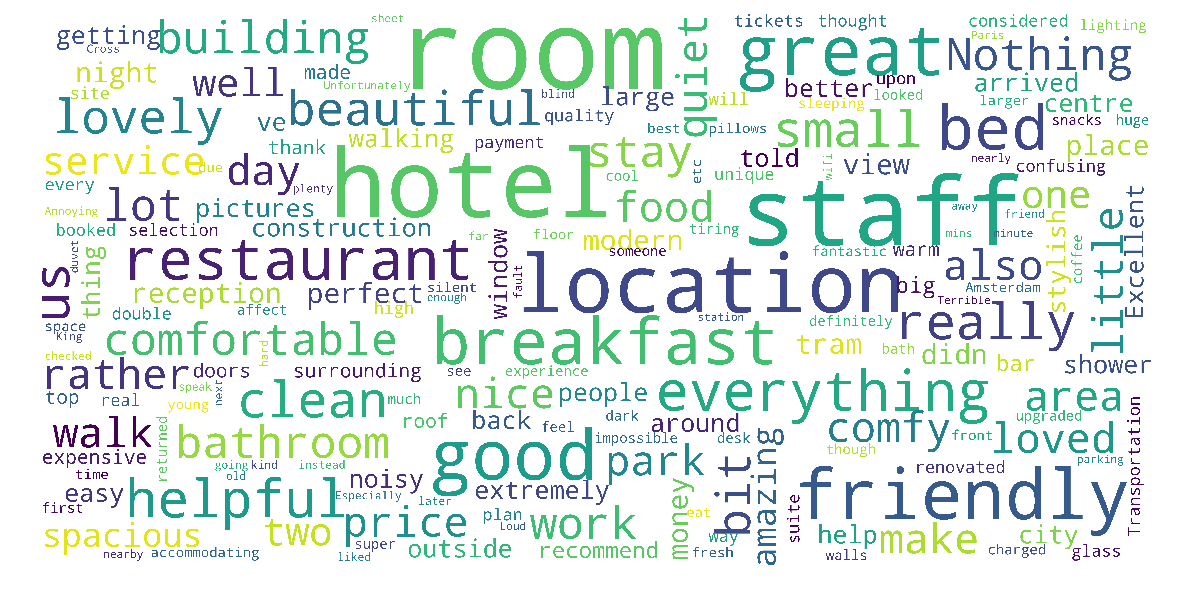

In [82]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 30,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [86]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

review    pos
35966                               Friendly helpful staff   0.857
34197               Staff friendly good value good location  0.851
31492                   Lovely friendly staf great location  0.847
32488                Great location clean comfortable rooms  0.835
34287                       Great location clean nice staff  0.828
35281   Superb location excellent value very pleasant hotel  0.821
25157                                 Great bed super comfy  0.800
27622                      Great location lovely breakfast   0.798
23839                           Lovely hotel great location  0.798
35963          Great location fantastic rooms awesome staff  0.797

In [87]:
#The most positive reviews indeed correspond to some good feedbacks.

# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

review    neg
26326                      Nothing Great service Great room  0.687
16248                   Nothing  Great room great location   0.687
10859                                   Nothing Best hotel   0.627
5211                      Nothing Location clean nice staff  0.605
4563                           Nothing Excellent breakfast   0.600
40530                          Nothing  Everything perfect   0.600
37274                          nothing good value for money  0.597
708                              NOTHING lOCATION WAS GREAT  0.561
34348                           no complaints Good location  0.557
40607   Terrible breakfast Terrible suite vs price Location  0.554

Some errors can be found among the most negative reviews: Vader sometimes interpret 'no' or 'nothing' as negative words whereas they are sometimes used to say that there were no problems with the hotel. Fortunately, most of the reviews are indeed bad ones.

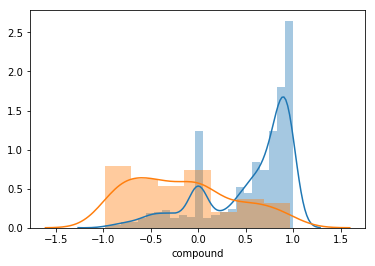

In [88]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    
    sns.distplot(subset['compound'], hist = True, label = label)


## Modelling reviewer_score


In [92]:
print(reviews_df.columns)

# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

Index(['review', 'is_bad_review', 'neg', 'neu', 'pos', 'compound', 'nb_chars',
       'nb_words'],
      dtype='object')


We first choose which features we want to use to train our model. Then we split our data into two parts:

one to train our model
one to assess its performances
We will next use a Random Forest (RF) classifier for our predictions.

In [93]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

feature  importance
4  nb_chars    0.221517
3  compound    0.207705
5  nb_words    0.164166
1       neu    0.149876
0       neg    0.135056
2       pos    0.121680